In [136]:
import pandas as pd
import os
import time
import re
from datetime import datetime
from utils import data_string_to_float
from tqdm import tqdm


# The directory where individual html files are stored
statspath = "intraQuarter/_KeyStats/"

# The list of features to parse from the html files
features = [  # Valuation measures
    "Market Cap",
    "Enterprise Value",
    "Trailing P/E",
    "Forward P/E",
    "PEG Ratio",
    "Price/Sales",
    "Price/Book",
    "Enterprise Value/Revenue",
    "Enterprise Value/EBITDA",
    #  Financial highlights
    "Profit Margin",
    "Operating Margin",
    "Return on Assets",
    "Return on Equity",
    "Revenue",
    "Revenue Per Share",
    "Qtrly Revenue Growth",
    "Gross Profit",
    "EBITDA",
    "Net Income Avl to Common",
    "Diluted EPS",
    "Qtrly Earnings Growth",
    "Total Cash",
    "Total Cash Per Share",
    "Total Debt",
    "Total Debt/Equity",
    "Current Ratio",
    "Book Value Per Share",
    "Operating Cash Flow",
    "Levered Free Cash Flow",
    # Trading information
    "Beta",
    "50-Day Moving Average",
    "200-Day Moving Average",
    "Avg Vol (3 month)",
    "Shares Outstanding",
    "Float",
    "% Held by Insiders",
    "% Held by Institutions",
    "Shares Short (as of",
    "Short Ratio",
    "Short % of Float",
    "Shares Short (prior month",
]


In [208]:
def preprocess_price_data():
    """
    Currently, the sp500 and stock price datasets we downloaded do not have any data for
    days when the market was closed (weekends and public holidays). We need to amend this so that
    all rows are included. Doing this now saves a lot of effort when we actually create the
    keystats dataset, which requires that we have stock data every day.
    :return: SP500 and stock dataframes, with no missing rows.
    """
    # Read in SP500 data and stock data, parsing the dates.
    sp500_raw_data = pd.read_csv("stock_data/sp500_08_2003_to_01_2015_index.csv", index_col="Date", parse_dates=True)
    stock_raw_data = pd.read_csv("stock_data/stock_all_sp500_08_2003_to_01_2015_prices.csv", index_col="Date", parse_dates=True)
    
    sp_start_date, sp_end_date  = str(sp500_raw_data.index[0]), str(sp500_raw_data.index[-1])
    stock_start_date, stock_end_date  = str(stock_raw_data.index[0]), str(stock_raw_data.index[-1])
    
    sp_date_range = pd.date_range(start=sp_start_date, end=sp_end_date, freq="D")  # Include all days
    stock_date_range = pd.date_range(start=stock_start_date, end=stock_end_date, freq="D")
    sp500_raw_data = sp500_raw_data.reindex(sp_date_range)
    stock_raw_data = stock_raw_data.reindex(stock_date_range)
    sp500_raw_data = sp500_raw_data.reset_index()
    stock_raw_data = stock_raw_data.reset_index()
    sp500_raw_data.rename(columns={"index": "Date"}, inplace=True)
    stock_raw_data.rename(columns={"index": "Date"}, inplace=True)

    


    
    sp500_raw_data.ffill(inplace=True)
    stock_raw_data.ffill(inplace=True)

    sp500_raw_data["Date"] = sp500_raw_data["Date"].dt.date
    stock_raw_data["Date"] = stock_raw_data["Date"].dt.date

    stock_raw_data['Date'] = stock_raw_data['Date'].astype(str)
    sp500_raw_data['Date'] = sp500_raw_data['Date'].astype(str)
    
    
    
    sp500_raw_data.set_index('Date', inplace=True)
    stock_raw_data.set_index('Date', inplace=True)

    
    

    return sp500_raw_data, stock_raw_data

In [209]:
def parse_keystats(sp500_df, stock_df):
    """
    We have downloaded a large number of html files, which are snapshots of a ticker at different times,
    containing the fundamental data (our features). To extract the key statistics, we use regex.
    For supervised machine learning, we also need the data that will form our dependent variable,
    the performance of the stock compared to the SP500.
    :sp500_df: dataframe containing SP500 prices
    :stock_df: dataframe containing stock prices
    :return: a dataframe of training data (i.e features and the components of our dependent variable)
    """
    # The tickers whose data is to be parsed.
    stock_list = [x[0] for x in os.walk(statspath)]
    stock_list = stock_list[1:]

    # Creating a new dataframe which we will later fill.
    df_columns = [
                     "Date",
                     "Unix",
                     "Ticker",
                     "Price",
                     "stock_p_change",
                     "SP500",
                     "SP500_p_change",
                 ] + features

    df = pd.DataFrame(columns=df_columns)

    # tqdm is a simple progress bar
    for stock_directory in tqdm(stock_list, desc="Parsing progress:", unit="tickers"):
        keystats_html_files = os.listdir(stock_directory)

        # Snippet to get rid of the .DS_Store file in macOS
        if ".DS_Store" in keystats_html_files:
            keystats_html_files.remove(".DS_Store")

        ticker = stock_directory.split(statspath)[1]

        for file in keystats_html_files:
            # Convert the datetime format of our file to unix time
            date_stamp = datetime.strptime(file, "%Y%m%d%H%M%S.html")
            unix_time = time.mktime(date_stamp.timetuple())

            # Read in the html file as a string.
            full_file_path = stock_directory + "/" + file

            # This will store the parsed values
            value_list = []

            with open(full_file_path, "r") as source:
                source = source.read()
                # Remove commas from the html to make parsing easier.
                source = source.replace(",", "")

                # Regex search for the different variables in the html file, then append to value_list
                for variable in features:
                    # Search for the table entry adjacent to the variable name.
                    try:
                        regex = (
                                r">"
                                + re.escape(variable)
                                + r".*?(\-?\d+\.*\d*K?M?B?|N/A[\\n|\s]*|>0|NaN)%?"
                                  r"(</td>|</span>)"
                        )
                        value = re.search(regex, source, flags=re.DOTALL).group(1)

                        # Dealing with number formatting
                        value_list.append(data_string_to_float(value))

                    # The data may not be present. Process accordingly
                    except AttributeError:
                        # In the past, 'Avg Vol' was instead named 'Average Volume'
                        # If 'Avg Vol' fails, search for 'Average Volume'.
                        if variable == "Avg Vol (3 month)":
                            try:
                                new_variable = ">Average Volume (3 month)"
                                regex = (
                                        re.escape(new_variable)
                                        + r".*?(\-?\d+\.*\d*K?M?B?|N/A[\\n|\s]*|>0)%?"
                                          r"(</td>|</span>)"
                                )
                                value = re.search(regex, source, flags=re.DOTALL).group(
                                    1
                                )
                                value_list.append(data_string_to_float(value))
                            except AttributeError:
                                value_list.append("N/A")
                        else:
                            value_list.append("N/A")

            # We need the stock price and SP500 price now and one year from now.
            # Convert from unix time to YYYY-MM-DD, so we can look for the price in the dataframe
            # then calculate the percentage change.
            current_date = datetime.fromtimestamp(unix_time).strftime("%Y-%m-%d")
            one_year_later = datetime.fromtimestamp(unix_time + 31536000).strftime(
                "%Y-%m-%d"
            )

            # SP500 prices now and one year later, and the percentage change
            sp500_price = float(sp500_df.loc[current_date, "Close"])
            sp500_1y_price = float(sp500_df.loc[one_year_later, "Close"])
            sp500_p_change = round(
                ((sp500_1y_price - sp500_price) / sp500_price * 100), 2
            )

            # Stock prices now and one year later. We need a try/except because some data is missing
            stock_price, stock_1y_price = "N/A", "N/A"
            try:
                stock_price = float(stock_df.loc[current_date, ticker.upper()])
                stock_1y_price = float(stock_df.loc[one_year_later, ticker.upper()])
            except KeyError:
                # If stock data is missing, we must skip this datapoint
                # print(f"PRICE RETRIEVAL ERROR for {ticker}")
                continue

            stock_p_change = round(
                ((stock_1y_price - stock_price) / stock_price * 100), 2
            )

            # Append all our data to the dataframe.
            new_df_row = [
                             date_stamp,
                             unix_time,
                             ticker,
                             stock_price,
                             stock_p_change,
                             sp500_price,
                             sp500_p_change,
                         ] + value_list

            print(dict(zip(df_columns, new_df_row)))
            df = pd.concat([df,pd.DataFrame(dict(zip(df_columns, new_df_row)), index=[0])], ignore_index=True)

    # Remove rows with missing stock price data
    df.dropna(axis=0, subset=["Price", "stock_p_change"], inplace=True)
    # Output the CSV
    df.to_csv("keystats.csv", index=False)





In [210]:
sp500_df, stock_df = preprocess_price_data()


In [157]:
sp500_df['Date'] = sp500_df['Date'].dt.date 
sp500_df['Date'] = sp500_df['Date'].astype(str)

In [187]:
sp500_df.head(5)

Open       High        Low      Close      Volume
Date                                                              
2003-08-01  66.228561  66.455574  65.594248  65.774529  49321000.0
2003-08-02  66.228561  66.455574  65.594248  65.774529  49321000.0
2003-08-03  66.228561  66.455574  65.594248  65.774529  49321000.0
2003-08-04  65.640987  66.101697  64.766309  65.774529  55214100.0
2003-08-05  65.707743  65.941434  64.325612  64.379028  61415600.0

In [159]:
stock_df['Date'] = stock_df['Date'].dt.date 
stock_df['Date'] = stock_df['Date'].astype(str)

In [188]:
stock_df.head(4)

Unnamed: 0      AAPL        ADI        AEP         AIG  AMP  \
Date                                                                      
2003-08-01         0.0  0.312263  24.616732  11.824886  762.900574  NaN   
2003-08-02         0.0  0.312263  24.616732  11.824886  762.900574  NaN   
2003-08-03         0.0  0.312263  24.616732  11.824886  762.900574  NaN   
2003-08-04         1.0  0.319494  24.753801  11.884094  757.317688  NaN   

              AMZN       AOS        AXP  GOOGL        MMM  
Date                                                       
2003-08-01  2.0015  3.886777  27.832899    NaN  31.513781  
2003-08-02  2.0015  3.886777  27.832899    NaN  31.513781  
2003-08-03  2.0015  3.886777  27.832899    NaN  31.513781  
2003-08-04  1.9825  3.809416  27.993156    NaN  31.765423

In [172]:
'2003-08-01' in list(sp500_df['Date'])

True

In [174]:
sp500_df.loc[sp500_df['Date'] == "2003-08-01", "Close"]

0    65.774529
Name: Close, dtype: float64

In [207]:
(1.18759369850159 - 0.335310041904449)/0.335310041904449


2.541777907265928

In [211]:
parse_keystats(sp500_df, stock_df)

Parsing progress::   0%|                           | 0/560 [00:00<?, ?tickers/s]/var/folders/dw/2t4v6cwj77324pyb6p5wmzx40000gn/T/ipykernel_57210/1997845747.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(dict(zip(df_columns, new_df_row)), index=[0])], ignore_index=True)
Parsing progress::   0%|                   | 1/560 [00:00<02:13,  4.17tickers/s]

{'Date': datetime.datetime(2007, 7, 11, 5, 59, 28), 'Unix': 1184129968.0, 'Ticker': 'ctas', 'Price': 4.924205303192139, 'stock_p_change': -30.09, 'SP500': 109.01325988769533, 'SP500_p_change': -15.9, 'Market Cap': 6350000000.0, 'Enterprise Value': 7080000000.0, 'Trailing P/E': 19.13, 'Forward P/E': 17.79, 'PEG Ratio': 1.49, 'Price/Sales': 1.74, 'Price/Book': 3.09, 'Enterprise Value/Revenue': 1.94, 'Enterprise Value/EBITDA': 9.904, 'Profit Margin': 9.3, 'Operating Margin': 15.92, 'Return on Assets': 10.58, 'Return on Equity': 16.01, 'Revenue': 3650000000.0, 'Revenue Per Share': 22.561, 'Qtrly Revenue Growth': 8.2, 'Gross Profit': 1450000000.0, 'EBITDA': 714370000.0, 'Net Income Avl to Common': 339540000.0, 'Diluted EPS': 2.09, 'Qtrly Earnings Growth': 0.2, 'Total Cash': 157490000.0, 'Total Cash Per Share': 0.993, 'Total Debt': 883520000.0, 'Total Debt/Equity': 0.43, 'Current Ratio': 1.662, 'Book Value Per Share': 12.961, 'Operating Cash Flow': 473040000.0, 'Levered Free Cash Flow': 2936

Parsing progress::   1%|▏                  | 4/560 [00:00<01:15,  7.35tickers/s]

{'Date': datetime.datetime(2011, 4, 25, 20, 49, 6), 'Unix': 1303760946.0, 'Ticker': 'vz', 'Price': 19.02404022216797, 'stock_p_change': 12.58, 'SP500': 103.88409423828124, 'SP500_p_change': 4.91, 'Market Cap': 104610000000.0, 'Enterprise Value': 149970000000.0, 'Trailing P/E': 41.1, 'Forward P/E': 14.06, 'PEG Ratio': 1.73, 'Price/Sales': 0.98, 'Price/Book': 2.71, 'Enterprise Value/Revenue': 1.41, 'Enterprise Value/EBITDA': 4.29, 'Profit Margin': 2.39, 'Operating Margin': 17.42, 'Return on Assets': 5.19, 'Return on Equity': 11.95, 'Revenue': 106560000000.0, 'Revenue Per Share': 37.66, 'Qtrly Revenue Growth': -2.6, 'Gross Profit': 62420000000.0, 'EBITDA': 34970000000.0, 'Net Income Avl to Common': 2550000000.0, 'Diluted EPS': 0.9, 'Qtrly Earnings Growth': 146.9, 'Total Cash': 7210000000.0, 'Total Cash Per Share': 2.55, 'Total Debt': 52790000000.0, 'Total Debt/Equity': 60.74, 'Current Ratio': 0.73, 'Book Value Per Share': 13.64, 'Operating Cash Flow': 33360000000.0, 'Levered Free Cash Flo

Parsing progress::   1%|▏                  | 5/560 [00:01<02:34,  3.60tickers/s]

{'Date': datetime.datetime(2006, 4, 24, 14, 57, 2), 'Unix': 1145887022.0, 'Ticker': 'amzn', 'Price': 1.7894999980926514, 'stock_p_change': 25.03, 'SP500': 91.79432678222656, 'SP500_p_change': 15.24, 'Market Cap': 14900000000.0, 'Enterprise Value': 14540000000.0, 'Trailing P/E': 42.41, 'Forward P/E': 42.06, 'PEG Ratio': 2.99, 'Price/Sales': 1.77, 'Price/Book': 60.96, 'Enterprise Value/Revenue': 1.71, 'Enterprise Value/EBITDA': 24.516, 'Profit Margin': 4.23, 'Operating Margin': 5.56, 'Return on Assets': 8.5, 'Return on Equity': 3505.26, 'Revenue': 8490000000.0, 'Revenue Per Share': 20.607, 'Qtrly Revenue Growth': 17.2, 'Gross Profit': 2040000000.0, 'EBITDA': 593000000.0, 'Net Income Avl to Common': 333000000.0, 'Diluted EPS': 0.84, 'Qtrly Earnings Growth': -42.5, 'Total Cash': 2000000000.0, 'Total Cash Per Share': 4.797, 'Total Debt': 1520000000.0, 'Total Debt/Equity': 6.163, 'Current Ratio': 1.518, 'Book Value Per Share': 0.591, 'Operating Cash Flow': 733000000.0, 'Levered Free Cash Flo

Parsing progress::   1%|▏                  | 7/560 [00:01<02:28,  3.72tickers/s]

{'Date': datetime.datetime(2004, 4, 13, 8, 9, 47), 'Unix': 1081840187.0, 'Ticker': 'cat', 'Price': 24.369213104248047, 'stock_p_change': 10.12, 'SP500': 76.50558471679688, 'SP500_p_change': 5.64, 'Market Cap': 28790000000.0, 'Enterprise Value': 48260000000.0, 'Trailing P/E': 26.59, 'Forward P/E': 14.69, 'PEG Ratio': 1.66, 'Price/Sales': 1.24, 'Price/Book': 4.64, 'Enterprise Value/Revenue': 2.12, 'Enterprise Value/EBITDA': 15.9, 'Profit Margin': 4.74, 'Operating Margin': 7.42, 'Return on Assets': 3.06, 'Return on Equity': 18.02, 'Revenue': 22760000000.0, 'Revenue Per Share': 64.744, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 5820000000.0, 'EBITDA': 3040000000.0, 'Net Income Avl to Common': 1100000000.0, 'Diluted EPS': 3.15, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 342000000.0, 'Total Cash Per Share': 0.99, 'Total Debt': 19820000000.0, 'Total Debt/Equity': 3.26, 'Current Ratio': 1.33, 'Book Value Per Share': 17.681, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 

Parsing progress::   1%|▎                  | 8/560 [00:01<02:24,  3.83tickers/s]

{'Date': datetime.datetime(2011, 5, 22, 15, 41, 19), 'Unix': 1306075279.0, 'Ticker': 'aapl', 'Price': 10.099066734313965, 'stock_p_change': 67.44, 'SP500': 103.86077880859376, 'SP500_p_change': 0.85, 'Market Cap': 310000000000.0, 'Enterprise Value': 280760000000.0, 'Trailing P/E': 15.97, 'Forward P/E': 11.77, 'PEG Ratio': 0.66, 'Price/Sales': 3.6, 'Price/Book': 5.12, 'Enterprise Value/Revenue': 3.21, 'Enterprise Value/EBITDA': 10.5, 'Profit Margin': 22.36, 'Operating Margin': 29.02, 'Return on Assets': 20.88, 'Return on Equity': 38.78, 'Revenue': 87450000000.0, 'Revenue Per Share': 95.33, 'Qtrly Revenue Growth': 82.7, 'Gross Profit': 25680000000.0, 'EBITDA': 26730000000.0, 'Net Income Avl to Common': 19550000000.0, 'Diluted EPS': 20.99, 'Qtrly Earnings Growth': 94.8, 'Total Cash': 29230000000.0, 'Total Cash Per Share': 31.61, 'Total Debt': 0.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.93, 'Book Value Per Share': 66.49, 'Operating Cash Flow': 26480000000.0, 'Levered Free Cash Flow

Parsing progress::   2%|▎                 | 11/560 [00:02<01:23,  6.54tickers/s]

{'Date': datetime.datetime(2011, 9, 3, 5, 4, 33), 'Unix': 1315022673.0, 'Ticker': 'pm', 'Price': 35.67656326293945, 'stock_p_change': 36.18, 'SP500': 92.06401824951172, 'SP500_p_change': 22.32, 'Market Cap': 119860000000.0, 'Enterprise Value': 134610000000.00002, 'Trailing P/E': 15.63, 'Forward P/E': 13.05, 'PEG Ratio': 1.14, 'Price/Sales': 4.24, 'Price/Book': 33.27, 'Enterprise Value/Revenue': 4.69, 'Enterprise Value/EBITDA': 10.09, 'Profit Margin': 27.52, 'Operating Margin': 43.05, 'Return on Assets': 22.04, 'Return on Equity': 152.36, 'Revenue': 28720000000.0, 'Revenue Per Share': 15.95, 'Qtrly Revenue Growth': 17.2, 'Gross Profit': 17500000000.0, 'EBITDA': 13340000000.0, 'Net Income Avl to Common': 7860000000.0, 'Diluted EPS': 4.37, 'Qtrly Earnings Growth': 21.5, 'Total Cash': 2180000000.0, 'Total Cash Per Share': 1.24, 'Total Debt': 16920000000.000002, 'Total Debt/Equity': 326.66, 'Current Ratio': 0.97, 'Book Value Per Share': 2.08, 'Operating Cash Flow': 10510000000.0, 'Levered F

Parsing progress::   3%|▍                 | 15/560 [00:02<00:56,  9.72tickers/s]

{'Date': datetime.datetime(2006, 10, 23, 13, 36, 38), 'Unix': 1161606998.0, 'Ticker': 'cmcsa', 'Price': 9.13369083404541, 'stock_p_change': -7.96, 'SP500': 97.24609375, 'SP500_p_change': 12.46, 'Market Cap': 79480000000.0, 'Enterprise Value': 102280000000.0, 'Trailing P/E': 64.05, 'Forward P/E': 30.14, 'PEG Ratio': 2.35, 'Price/Sales': 3.39, 'Price/Book': 1.99, 'Enterprise Value/Revenue': 4.37, 'Enterprise Value/EBITDA': 11.477, 'Profit Margin': 5.47, 'Operating Margin': 17.4, 'Return on Assets': 2.45, 'Return on Equity': 3.15, 'Revenue': 23420000000.0, 'Revenue Per Share': 10.879, 'Qtrly Revenue Growth': 11.3, 'Gross Profit': 14290000000.0, 'EBITDA': 8910000000.0, 'Net Income Avl to Common': 1280000000.0, 'Diluted EPS': 0.59, 'Qtrly Earnings Growth': 7.0, 'Total Cash': 1790000000.0, 'Total Cash Per Share': 0.853, 'Total Debt': 24120000000.0, 'Total Debt/Equity': 0.604, 'Current Ratio': 0.614, 'Book Value Per Share': 19.069, 'Operating Cash Flow': 5650000000.0, 'Levered Free Cash Flow'

Parsing progress::   3%|▌                 | 17/560 [00:02<00:55,  9.79tickers/s]

{'Date': datetime.datetime(2007, 2, 25, 8, 31, 59), 'Unix': 1172392319.0, 'Ticker': 'grmn', 'Price': 31.695964813232425, 'stock_p_change': 10.03, 'SP500': 103.3577117919922, 'SP500_p_change': -3.74, 'Market Cap': 12410000000.0, 'Enterprise Value': 12000000000.0, 'Trailing P/E': 24.47, 'Forward P/E': 18.31, 'PEG Ratio': 1.18, 'Price/Sales': 6.9, 'Price/Book': 7.82, 'Enterprise Value/Revenue': 6.76, 'Enterprise Value/EBITDA': 20.029, 'Profit Margin': 28.98, 'Operating Margin': 31.26, 'Return on Assets': 21.27, 'Return on Equity': 37.87, 'Revenue': 1770000000.0, 'Revenue Per Share': 8.2, 'Qtrly Revenue Growth': 91.4, 'Gross Profit': 535070000.00000006, 'EBITDA': 599030000.0, 'Net Income Avl to Common': 514120000.0, 'Diluted EPS': 2.35, 'Qtrly Earnings Growth': 107.0, 'Total Cash': 410350000.0, 'Total Cash Per Share': 1.901, 'Total Debt': 248000.0, 'Total Debt/Equity': 0, 'Current Ratio': 3.462, 'Book Value Per Share': 7.247, 'Operating Cash Flow': 361860000.0, 'Levered Free Cash Flow': 11

Parsing progress::   4%|▋                 | 22/560 [00:02<00:43, 12.27tickers/s]

{'Date': datetime.datetime(2005, 5, 27, 11, 11, 7), 'Unix': 1117188667.0, 'Ticker': 'cah', 'Price': 26.61143684387207, 'stock_p_change': 16.31, 'SP500': 82.8541488647461, 'SP500_p_change': 8.65, 'Market Cap': 24890000000.0, 'Enterprise Value': 26020000000.0, 'Trailing P/E': 21.37, 'Forward P/E': 15.46, 'PEG Ratio': 1.28, 'Price/Sales': 0.34, 'Price/Book': 2.88, 'Enterprise Value/Revenue': 0.36, 'Enterprise Value/EBITDA': 11.72, 'Profit Margin': 1.64, 'Operating Margin': 2.54, 'Return on Assets': 5.52, 'Return on Equity': 14.44, 'Revenue': 72380000000.0, 'Revenue Per Share': 165.887, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 4740000000.0, 'EBITDA': 2220000000.0, 'Net Income Avl to Common': 1190000000.0, 'Diluted EPS': 2.72, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1760000000.0, 'Total Cash Per Share': 4.12, 'Total Debt': 2890000000.0, 'Total Debt/Equity': 0.333, 'Current Ratio': 1.366, 'Book Value Per Share': 20.177, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A

Parsing progress::   5%|▊                 | 27/560 [00:03<00:46, 11.57tickers/s]

{'Date': datetime.datetime(2011, 11, 3, 7, 46, 55), 'Unix': 1320306415.0, 'Ticker': 'fslr', 'Price': 48.18000030517578, 'stock_p_change': -53.22, 'SP500': 99.1363525390625, 'SP500_p_change': 14.53, 'Market Cap': 4080000000.0, 'Enterprise Value': 3930000000.0, 'Trailing P/E': 7.76, 'Forward P/E': 5.14, 'PEG Ratio': 0.3, 'Price/Sales': 1.5, 'Price/Book': 1.01, 'Enterprise Value/Revenue': 1.45, 'Enterprise Value/EBITDA': 4.74, 'Profit Margin': 19.5, 'Operating Margin': 22.7, 'Return on Assets': 7.76, 'Return on Equity': 14.46, 'Revenue': 2720000000.0, 'Revenue Per Share': 31.67, 'Qtrly Revenue Growth': 26.1, 'Gross Profit': 1180000000.0, 'EBITDA': 827710000.0, 'Net Income Avl to Common': 529559999.99999994, 'Diluted EPS': 6.09, 'Qtrly Earnings Growth': 11.1, 'Total Cash': 762910000.0, 'Total Cash Per Share': 8.83, 'Total Debt': 608340000.0, 'Total Debt/Equity': 15.11, 'Current Ratio': 3.25, 'Book Value Per Share': 46.61, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta

Parsing progress::   5%|▉                 | 29/560 [00:03<00:54,  9.80tickers/s]

{'Date': datetime.datetime(2012, 3, 11, 13, 28, 28), 'Unix': 1331472508.0, 'Ticker': 'pfe', 'Price': 12.489821434020996, 'stock_p_change': 36.43, 'SP500': 108.71033477783205, 'SP500_p_change': 15.93, 'Market Cap': 161930000000.0, 'Enterprise Value': 174220000000.0, 'Trailing P/E': 16.89, 'Forward P/E': 9.14, 'PEG Ratio': 3.35, 'Price/Sales': 2.4, 'Price/Book': 1.98, 'Enterprise Value/Revenue': 2.58, 'Enterprise Value/EBITDA': 6.32, 'Profit Margin': 14.85, 'Operating Margin': 29.32, 'Return on Assets': 6.45, 'Return on Equity': 10.23, 'Revenue': 67420000000.0, 'Revenue Per Share': 8.63, 'Qtrly Revenue Growth': -3.5, 'Gross Profit': 52340000000.0, 'EBITDA': 27560000000.0, 'Net Income Avl to Common': 8700000000.0, 'Diluted EPS': 1.27, 'Qtrly Earnings Growth': -50.2, 'Total Cash': 26760000000.0, 'Total Cash Per Share': 3.55, 'Total Debt': 38960000000.0, 'Total Debt/Equity': 47.16, 'Current Ratio': 2.06, 'Book Value Per Share': 10.84, 'Operating Cash Flow': 20240000000.0, 'Levered Free Cash

Parsing progress::   6%|█                 | 33/560 [00:03<00:48, 10.78tickers/s]

{'Date': datetime.datetime(2003, 11, 24, 22, 46, 56), 'Unix': 1069714016.0, 'Ticker': 'fitb', 'Price': 30.472820281982425, 'stock_p_change': -10.03, 'SP500': 70.77244567871094, 'SP500_p_change': 14.05, 'Market Cap': 33240000000.000004, 'Enterprise Value': 53350000000.0, 'Trailing P/E': 19.69, 'Forward P/E': 16.82, 'PEG Ratio': 1.58, 'Price/Sales': 8.12, 'Price/Book': 3.84, 'Enterprise Value/Revenue': 13.24, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 43.64, 'Operating Margin': 'N/A', 'Return on Assets': 2.09, 'Return on Equity': 20.29, 'Revenue': 6320000000.0, 'Revenue Per Share': 6.919, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 5400000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 1730000000.0, 'Diluted EPS': 2.967, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 2390000000.0, 'Total Cash Per Share': 4.21, 'Total Debt': 23000000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 14.98, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow'

Parsing progress::   6%|█▏                | 35/560 [00:04<00:47, 11.15tickers/s]

{'Date': datetime.datetime(2013, 8, 16, 20, 42, 6), 'Unix': 1376682126.0, 'Ticker': 'kmi', 'Price': 21.09327888488769, 'stock_p_change': 16.0, 'SP500': 135.25537109375, 'SP500_p_change': 20.34, 'Market Cap': 38780000000.0, 'Enterprise Value': 73520000000.0, 'Trailing P/E': 39.29, 'Forward P/E': 23.85, 'PEG Ratio': 0.65, 'Price/Sales': 3.14, 'Price/Book': 2.85, 'Enterprise Value/Revenue': 5.93, 'Enterprise Value/EBITDA': 13.86, 'Profit Margin': 7.98, 'Operating Margin': 29.35, 'Return on Assets': 3.16, 'Return on Equity': 8.9, 'Revenue': 12390000000.0, 'Revenue Per Share': 11.94, 'Qtrly Revenue Growth': 56.1, 'Gross Profit': 5210000000.0, 'EBITDA': 5300000000.0, 'Net Income Avl to Common': 1110000000.0, 'Diluted EPS': 0.95, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1020000000.0, 'Total Cash Per Share': 0.98, 'Total Debt': 35600000000.0, 'Total Debt/Equity': 124.72, 'Current Ratio': 0.51, 'Book Value Per Share': 13.18, 'Operating Cash Flow': 3500000000.0, 'Levered Free Cash Flow': 26

Parsing progress::   7%|█▎                | 39/560 [00:04<00:40, 12.81tickers/s]

{'Date': datetime.datetime(2012, 7, 2, 11, 22, 21), 'Unix': 1341224541.0, 'Ticker': 'mmc', 'Price': 25.682029724121094, 'stock_p_change': 27.44, 'SP500': 108.90682220458984, 'SP500_p_change': 20.73, 'Market Cap': 17610000000.0, 'Enterprise Value': 19110000000.0, 'Trailing P/E': 17.54, 'Forward P/E': 13.21, 'PEG Ratio': 1.22, 'Price/Sales': 1.51, 'Price/Book': 2.84, 'Enterprise Value/Revenue': 1.64, 'Enterprise Value/EBITDA': 9.44, 'Profit Margin': 8.68, 'Operating Margin': 14.48, 'Return on Assets': 7.04, 'Return on Equity': 15.7, 'Revenue': 11690000000.0, 'Revenue Per Share': 21.59, 'Qtrly Revenue Growth': 5.8, 'Gross Profit': 11530000000.0, 'EBITDA': 2020000000.0, 'Net Income Avl to Common': 990000000.0, 'Diluted EPS': 1.84, 'Qtrly Earnings Growth': 6.8, 'Total Cash': 1420000000.0, 'Total Cash Per Share': 2.59, 'Total Debt': 2920000000.0, 'Total Debt/Equity': 46.66, 'Current Ratio': 1.66, 'Book Value Per Share': 11.35, 'Operating Cash Flow': 1580000000.0, 'Levered Free Cash Flow': 11

Parsing progress::   8%|█▎                | 42/560 [00:04<00:32, 16.05tickers/s]

{'Date': datetime.datetime(2007, 5, 28, 18, 16, 34), 'Unix': 1180372594.0, 'Ticker': 'pep', 'Price': 41.21335983276367, 'stock_p_change': 2.44, 'SP500': 108.33113098144533, 'SP500_p_change': -6.81, 'Market Cap': 112100000000.0, 'Enterprise Value': 113170000000.0, 'Trailing P/E': 19.98, 'Forward P/E': 18.65, 'PEG Ratio': 1.87, 'Price/Sales': 3.12, 'Price/Book': 7.24, 'Enterprise Value/Revenue': 3.16, 'Enterprise Value/EBITDA': 13.141, 'Profit Margin': 16.19, 'Operating Margin': 18.45, 'Return on Assets': 14.83, 'Return on Equity': 38.49, 'Revenue': 35770000000.0, 'Revenue Per Share': 21.753, 'Qtrly Revenue Growth': 9.4, 'Gross Profit': 19380000000.0, 'EBITDA': 8610000000.0, 'Net Income Avl to Common': 5780000000.0, 'Diluted EPS': 3.44, 'Qtrly Earnings Growth': 15.7, 'Total Cash': 1740000000.0, 'Total Cash Per Share': 1.066, 'Total Debt': 2810000000.0, 'Total Debt/Equity': 0.183, 'Current Ratio': 1.155, 'Book Value Per Share': 9.46, 'Operating Cash Flow': 6540000000.0, 'Levered Free Cash

Parsing progress::   8%|█▍                | 46/560 [00:04<00:41, 12.29tickers/s]

{'Date': datetime.datetime(2007, 12, 13, 21, 28, 50), 'Unix': 1197581330.0, 'Ticker': 'pep', 'Price': 47.88156127929688, 'stock_p_change': -32.16, 'SP500': 107.41886901855467, 'SP500_p_change': -39.03, 'Market Cap': 126670000000.0, 'Enterprise Value': 126440000000.0, 'Trailing P/E': 21.08, 'Forward P/E': 20.98, 'PEG Ratio': 2.09, 'Price/Sales': 3.33, 'Price/Book': 7.7, 'Enterprise Value/Revenue': 3.35, 'Enterprise Value/EBITDA': 15.089, 'Profit Margin': 16.51, 'Operating Margin': 18.48, 'Return on Assets': 13.46, 'Return on Equity': 38.58, 'Revenue': 37700000000.0, 'Revenue Per Share': 23.124, 'Qtrly Revenue Growth': 11.4, 'Gross Profit': 19380000000.0, 'EBITDA': 8380000000.000001, 'Net Income Avl to Common': 6210000000.0, 'Diluted EPS': 3.73, 'Qtrly Earnings Growth': 16.7, 'Total Cash': 2240000000.0, 'Total Cash Per Share': 1.39, 'Total Debt': 2980000000.0, 'Total Debt/Equity': 0.184, 'Current Ratio': 1.228, 'Book Value Per Share': 10.143, 'Operating Cash Flow': 6980000000.0, 'Levered

Parsing progress::   9%|█▌                | 48/560 [00:05<01:16,  6.71tickers/s]

{'Date': datetime.datetime(2009, 2, 16, 19, 11, 38), 'Unix': 1234811498.0, 'Ticker': 'mmm', 'Price': 25.344905853271484, 'stock_p_change': 68.34, 'SP500': 61.399993896484375, 'SP500_p_change': 35.67, 'Market Cap': 34270000000.000004, 'Enterprise Value': 38770000000.0, 'Trailing P/E': 10.1, 'Forward P/E': 11.03, 'PEG Ratio': 1.15, 'Price/Sales': 1.37, 'Price/Book': 3.51, 'Enterprise Value/Revenue': 1.53, 'Enterprise Value/EBITDA': 6.087, 'Profit Margin': 13.69, 'Operating Margin': 20.74, 'Return on Assets': 13.01, 'Return on Equity': 32.0, 'Revenue': 25270000000.0, 'Revenue Per Share': 36.14, 'Qtrly Revenue Growth': -11.2, 'Gross Profit': 11730000000.0, 'EBITDA': 6370000000.0, 'Net Income Avl to Common': 3460000000.0, 'Diluted EPS': 4.89, 'Qtrly Earnings Growth': -37.0, 'Total Cash': 2220000000.0, 'Total Cash Per Share': 3.204, 'Total Debt': 6720000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.66, 'Book Value Per Share': 14.244, 'Operating Cash Flow': 4530000000.0, 'Levered Free

Parsing progress::   9%|█▌                | 50/560 [00:05<01:05,  7.83tickers/s]

{'Date': datetime.datetime(2005, 2, 20, 4, 20, 55), 'Unix': 1108873255.0, 'Ticker': 'emn', 'Price': 15.788500785827637, 'stock_p_change': -7.18, 'SP500': 82.62608337402344, 'SP500_p_change': 8.88, 'Market Cap': 4490000000.0, 'Enterprise Value': 6550000000.0, 'Trailing P/E': 26.16, 'Forward P/E': 11.65, 'PEG Ratio': 2.17, 'Price/Sales': 0.68, 'Price/Book': 3.75, 'Enterprise Value/Revenue': 1.0, 'Enterprise Value/EBITDA': 13.18, 'Profit Margin': 2.58, 'Operating Margin': 2.66, 'Return on Assets': 2.9, 'Return on Equity': 16.0, 'Revenue': 6580000000.0, 'Revenue Per Share': 84.143, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 810000000.0, 'EBITDA': 497000000.0, 'Net Income Avl to Common': 170000000.0, 'Diluted EPS': 2.16, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 'N/A', 'Total Cash Per Share': 0, 'Total Debt': 2060000000.0, 'Total Debt/Equity': 1.731, 'Current Ratio': 1.577, 'Book Value Per Share': 15.019, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0.864, 

Parsing progress::   9%|█▋                | 52/560 [00:05<01:05,  7.76tickers/s]

{'Date': datetime.datetime(2004, 5, 12, 18, 46, 27), 'Unix': 1084383987.0, 'Ticker': 'adi', 'Price': 28.738258361816406, 'stock_p_change': -25.03, 'SP500': 74.64042663574219, 'SP500_p_change': 7.04, 'Market Cap': 16829999999.999998, 'Enterprise Value': 15120000000.0, 'Trailing P/E': 49.06, 'Forward P/E': 22.52, 'PEG Ratio': 1.46, 'Price/Sales': 7.97, 'Price/Book': 5.07, 'Enterprise Value/Revenue': 6.92, 'Enterprise Value/EBITDA': 33.84, 'Profit Margin': 16.25, 'Operating Margin': 20.38, 'Return on Assets': 7.46, 'Return on Equity': 11.15, 'Revenue': 2190000000.0, 'Revenue Per Share': 5.663, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1120000000.0, 'EBITDA': 446780000.0, 'Net Income Avl to Common': 355130000.0, 'Diluted EPS': 0.918, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 2310000000.0, 'Total Cash Per Share': 6.17, 'Total Debt': 0, 'Total Debt/Equity': 0, 'Current Ratio': 6.053, 'Book Value Per Share': 9.198, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta'

Parsing progress::  10%|█▊                | 57/560 [00:06<00:40, 12.44tickers/s]

{'Date': datetime.datetime(2009, 2, 16, 17, 51, 3), 'Unix': 1234806663.0, 'Ticker': 'mas', 'Price': 4.296844005584717, 'stock_p_change': 123.99, 'SP500': 61.399993896484375, 'SP500_p_change': 35.67, 'Market Cap': 2260000000.0, 'Enterprise Value': 5220000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 23.0, 'PEG Ratio': 'N/A', 'Price/Sales': 0.25, 'Price/Book': 0.85, 'Enterprise Value/Revenue': 0.54, 'Enterprise Value/EBITDA': 6.617, 'Profit Margin': -4.07, 'Operating Margin': 5.73, 'Return on Assets': 3.37, 'Return on Equity': -11.12, 'Revenue': 9600000000.0, 'Revenue Per Share': 27.195, 'Qtrly Revenue Growth': -26.6, 'Gross Profit': 3210000000.0, 'EBITDA': 788670000.0, 'Net Income Avl to Common': -382000000.0, 'Diluted EPS': -1.11, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1030000000.0, 'Total Cash Per Share': 2.929, 'Total Debt': 3990000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 2.133, 'Book Value Per Share': 8.108, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N

Parsing progress::  11%|█▉                | 59/560 [00:06<00:41, 12.15tickers/s]

{'Date': datetime.datetime(2008, 12, 7, 7, 7, 25), 'Unix': 1228633645.0, 'Ticker': 'mgm', 'Price': 10.087369918823242, 'stock_p_change': -2.9, 'SP500': 64.7103500366211, 'SP500_p_change': 29.32, 'Market Cap': 2950000000.0, 'Enterprise Value': 15990000000.0, 'Trailing P/E': 2.68, 'Forward P/E': 10.68, 'PEG Ratio': 0.66, 'Price/Sales': 0.37, 'Price/Book': 0.55, 'Enterprise Value/Revenue': 2.13, 'Enterprise Value/EBITDA': 8.16, 'Profit Margin': 15.51, 'Operating Margin': 15.63, 'Return on Assets': 3.08, 'Return on Equity': 23.93, 'Revenue': 7510000000.0, 'Revenue Per Share': 26.421, 'Qtrly Revenue Growth': -5.9, 'Gross Profit': 3550000000.0, 'EBITDA': 1960000000.0, 'Net Income Avl to Common': 1160000000.0, 'Diluted EPS': 3.99, 'Qtrly Earnings Growth': -66.7, 'Total Cash': 250090000.0, 'Total Cash Per Share': 0.904, 'Total Debt': 13290000000.0, 'Total Debt/Equity': 2.583, 'Current Ratio': 0.779, 'Book Value Per Share': 18.606001, 'Operating Cash Flow': 797750000.0, 'Levered Free Cash Flow'

Parsing progress::  11%|█▉                | 61/560 [00:06<00:41, 11.98tickers/s]

{'Date': datetime.datetime(2005, 2, 25, 16, 11, 29), 'Unix': 1109347889.0, 'Ticker': 'vlo', 'Price': 19.37394905090332, 'stock_p_change': 54.91, 'SP500': 83.33985137939453, 'SP500_p_change': 8.45, 'Market Cap': 18260000000.0, 'Enterprise Value': 21570000000.0, 'Trailing P/E': 13.5, 'Forward P/E': 13.13, 'PEG Ratio': 1.57, 'Price/Sales': 0.36, 'Price/Book': 2.51, 'Enterprise Value/Revenue': 0.44, 'Enterprise Value/EBITDA': 7.16, 'Profit Margin': 2.97, 'Operating Margin': 4.93, 'Return on Assets': 8.35, 'Return on Equity': 23.36, 'Revenue': 48740000000.0, 'Revenue Per Share': 179.397, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 4380000000.0, 'EBITDA': 3010000000.0, 'Net Income Avl to Common': 1430000000.0, 'Diluted EPS': 5.27, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 680800000.0, 'Total Cash Per Share': 2.65, 'Total Debt': 4590000000.0, 'Total Debt/Equity': 0.635, 'Current Ratio': 1.146, 'Book Value Per Share': 27.400999, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N

Parsing progress::  12%|██                | 65/560 [00:06<00:39, 12.62tickers/s]

{'Date': datetime.datetime(2007, 3, 12, 13, 11, 4), 'Unix': 1173705064.0, 'Ticker': 'ups', 'Price': 41.43874740600586, 'stock_p_change': 4.74, 'SP500': 100.29182434082033, 'SP500_p_change': -4.22, 'Market Cap': 75320000000.0, 'Enterprise Value': 77460000000.0, 'Trailing P/E': 18.3, 'Forward P/E': 15.29, 'PEG Ratio': 1.41, 'Price/Sales': 1.58, 'Price/Book': 4.88, 'Enterprise Value/Revenue': 1.63, 'Enterprise Value/EBITDA': 8.845, 'Profit Margin': 8.84, 'Operating Margin': 13.97, 'Return on Assets': 12.85, 'Return on Equity': 25.97, 'Revenue': 47550000000.0, 'Revenue Per Share': 43.822, 'Qtrly Revenue Growth': 5.6, 'Gross Profit': 38240000000.0, 'EBITDA': 8760000000.0, 'Net Income Avl to Common': 4200000000.0, 'Diluted EPS': 3.86, 'Qtrly Earnings Growth': 7.5, 'Total Cash': 1980000000.0, 'Total Cash Per Share': 1.859, 'Total Debt': 4120000000.0, 'Total Debt/Equity': 0.266, 'Current Ratio': 1.396, 'Book Value Per Share': 14.469, 'Operating Cash Flow': 5590000000.0, 'Levered Free Cash Flow

Parsing progress::  12%|██▏               | 67/560 [00:07<00:42, 11.52tickers/s]

{'Date': datetime.datetime(2006, 4, 27, 21, 54, 41), 'Unix': 1146171281.0, 'Ticker': 'cme', 'Price': 47.99737930297852, 'stock_p_change': 12.27, 'SP500': 91.8784637451172, 'SP500_p_change': 16.23, 'Market Cap': 16180000000.0, 'Enterprise Value': 15380000000.0, 'Trailing P/E': 53.08, 'Forward P/E': 33.88, 'PEG Ratio': 2.13, 'Price/Sales': 16.59, 'Price/Book': 14.48, 'Enterprise Value/Revenue': 15.74, 'Enterprise Value/EBITDA': 23.528, 'Profit Margin': 31.4, 'Operating Margin': 60.19, 'Return on Assets': 10.77, 'Return on Equity': 31.78, 'Revenue': 977300000.0, 'Revenue Per Share': 28.48, 'Qtrly Revenue Growth': 28.3, 'Gross Profit': 919360000.0, 'EBITDA': 653860000.0, 'Net Income Avl to Common': 306860000.0, 'Diluted EPS': 8.81, 'Qtrly Earnings Growth': 34.3, 'Total Cash': 833590000.0, 'Total Cash Per Share': 24.093, 'Total Debt': 0, 'Total Debt/Equity': 0, 'Current Ratio': 1.337, 'Book Value Per Share': 32.381001, 'Operating Cash Flow': 391590000.0, 'Levered Free Cash Flow': 116300000.

Parsing progress::  12%|██▏               | 69/560 [00:07<00:44, 11.12tickers/s]

{'Date': datetime.datetime(2013, 5, 13, 8, 3, 38), 'Unix': 1368428618.0, 'Ticker': 'emr', 'Price': 41.87540054321289, 'stock_p_change': 21.29, 'SP500': 132.68551635742188, 'SP500_p_change': 18.5, 'Market Cap': 42040000000.0, 'Enterprise Value': 44970000000.0, 'Trailing P/E': 20.55, 'Forward P/E': 14.82, 'PEG Ratio': 1.68, 'Price/Sales': 1.7, 'Price/Book': 3.94, 'Enterprise Value/Revenue': 1.82, 'Enterprise Value/EBITDA': 9.1, 'Profit Margin': 8.37, 'Operating Margin': 16.66, 'Return on Assets': 10.75, 'Return on Equity': 19.98, 'Revenue': 24700000000.0, 'Revenue Per Share': 34.07, 'Qtrly Revenue Growth': 0.7, 'Gross Profit': 9770000000.0, 'EBITDA': 4940000000.0, 'Net Income Avl to Common': 2069999999.9999998, 'Diluted EPS': 2.82, 'Qtrly Earnings Growth': 2.9, 'Total Cash': 2620000000.0, 'Total Cash Per Share': 3.61, 'Total Debt': 5540000000.0, 'Total Debt/Equity': 51.94, 'Current Ratio': 1.53, 'Book Value Per Share': 14.72, 'Operating Cash Flow': 3310000000.0, 'Levered Free Cash Flow':

Parsing progress::  13%|██▎               | 71/560 [00:07<00:47, 10.23tickers/s]

{'Date': datetime.datetime(2006, 8, 22, 11, 58, 35), 'Unix': 1156244315.0, 'Ticker': 'syy', 'Price': 17.702865600585938, 'stock_p_change': 13.92, 'SP500': 91.64364624023438, 'SP500_p_change': 14.77, 'Market Cap': 18590000000.0, 'Enterprise Value': 20150000000.0, 'Trailing P/E': 22.1, 'Forward P/E': 16.52, 'PEG Ratio': 1.35, 'Price/Sales': 0.57, 'Price/Book': 6.09, 'Enterprise Value/Revenue': 0.62, 'Enterprise Value/EBITDA': 10.246, 'Profit Margin': 2.62, 'Operating Margin': 4.58, 'Return on Assets': 11.75, 'Return on Equity': 29.12, 'Revenue': 32630000000.000004, 'Revenue Per Share': 52.509, 'Qtrly Revenue Growth': 6.6, 'Gross Profit': 5780000000.0, 'EBITDA': 1970000000.0, 'Net Income Avl to Common': 846040000.0, 'Diluted EPS': 1.36, 'Qtrly Earnings Growth': -10.7, 'Total Cash': 201900000.0, 'Total Cash Per Share': 0.326, 'Total Debt': 1760000000.0, 'Total Debt/Equity': 0.577, 'Current Ratio': 1.364, 'Book Value Per Share': 4.937, 'Operating Cash Flow': 1120000000.0, 'Levered Free Cash

Parsing progress::  13%|██▎               | 73/560 [00:07<00:50,  9.62tickers/s]

{'Date': datetime.datetime(2007, 7, 1, 21, 6, 34), 'Unix': 1183320394.0, 'Ticker': 'ms', 'Price': 47.71541595458984, 'stock_p_change': -47.19, 'SP500': 107.894287109375, 'SP500_p_change': -13.21, 'Market Cap': 89900000000.0, 'Enterprise Value': -142490000000.0, 'Trailing P/E': 9.54, 'Forward P/E': 9.42, 'PEG Ratio': 0.72, 'Price/Sales': 2.32, 'Price/Book': 2.45, 'Enterprise Value/Revenue': -3.64, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 23.78, 'Operating Margin': 37.87, 'Return on Assets': 'N/A', 'Return on Equity': 'N/A', 'Revenue': 39160000000.0, 'Revenue Per Share': 39.025, 'Qtrly Revenue Growth': 31.5, 'Gross Profit': 73000000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 9150000000.0, 'Diluted EPS': 8.8, 'Qtrly Earnings Growth': 39.3, 'Total Cash': 929260000000.0, 'Total Cash Per Share': 867.009, 'Total Debt': 695770000000.0, 'Total Debt/Equity': 18.332, 'Current Ratio': 'N/A', 'Book Value Per Share': 34.714001, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow'

Parsing progress::  13%|██▍               | 75/560 [00:08<01:15,  6.43tickers/s]

{'Date': datetime.datetime(2011, 9, 3, 8, 31, 58), 'Unix': 1315035118.0, 'Ticker': 'wmt', 'Price': 13.112213134765623, 'stock_p_change': 43.08, 'SP500': 92.06401824951172, 'SP500_p_change': 22.32, 'Market Cap': 180650000000.0, 'Enterprise Value': 229620000000.0, 'Trailing P/E': 11.07, 'Forward P/E': 10.64, 'PEG Ratio': 1.18, 'Price/Sales': 0.42, 'Price/Book': 2.69, 'Enterprise Value/Revenue': 0.53, 'Enterprise Value/EBITDA': 6.79, 'Profit Margin': 3.87, 'Operating Margin': 6.0, 'Return on Assets': 8.73, 'Return on Equity': 23.18, 'Revenue': 431870000000.0, 'Revenue Per Share': 122.2, 'Qtrly Revenue Growth': 5.4, 'Gross Profit': 106560000000.0, 'EBITDA': 33810000000.000004, 'Net Income Avl to Common': 15690000000.0, 'Diluted EPS': 4.7, 'Qtrly Earnings Growth': 5.7, 'Total Cash': 8100000000.0, 'Total Cash Per Share': 2.33, 'Total Debt': 57080000000.0, 'Total Debt/Equity': 77.9, 'Current Ratio': 0.86, 'Book Value Per Share': 19.57, 'Operating Cash Flow': 23330000000.0, 'Levered Free Cash 

Parsing progress::  14%|██▌               | 81/560 [00:08<00:49,  9.60tickers/s]

{'Date': datetime.datetime(2012, 10, 15, 0, 22, 11), 'Unix': 1350256931.0, 'Ticker': 'dg', 'Price': 44.0046501159668, 'stock_p_change': 15.04, 'SP500': 115.55973815917967, 'SP500_p_change': 20.36, 'Market Cap': 16430000000.0, 'Enterprise Value': 19190000000.0, 'Trailing P/E': 18.86, 'Forward P/E': 14.75, 'PEG Ratio': 0.95, 'Price/Sales': 1.06, 'Price/Book': 3.44, 'Enterprise Value/Revenue': 1.23, 'Enterprise Value/EBITDA': 10.22, 'Profit Margin': 5.7, 'Operating Margin': 10.18, 'Return on Assets': 10.13, 'Return on Equity': 19.41, 'Revenue': 15630000000.0, 'Revenue Per Share': 46.28, 'Qtrly Revenue Growth': 10.4, 'Gross Profit': 4700000000.0, 'EBITDA': 1880000000.0, 'Net Income Avl to Common': 891230000.0, 'Diluted EPS': 2.61, 'Qtrly Earnings Growth': 46.6, 'Total Cash': 136830000.0, 'Total Cash Per Share': 0.41, 'Total Debt': 2900000000.0, 'Total Debt/Equity': 60.2, 'Current Ratio': 1.65, 'Book Value Per Share': 14.42, 'Operating Cash Flow': 1030000000.0, 'Levered Free Cash Flow': 401

Parsing progress::  15%|██▋               | 83/560 [00:08<00:50,  9.39tickers/s]

{'Date': datetime.datetime(2004, 10, 26, 4, 31, 22), 'Unix': 1098761482.0, 'Ticker': 'cvx', 'Price': 25.45332145690918, 'stock_p_change': 10.22, 'SP500': 75.96710205078125, 'SP500_p_change': 9.17, 'Market Cap': 113840000000.0, 'Enterprise Value': 116410000000.0, 'Trailing P/E': 10.85, 'Forward P/E': 11.77, 'PEG Ratio': 1.41, 'Price/Sales': 0.85, 'Price/Book': 2.77, 'Enterprise Value/Revenue': 0.87, 'Enterprise Value/EBITDA': 2.96, 'Profit Margin': 7.73, 'Operating Margin': 12.22, 'Return on Assets': 12.37, 'Return on Equity': 28.37, 'Revenue': 133410000000.0, 'Revenue Per Share': 62.64, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 49610000000.0, 'EBITDA': 39330000000.0, 'Net Income Avl to Common': 10490000000.0, 'Diluted EPS': 4.926, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 9340000000.0, 'Total Cash Per Share': 4.38, 'Total Debt': 12120000000.0, 'Total Debt/Equity': 0.296, 'Current Ratio': 1.371, 'Book Value Per Share': 19.26, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flo

Parsing progress::  15%|██▊               | 86/560 [00:09<01:01,  7.73tickers/s]

{'Date': datetime.datetime(2011, 11, 2, 15, 53, 52), 'Unix': 1320249232.0, 'Ticker': 'mo', 'Price': 12.172205924987791, 'stock_p_change': 23.91, 'SP500': 97.36170959472656, 'SP500_p_change': 17.66, 'Market Cap': 55700000000.0, 'Enterprise Value': 66310000000.0, 'Trailing P/E': 16.23, 'Forward P/E': 12.33, 'PEG Ratio': 1.69, 'Price/Sales': 3.39, 'Price/Book': 12.6, 'Enterprise Value/Revenue': 4.04, 'Enterprise Value/EBITDA': 9.82, 'Profit Margin': 21.16, 'Operating Margin': 39.63, 'Return on Assets': 10.94, 'Return on Equity': 72.12, 'Revenue': 16410000000.0, 'Revenue Per Share': 7.92, 'Qtrly Revenue Growth': -3.0, 'Gross Profit': 9190000000.0, 'EBITDA': 6760000000.0, 'Net Income Avl to Common': 3460000000.0, 'Diluted EPS': 1.67, 'Qtrly Earnings Growth': 3.7, 'Total Cash': 3040000000.0, 'Total Cash Per Share': 1.48, 'Total Debt': 13690000000.0, 'Total Debt/Equity': 307.25, 'Current Ratio': 1.49, 'Book Value Per Share': 2.15, 'Operating Cash Flow': 3610000000.0, 'Levered Free Cash Flow':

Parsing progress::  16%|██▊               | 88/560 [00:09<00:49,  9.54tickers/s]

{'Date': datetime.datetime(2007, 2, 22, 5, 57, 14), 'Unix': 1172123834.0, 'Ticker': 'klac', 'Price': 28.37367057800293, 'stock_p_change': -17.65, 'SP500': 103.76315307617188, 'SP500_p_change': -5.31, 'Market Cap': 10220000000.0, 'Enterprise Value': 8080000000.0, 'Trailing P/E': 23.01, 'Forward P/E': 17.35, 'PEG Ratio': 0.89, 'Price/Sales': 4.31, 'Price/Book': 2.67, 'Enterprise Value/Revenue': 3.4, 'Enterprise Value/EBITDA': 11.446, 'Profit Margin': 19.11, 'Operating Margin': 20.57, 'Return on Assets': 8.72, 'Return on Equity': 12.75, 'Revenue': 2380000000.0, 'Revenue Per Share': 11.916, 'Qtrly Revenue Growth': 33.1, 'Gross Profit': 1130000000.0, 'EBITDA': 705990000.0, 'Net Income Avl to Common': 454330000.0, 'Diluted EPS': 2.23, 'Qtrly Earnings Growth': 17.5, 'Total Cash': 2140000000.0000002, 'Total Cash Per Share': 10.729, 'Total Debt': 'N/A', 'Total Debt/Equity': 'N/A', 'Current Ratio': 3.456, 'Book Value Per Share': 19.167999, 'Operating Cash Flow': 498630000.0, 'Levered Free Cash F

Parsing progress::  16%|██▉               | 90/560 [00:09<01:05,  7.15tickers/s]

{'Date': datetime.datetime(2006, 10, 23, 12, 23, 52), 'Unix': 1161602632.0, 'Ticker': 'bk', 'Price': 23.58713150024414, 'stock_p_change': 35.88, 'SP500': 97.24609375, 'SP500_p_change': 12.46, 'Market Cap': 25630000000.0, 'Enterprise Value': 13690000000.0, 'Trailing P/E': 15.54, 'Forward P/E': 13.88, 'PEG Ratio': 1.38, 'Price/Sales': 3.54, 'Price/Book': 2.53, 'Enterprise Value/Revenue': 1.9, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 23.13, 'Operating Margin': 54.23, 'Return on Assets': 1.56, 'Return on Equity': 16.91, 'Revenue': 7200000000.0, 'Revenue Per Share': 9.455, 'Qtrly Revenue Growth': 13.0, 'Gross Profit': 7360000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 1650000000.0, 'Diluted EPS': 2.16, 'Qtrly Earnings Growth': 12.6, 'Total Cash': 23290000000.0, 'Total Cash Per Share': 30.516, 'Total Debt': 10410000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 13.18, 'Operating Cash Flow': 2220000000.0, 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  17%|███               | 95/560 [00:10<00:42, 11.06tickers/s]

{'Date': datetime.datetime(2011, 1, 19, 12, 11, 51), 'Unix': 1295439111.0, 'Ticker': 'ni', 'Price': 4.585486888885498, 'stock_p_change': 28.76, 'SP500': 99.26302337646484, 'SP500_p_change': 4.65, 'Market Cap': 5160000000.0, 'Enterprise Value': 12550000000.0, 'Trailing P/E': 14.68, 'Forward P/E': 14.15, 'PEG Ratio': 2.56, 'Price/Sales': 0.81, 'Price/Book': 1.06, 'Enterprise Value/Revenue': 1.98, 'Enterprise Value/EBITDA': 8.41, 'Profit Margin': 5.48, 'Operating Margin': 14.44, 'Return on Assets': 2.95, 'Return on Equity': 7.24, 'Revenue': 6350000000.0, 'Revenue Per Share': 22.92, 'Qtrly Revenue Growth': 16.7, 'Gross Profit': 3330000000.0, 'EBITDA': 1490000000.0, 'Net Income Avl to Common': 348000000.0, 'Diluted EPS': 1.26, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 22200000.0, 'Total Cash Per Share': 0.08, 'Total Debt': 7420000000.0, 'Total Debt/Equity': 152.03, 'Current Ratio': 0.68, 'Book Value Per Share': 17.53, 'Operating Cash Flow': 877800000.0, 'Levered Free Cash Flow': 3268999

Parsing progress::  18%|███▏              | 98/560 [00:10<00:46, 10.03tickers/s]

{'Date': datetime.datetime(2009, 2, 18, 4, 14, 6), 'Unix': 1234930446.0, 'Ticker': 'gs', 'Price': 64.60513305664062, 'stock_p_change': 86.58, 'SP500': 58.6327018737793, 'SP500_p_change': 43.59, 'Market Cap': 39580000000.0, 'Enterprise Value': -393460000000.0, 'Trailing P/E': 19.16, 'Forward P/E': 7.95, 'PEG Ratio': 1.16, 'Price/Sales': 2.0, 'Price/Book': 0.87, 'Enterprise Value/Revenue': -17.71, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 10.45, 'Operating Margin': 10.51, 'Return on Assets': 0.23, 'Return on Equity': 4.33, 'Revenue': 22220000000.0, 'Revenue Per Share': 50.851, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 49800000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 2040000000.0, 'Diluted EPS': 4.47, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 763550000000.0, 'Total Cash Per Share': 1653.466, 'Total Debt': 322440000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.484, 'Book Value Per Share': 111.241997, 'Operating Cash Flow': 1890000000.0, 'Levered Free Ca

Parsing progress::  18%|███              | 100/560 [00:10<00:55,  8.24tickers/s]

{'Date': datetime.datetime(2008, 1, 25, 17, 16, 4), 'Unix': 1201281364.0, 'Ticker': 'low', 'Price': 18.26644897460937, 'stock_p_change': -17.5, 'SP500': 96.38304901123048, 'SP500_p_change': -36.03, 'Market Cap': 37020000000.0, 'Enterprise Value': 42380000000.0, 'Trailing P/E': 12.81, 'Forward P/E': 14.22, 'PEG Ratio': 0.94, 'Price/Sales': 0.77, 'Price/Book': 2.33, 'Enterprise Value/Revenue': 0.88, 'Enterprise Value/EBITDA': 6.616, 'Profit Margin': 6.24, 'Operating Margin': 10.37, 'Return on Assets': 10.91, 'Return on Equity': 19.36, 'Revenue': 48310000000.0, 'Revenue Per Share': 32.26, 'Qtrly Revenue Growth': 3.2, 'Gross Profit': 16200000000.0, 'EBITDA': 6410000000.0, 'Net Income Avl to Common': 3010000000.0, 'Diluted EPS': 1.976, 'Qtrly Earnings Growth': -10.2, 'Total Cash': 413000000.0, 'Total Cash Per Share': 0.282, 'Total Debt': 5630000000.0, 'Total Debt/Equity': 0.351, 'Current Ratio': 1.22, 'Book Value Per Share': 10.921, 'Operating Cash Flow': 4640000000.0, 'Levered Free Cash Fl

Parsing progress::  19%|███▏             | 106/560 [00:11<00:37, 12.12tickers/s]

{'Date': datetime.datetime(2005, 3, 27, 6, 31, 15), 'Unix': 1111901475.0, 'Ticker': 'dfs', 'Price': nan, 'stock_p_change': nan, 'SP500': 80.71131896972656, 'SP500_p_change': 12.96, 'Market Cap': 231090000.0, 'Enterprise Value': 186180000.0, 'Trailing P/E': 9.25, 'Forward P/E': 'N/A', 'PEG Ratio': 'N/A', 'Price/Sales': 1.4, 'Price/Book': 1.6, 'Enterprise Value/Revenue': 1.13, 'Enterprise Value/EBITDA': 4.72, 'Profit Margin': 15.27, 'Operating Margin': 23.97, 'Return on Assets': 16.26, 'Return on Equity': 19.76, 'Revenue': 164720000.0, 'Revenue Per Share': 12.19, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 86470000.0, 'EBITDA': 39470000.0, 'Net Income Avl to Common': 25160000.0, 'Diluted EPS': 1.85, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 44910000.0, 'Total Cash Per Share': 3.32, 'Total Debt': 0, 'Total Debt/Equity': 0, 'Current Ratio': 6.332, 'Book Value Per Share': 10.641, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 1.451, '50-Day Moving Average': 16

Parsing progress::  19%|███▎             | 108/560 [00:11<00:46,  9.71tickers/s]

{'Date': datetime.datetime(2006, 5, 28, 6, 40, 18), 'Unix': 1148794818.0, 'Ticker': 'pru', 'Price': 40.71126556396485, 'stock_p_change': 34.03, 'SP500': 90.0202865600586, 'SP500_p_change': 20.34, 'Market Cap': 37440000000.0, 'Enterprise Value': 41850000000.0, 'Trailing P/E': 12.16, 'Forward P/E': 11.62, 'PEG Ratio': 1.0, 'Price/Sales': 1.18, 'Price/Book': 1.68, 'Enterprise Value/Revenue': 1.31, 'Enterprise Value/EBITDA': 8.981, 'Profit Margin': 10.48, 'Operating Margin': 13.14, 'Return on Assets': 0.63, 'Return on Equity': 15.23, 'Revenue': 31920000000.0, 'Revenue Per Share': 63.212, 'Qtrly Revenue Growth': 2.8, 'Gross Profit': 31710000000.0, 'EBITDA': 4660000000.0, 'Net Income Avl to Common': 3270000000.0, 'Diluted EPS': 6.23, 'Qtrly Earnings Growth': -21.1, 'Total Cash': 28770000000.0, 'Total Cash Per Share': 58.241, 'Total Debt': 33189999999.999996, 'Total Debt/Equity': 1.486, 'Current Ratio': 1.029, 'Book Value Per Share': 45.223, 'Operating Cash Flow': 3950000000.0, 'Levered Free 

Parsing progress::  20%|███▎             | 110/560 [00:11<00:43, 10.23tickers/s]

{'Date': datetime.datetime(2007, 6, 25, 19, 22, 18), 'Unix': 1182795738.0, 'Ticker': 'ctsh', 'Price': 17.066423416137695, 'stock_p_change': -8.98, 'SP500': 107.46393585205078, 'SP500_p_change': -10.68, 'Market Cap': 10800000000.0, 'Enterprise Value': 10240000000.0, 'Trailing P/E': 43.5, 'Forward P/E': 26.18, 'PEG Ratio': 1.05, 'Price/Sales': 6.83, 'Price/Book': 9.12, 'Enterprise Value/Revenue': 6.41, 'Enterprise Value/EBITDA': 28.566, 'Profit Margin': 16.33, 'Operating Margin': 18.1, 'Return on Assets': 16.77, 'Return on Equity': 26.23, 'Revenue': 1600000000.0, 'Revenue Per Share': 11.287, 'Qtrly Revenue Growth': 61.2, 'Gross Profit': 636340000.0, 'EBITDA': 358550000.0, 'Net Income Avl to Common': 261079999.99999997, 'Diluted EPS': 1.73, 'Qtrly Earnings Growth': 60.0, 'Total Cash': 673100000.0, 'Total Cash Per Share': 4.682, 'Total Debt': 0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 4.753, 'Book Value Per Share': 8.329, 'Operating Cash Flow': 269290000.0, 'Levered Free Cash Flow': 4

Parsing progress::  20%|███▍             | 114/560 [00:12<00:39, 11.19tickers/s]

{'Date': datetime.datetime(2013, 5, 11, 6, 30, 56), 'Unix': 1368250256.0, 'Ticker': 'mchp', 'Price': 14.57585620880127, 'stock_p_change': 30.41, 'SP500': 132.58001708984375, 'SP500_p_change': 17.34, 'Market Cap': 7290000000.0, 'Enterprise Value': 6760000000.0, 'Trailing P/E': 60.02, 'Forward P/E': 14.65, 'PEG Ratio': 1.39, 'Price/Sales': 4.6, 'Price/Book': 3.76, 'Enterprise Value/Revenue': 4.28, 'Enterprise Value/EBITDA': 16.99, 'Profit Margin': 8.05, 'Operating Margin': 13.32, 'Return on Assets': 3.76, 'Return on Equity': 6.49, 'Revenue': 1580000000.0, 'Revenue Per Share': 8.13, 'Qtrly Revenue Growth': 26.9, 'Gross Profit': 792390000.0, 'EBITDA': 398020000.0, 'Net Income Avl to Common': 127390000.0, 'Diluted EPS': 0.62, 'Qtrly Earnings Growth': -26.0, 'Total Cash': 1580000000.0, 'Total Cash Per Share': 8.06, 'Total Debt': 983390000.0, 'Total Debt/Equity': 50.86, 'Current Ratio': 6.77, 'Book Value Per Share': 9.87, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 

Parsing progress::  21%|███▌             | 116/560 [00:12<00:36, 12.01tickers/s]

{'Date': datetime.datetime(2013, 4, 22, 1, 36, 30), 'Unix': 1366590990.0, 'Ticker': 'vtr', 'Price': 53.04883575439453, 'stock_p_change': -14.74, 'SP500': 126.7060089111328, 'SP500_p_change': 22.74, 'Market Cap': 23080000000.0, 'Enterprise Value': 31420000000.0, 'Trailing P/E': 64.06, 'Forward P/E': 18.56, 'PEG Ratio': 3.2, 'Price/Sales': 9.07, 'Price/Book': 2.52, 'Enterprise Value/Revenue': 12.56, 'Enterprise Value/EBITDA': 22.98, 'Profit Margin': 14.5, 'Operating Margin': 27.91, 'Return on Assets': 2.41, 'Return on Equity': 3.25, 'Revenue': 2500000000.0, 'Revenue Per Share': 8.57, 'Qtrly Revenue Growth': 17.3, 'Gross Profit': 1500000000.0, 'EBITDA': 1370000000.0, 'Net Income Avl to Common': 305570000.0, 'Diluted EPS': 1.23, 'Qtrly Earnings Growth': -55.3, 'Total Cash': 67910000.0, 'Total Cash Per Share': 0.23, 'Total Debt': 8410000000.0, 'Total Debt/Equity': 90.82, 'Current Ratio': 2.19, 'Book Value Per Share': 30.9, 'Operating Cash Flow': 992820000.0, 'Levered Free Cash Flow': 415120

Parsing progress::  21%|███▌             | 118/560 [00:12<00:34, 12.78tickers/s]

{'Date': datetime.datetime(2012, 3, 9, 22, 8, 26), 'Unix': 1331330906.0, 'Ticker': 'hig', 'Price': 15.445673942565918, 'stock_p_change': 29.39, 'SP500': 108.71033477783205, 'SP500_p_change': 15.5, 'Market Cap': 8840000000.0, 'Enterprise Value': -25700000000.0, 'Trailing P/E': 15.44, 'Forward P/E': 5.42, 'PEG Ratio': 0.75, 'Price/Sales': 0.4, 'Price/Book': 0.39, 'Enterprise Value/Revenue': -1.18, 'Enterprise Value/EBITDA': -17.59, 'Profit Margin': 3.03, 'Operating Margin': 3.63, 'Return on Assets': 0.16, 'Return on Equity': 2.67, 'Revenue': 21860000000.0, 'Revenue Per Share': 49.12, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 8590000000.0, 'EBITDA': 1460000000.0, 'Net Income Avl to Common': 534000000.0, 'Diluted EPS': 1.3, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 41010000000.0, 'Total Cash Per Share': 93.16, 'Total Debt': 6540000000.0, 'Total Debt/Equity': 28.54, 'Current Ratio': 7.3, 'Book Value Per Share': 50.51, 'Operating Cash Flow': 2270000000.0, 'Levered Free Cash Flow': 7

Parsing progress::  21%|███▋             | 120/560 [00:12<00:42, 10.44tickers/s]

{'Date': datetime.datetime(2012, 3, 29, 16, 52, 46), 'Unix': 1333036366.0, 'Ticker': 'mu', 'Price': 8.242292404174805, 'stock_p_change': 18.53, 'SP500': 111.29798889160156, 'SP500_p_change': 14.21, 'Market Cap': 8449999999.999999, 'Enterprise Value': 8710000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 13.43, 'PEG Ratio': -1.32, 'Price/Sales': 1.01, 'Price/Book': 1.06, 'Enterprise Value/Revenue': 1.03, 'Enterprise Value/EBITDA': 4.06, 'Profit Margin': -5.58, 'Operating Margin': -1.21, 'Return on Assets': -0.45, 'Return on Equity': -4.83, 'Revenue': 8439999999.999999, 'Revenue Per Share': 8.53, 'Qtrly Revenue Growth': -8.4, 'Gross Profit': 1760000000.0, 'EBITDA': 2140000000.0000002, 'Net Income Avl to Common': -471000000.0, 'Diluted EPS': -0.47, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 2089999999.9999998, 'Total Cash Per Share': 2.13, 'Total Debt': 2320000000.0, 'Total Debt/Equity': 24.58, 'Current Ratio': 2.77, 'Book Value Per Share': 8.19, 'Operating Cash Flow': 'N/A', 'Levered Fr

Parsing progress::  22%|███▊             | 124/560 [00:12<00:36, 11.91tickers/s]

{'Date': datetime.datetime(2008, 1, 23, 19, 25, 40), 'Unix': 1201116340.0, 'Ticker': 'apd', 'Price': 52.37981033325195, 'stock_p_change': -38.66, 'SP500': 96.97711181640624, 'SP500_p_change': -36.69, 'Market Cap': 18010000000.0, 'Enterprise Value': 21760000000.0, 'Trailing P/E': 18.02, 'Forward P/E': 15.01, 'PEG Ratio': 1.28, 'Price/Sales': 1.81, 'Price/Book': 3.3, 'Enterprise Value/Revenue': 2.17, 'Enterprise Value/EBITDA': 9.856, 'Profit Margin': 10.32, 'Operating Margin': 13.62, 'Return on Assets': 7.17, 'Return on Equity': 20.01, 'Revenue': 10040000000.0, 'Revenue Per Share': 46.428, 'Qtrly Revenue Growth': 15.1, 'Gross Profit': 2680000000.0, 'EBITDA': 2210000000.0, 'Net Income Avl to Common': 1040000000.0, 'Diluted EPS': 4.64, 'Qtrly Earnings Growth': 128.0, 'Total Cash': 42300000.0, 'Total Cash Per Share': 0.196, 'Total Debt': 3680000000.0, 'Total Debt/Equity': 0.669, 'Current Ratio': 1.18, 'Book Value Per Share': 25.518999, 'Operating Cash Flow': 1500000000.0, 'Levered Free Cash

Parsing progress::  23%|███▊             | 127/560 [00:20<07:25,  1.03s/tickers]

{'Date': datetime.datetime(2007, 2, 22, 20, 39, 18), 'Unix': 1172176758.0, 'Ticker': 'fis', 'Price': 20.121606826782227, 'stock_p_change': -11.28, 'SP500': 103.76315307617188, 'SP500_p_change': -5.31, 'Market Cap': 'N/A', 'Enterprise Value': 8950000000.0, 'Trailing P/E': 34.22, 'Forward P/E': 'N/A', 'PEG Ratio': 'N/A', 'Price/Sales': 'N/A', 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 2.17, 'Enterprise Value/EBITDA': 8.727, 'Profit Margin': 6.27, 'Operating Margin': 15.03, 'Return on Assets': 'N/A', 'Return on Equity': 13.85, 'Revenue': 4130000000.0, 'Revenue Per Share': 22.227, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 325560000.0, 'EBITDA': 1030000000.0, 'Net Income Avl to Common': 259089999.99999997, 'Diluted EPS': 1.37, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 'N/A', 'Total Cash Per Share': 'N/A', 'Total Debt': 'N/A', 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 0, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0.

Parsing progress::  23%|███▉             | 129/560 [00:21<05:09,  1.39tickers/s]

{'Date': datetime.datetime(2013, 4, 25, 0, 40, 45), 'Unix': 1366846845.0, 'Ticker': 'unp', 'Price': 57.36723709106445, 'stock_p_change': 29.19, 'SP500': 128.61264038085938, 'SP500_p_change': 19.89, 'Market Cap': 68910000000.0, 'Enterprise Value': 76170000000.0, 'Trailing P/E': 17.3, 'Forward P/E': 13.65, 'PEG Ratio': 1.02, 'Price/Sales': 3.27, 'Price/Book': 3.42, 'Enterprise Value/Revenue': 3.61, 'Enterprise Value/EBITDA': 8.82, 'Profit Margin': 19.13, 'Operating Margin': 32.54, 'Return on Assets': 9.14, 'Return on Equity': 20.76, 'Revenue': 21100000000.0, 'Revenue Per Share': 44.85, 'Qtrly Revenue Growth': 3.5, 'Gross Profit': 15180000000.0, 'EBITDA': 8640000000.0, 'Net Income Avl to Common': 4040000000.0, 'Diluted EPS': 8.52, 'Qtrly Earnings Growth': 10.9, 'Total Cash': 1920000000.0, 'Total Cash Per Share': 4.1, 'Total Debt': 9860000000.0, 'Total Debt/Equity': 48.95, 'Current Ratio': 1.29, 'Book Value Per Share': 43.06, 'Operating Cash Flow': 6280000000.0, 'Levered Free Cash Flow': 1

Parsing progress::  23%|███▉             | 131/560 [00:21<03:48,  1.87tickers/s]

{'Date': datetime.datetime(2013, 4, 26, 0, 41, 19), 'Unix': 1366933279.0, 'Ticker': 'amat', 'Price': 12.012344360351562, 'stock_p_change': 34.94, 'SP500': 128.385498046875, 'SP500_p_change': 20.1, 'Market Cap': 16980000000.0, 'Enterprise Value': 15710000000.0, 'Trailing P/E': 673.81, 'Forward P/E': 13.35, 'PEG Ratio': 2.41, 'Price/Sales': 2.02, 'Price/Book': 2.29, 'Enterprise Value/Revenue': 1.94, 'Enterprise Value/EBITDA': 11.74, 'Profit Margin': 0.32, 'Operating Margin': 11.38, 'Return on Assets': 4.55, 'Return on Equity': 0.33, 'Revenue': 8100000000.0, 'Revenue Per Share': 6.53, 'Qtrly Revenue Growth': -28.1, 'Gross Profit': 3310000000.0, 'EBITDA': 1340000000.0, 'Net Income Avl to Common': 26000000.0, 'Diluted EPS': 0.02, 'Qtrly Earnings Growth': -70.9, 'Total Cash': 1750000000.0, 'Total Cash Per Share': 1.46, 'Total Debt': 1950000000.0, 'Total Debt/Equity': 27.25, 'Current Ratio': 2.42, 'Book Value Per Share': 5.95, 'Operating Cash Flow': 1690000000.0, 'Levered Free Cash Flow': 155

Parsing progress::  24%|████             | 132/560 [00:21<03:19,  2.15tickers/s]

{'Date': datetime.datetime(2008, 4, 25, 9, 19, 20), 'Unix': 1209111560.0, 'Ticker': 'lly', 'Price': 29.882644653320312, 'stock_p_change': -29.94, 'SP500': 101.63626098632812, 'SP500_p_change': -36.29, 'Market Cap': 55760000000.0, 'Enterprise Value': 53820000000.0, 'Trailing P/E': 15.26, 'Forward P/E': 11.4, 'PEG Ratio': 1.88, 'Price/Sales': 2.99, 'Price/Book': 4.07, 'Enterprise Value/Revenue': 2.8, 'Enterprise Value/EBITDA': 8.942, 'Profit Margin': 18.26, 'Operating Margin': 25.78, 'Return on Assets': 'N/A', 'Return on Equity': 'N/A', 'Revenue': 19220000000.0, 'Revenue Per Share': 17.605, 'Qtrly Revenue Growth': 13.8, 'Gross Profit': 14380000000.0, 'EBITDA': 6020000000.0, 'Net Income Avl to Common': 3510000000.0, 'Diluted EPS': 3.21, 'Qtrly Earnings Growth': 109.2, 'Total Cash': 4830000000.0, 'Total Cash Per Share': 4.417, 'Total Debt': 5010000000.0, 'Total Debt/Equity': 0.366, 'Current Ratio': 'N/A', 'Book Value Per Share': 12.046, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow

Parsing progress::  24%|████             | 133/560 [00:21<02:59,  2.38tickers/s]

{'Date': datetime.datetime(2012, 11, 7, 17, 26, 33), 'Unix': 1352309193.0, 'Ticker': 'jnpr', 'Price': 13.847939491271973, 'stock_p_change': 5.12, 'SP500': 112.0627670288086, 'SP500_p_change': 27.94, 'Market Cap': 'N/A', 'Enterprise Value': 6940000000.0, 'Trailing P/E': 49.49, 'Forward P/E': 15.87, 'PEG Ratio': 1.64, 'Price/Sales': 'N/A', 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 1.6, 'Enterprise Value/EBITDA': 11.67, 'Profit Margin': 4.3, 'Operating Margin': 9.51, 'Return on Assets': 2.63, 'Return on Equity': 2.67, 'Revenue': 4350000000.0, 'Revenue Per Share': 8.27, 'Qtrly Revenue Growth': 1.1, 'Gross Profit': 2870000000.0, 'EBITDA': 594970000.0, 'Net Income Avl to Common': 186970000.0, 'Diluted EPS': 0.36, 'Qtrly Earnings Growth': -79.9, 'Total Cash': 3150000000.0, 'Total Cash Per Share': 6.04, 'Total Debt': 999150000.0, 'Total Debt/Equity': 14.11, 'Current Ratio': 2.63, 'Book Value Per Share': 0.0, 'Operating Cash Flow': 731180000.0, 'Levered Free Cash Flow': 364210000.0, 'Bet

Parsing progress::  24%|████▏            | 137/560 [00:22<01:38,  4.28tickers/s]

{'Date': datetime.datetime(2012, 7, 6, 5, 37, 55), 'Unix': 1341549475.0, 'Ticker': 'msi', 'Price': 37.83553695678711, 'stock_p_change': 25.68, 'SP500': 108.09308624267578, 'SP500_p_change': 23.01, 'Market Cap': 14020000000.0, 'Enterprise Value': 11880000000.0, 'Trailing P/E': 19.58, 'Forward P/E': 13.76, 'PEG Ratio': 1.01, 'Price/Sales': 1.7, 'Price/Book': 3.46, 'Enterprise Value/Revenue': 1.43, 'Enterprise Value/EBITDA': 7.65, 'Profit Margin': 9.83, 'Operating Margin': 14.72, 'Return on Assets': 5.28, 'Return on Equity': 10.25, 'Revenue': 8320000000.0, 'Revenue Per Share': 25.44, 'Qtrly Revenue Growth': 6.7, 'Gross Profit': 4150000000.0000005, 'EBITDA': 1550000000.0, 'Net Income Avl to Common': 539000000.0, 'Diluted EPS': 2.45, 'Qtrly Earnings Growth': -68.4, 'Total Cash': 3770000000.0, 'Total Cash Per Share': 12.9, 'Total Debt': 1530000000.0, 'Total Debt/Equity': 37.23, 'Current Ratio': 2.06, 'Book Value Per Share': 13.99, 'Operating Cash Flow': 523000000.0, 'Levered Free Cash Flow':

Parsing progress::  25%|████▏            | 138/560 [00:22<01:38,  4.27tickers/s]

{'Date': datetime.datetime(2006, 4, 12, 6, 24, 50), 'Unix': 1144819490.0, 'Ticker': 'akam', 'Price': 30.979999542236328, 'stock_p_change': 72.01, 'SP500': 90.37088012695312, 'SP500_p_change': 14.32, 'Market Cap': 4810000000.0, 'Enterprise Value': 4059999999.9999995, 'Trailing P/E': 14.93, 'Forward P/E': 34.3, 'PEG Ratio': 1.34, 'Price/Sales': 16.34, 'Price/Book': 7.36, 'Enterprise Value/Revenue': 14.34, 'Enterprise Value/EBITDA': 41.205, 'Profit Margin': 115.85, 'Operating Margin': 25.92, 'Return on Assets': 8.54, 'Return on Equity': 131.65, 'Revenue': 283110000.0, 'Revenue Per Share': 2.079, 'Qtrly Revenue Growth': 43.6, 'Gross Profit': 163870000.0, 'EBITDA': 98540000.0, 'Net Income Avl to Common': 328000000.0, 'Diluted EPS': 2.09, 'Qtrly Earnings Growth': 92.4, 'Total Cash': 291680000.0, 'Total Cash Per Share': 1.919, 'Total Debt': 200000000.0, 'Total Debt/Equity': 0.32, 'Current Ratio': 5.737, 'Book Value Per Share': 4.082, 'Operating Cash Flow': 82800000.0, 'Levered Free Cash Flow'

Parsing progress::  25%|████▏            | 139/560 [00:22<01:28,  4.77tickers/s]

{'Date': datetime.datetime(2009, 9, 22, 14, 8, 38), 'Unix': 1253624918.0, 'Ticker': 'rsg', 'Price': 19.054977416992188, 'stock_p_change': 19.12, 'SP500': 80.83938598632812, 'SP500_p_change': 8.02, 'Market Cap': 10290000000.0, 'Enterprise Value': 17200000000.0, 'Trailing P/E': 27.16, 'Forward P/E': 16.34, 'PEG Ratio': 1.47, 'Price/Sales': 1.64, 'Price/Book': 1.36, 'Enterprise Value/Revenue': 2.77, 'Enterprise Value/EBITDA': 9.817, 'Profit Margin': 4.77, 'Operating Margin': 16.88, 'Return on Assets': 5.46, 'Return on Equity': 6.76, 'Revenue': 6210000000.0, 'Revenue Per Share': 21.041, 'Qtrly Revenue Growth': 149.7, 'Gross Profit': 1270000000.0, 'EBITDA': 1750000000.0, 'Net Income Avl to Common': 295900000.0, 'Diluted EPS': 1.0, 'Qtrly Earnings Growth': 455.0, 'Total Cash': 67600000.0, 'Total Cash Per Share': 0.178, 'Total Debt': 7100000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 0.573, 'Book Value Per Share': 19.768, 'Operating Cash Flow': 881400000.0, 'Levered Free Cash Flow': 1

Parsing progress::  25%|████▎            | 141/560 [00:22<01:11,  5.88tickers/s]

{'Date': datetime.datetime(2008, 12, 3, 23, 21, 32), 'Unix': 1228346492.0, 'Ticker': 'ir', 'Price': nan, 'stock_p_change': nan, 'SP500': 64.26143646240234, 'SP500_p_change': 29.69, 'Market Cap': 4840000000.0, 'Enterprise Value': 9540000000.0, 'Trailing P/E': 1.4, 'Forward P/E': 5.26, 'PEG Ratio': 0.37, 'Price/Sales': 0.4, 'Price/Book': 0.45, 'Enterprise Value/Revenue': 0.8, 'Enterprise Value/EBITDA': 5.703, 'Profit Margin': 26.8, 'Operating Margin': 10.97, 'Return on Assets': 4.27, 'Return on Equity': 11.06, 'Revenue': 11880000000.0, 'Revenue Per Share': 41.113, 'Qtrly Revenue Growth': 92.6, 'Gross Profit': 2490000000.0, 'EBITDA': 1670000000.0, 'Net Income Avl to Common': 878700000.0, 'Diluted EPS': 10.87, 'Qtrly Earnings Growth': -14.6, 'Total Cash': 741500000.0, 'Total Cash Per Share': 2.326, 'Total Debt': 5520000000.0, 'Total Debt/Equity': 0.515, 'Current Ratio': 0.982, 'Book Value Per Share': 33.571999, 'Operating Cash Flow': 414500000.0, 'Levered Free Cash Flow': 1340000000.0, 'Be

Parsing progress::  26%|████▍            | 147/560 [00:23<00:45,  9.12tickers/s]

{'Date': datetime.datetime(2013, 5, 10, 11, 49, 26), 'Unix': 1368182966.0, 'Ticker': 'ew', 'Price': 11.311667442321776, 'stock_p_change': 25.81, 'SP500': 132.58001708984375, 'SP500_p_change': 17.34, 'Market Cap': 7600000000.0, 'Enterprise Value': 7170000000.0, 'Trailing P/E': 21.1, 'Forward P/E': 18.23, 'PEG Ratio': 1.33, 'Price/Sales': 3.92, 'Price/Book': 4.77, 'Enterprise Value/Revenue': 3.7, 'Enterprise Value/EBITDA': 14.6, 'Profit Margin': 19.26, 'Operating Margin': 22.32, 'Return on Assets': 12.56, 'Return on Equity': 25.01, 'Revenue': 1940000000.0, 'Revenue Per Share': 16.86, 'Qtrly Revenue Growth': 8.2, 'Gross Profit': 1400000000.0, 'EBITDA': 491100000.0, 'Net Income Avl to Common': 373000000.0, 'Diluted EPS': 3.16, 'Qtrly Earnings Growth': 122.6, 'Total Cash': 557900000.0, 'Total Cash Per Share': 4.94, 'Total Debt': 192700000.0, 'Total Debt/Equity': 12.1, 'Current Ratio': 4.53, 'Book Value Per Share': 13.98, 'Operating Cash Flow': 491800000.0, 'Levered Free Cash Flow': 25535000

Parsing progress::  27%|████▌            | 152/560 [00:23<00:32, 12.40tickers/s]

{'Date': datetime.datetime(2004, 11, 15, 19, 26, 8), 'Unix': 1100546768.0, 'Ticker': 'ci', 'Price': 21.72856712341309, 'stock_p_change': 62.1, 'SP500': 81.1036605834961, 'SP500_p_change': 5.57, 'Market Cap': 9440000000.0, 'Enterprise Value': 7900000000.0, 'Trailing P/E': 7.32, 'Forward P/E': 11.38, 'PEG Ratio': 1.05, 'Price/Sales': 0.51, 'Price/Book': 2.04, 'Enterprise Value/Revenue': 0.43, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 7.32, 'Operating Margin': 11.09, 'Return on Assets': 1.48, 'Return on Equity': 30.15, 'Revenue': 18340000000.0, 'Revenue Per Share': 131.192, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 19350000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 1340000000.0, 'Diluted EPS': 9.606, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 2920000000.0, 'Total Cash Per Share': 21.79, 'Total Debt': 1440000000.0, 'Total Debt/Equity': 0.312, 'Current Ratio': 'N/A', 'Book Value Per Share': 34.278999, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  28%|████▋            | 154/560 [00:23<00:36, 11.25tickers/s]

{'Date': datetime.datetime(2006, 6, 19, 3, 0, 38), 'Unix': 1150682438.0, 'Ticker': 'el', 'Price': 15.600934028625488, 'stock_p_change': 19.09, 'SP500': 87.10090637207031, 'SP500_p_change': 26.21, 'Market Cap': 8140000000.000001, 'Enterprise Value': 8420000000.0, 'Trailing P/E': 31.69, 'Forward P/E': 18.18, 'PEG Ratio': 1.54, 'Price/Sales': 1.27, 'Price/Book': 5.32, 'Enterprise Value/Revenue': 1.31, 'Enterprise Value/EBITDA': 9.597, 'Profit Margin': 4.13, 'Operating Margin': 10.52, 'Return on Assets': 11.04, 'Return on Equity': 19.61, 'Revenue': 6440000000.0, 'Revenue Per Share': 29.605, 'Qtrly Revenue Growth': 3.5, 'Gross Profit': 4720000000.0, 'EBITDA': 877800000.0, 'Net Income Avl to Common': 338500000.0, 'Diluted EPS': 1.21, 'Qtrly Earnings Growth': -44.0, 'Total Cash': 268300000.0, 'Total Cash Per Share': 1.264, 'Total Debt': 555400000.0, 'Total Debt/Equity': 0.361, 'Current Ratio': 1.486, 'Book Value Per Share': 7.25, 'Operating Cash Flow': 652800000.0, 'Levered Free Cash Flow': 4

Parsing progress::  28%|████▊            | 157/560 [00:24<00:39, 10.27tickers/s]

{'Date': datetime.datetime(2011, 12, 29, 18, 35, 29), 'Unix': 1325183729.0, 'Ticker': 'wfc', 'Price': 19.16976356506348, 'stock_p_change': 25.43, 'SP500': 99.66234588623048, 'SP500_p_change': 13.49, 'Market Cap': 145970000000.0, 'Enterprise Value': 163060000000.0, 'Trailing P/E': 10.25, 'Forward P/E': 8.57, 'PEG Ratio': 0.75, 'Price/Sales': 1.96, 'Price/Book': 1.12, 'Enterprise Value/Revenue': 2.24, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 20.83, 'Operating Margin': 35.65, 'Return on Assets': 1.23, 'Return on Equity': 11.74, 'Revenue': 72870000000.0, 'Revenue Per Share': 13.82, 'Qtrly Revenue Growth': 2.2, 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': 14370000000.0, 'Diluted EPS': 2.7, 'Qtrly Earnings Growth': 21.4, 'Total Cash': 164350000000.0, 'Total Cash Per Share': 31.16, 'Total Debt': 183990000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 24.14, 'Operating Cash Flow': 33759999999.999996, 'Levered Free Cash Flow':

Parsing progress::  28%|████▊            | 159/560 [00:24<00:40,  9.87tickers/s]

{'Date': datetime.datetime(2012, 11, 12, 12, 14, 45), 'Unix': 1352722485.0, 'Ticker': 'wynn', 'Price': 86.20095825195312, 'stock_p_change': 60.33, 'SP500': 110.89984130859376, 'SP500_p_change': 30.78, 'Market Cap': 10820000000.0, 'Enterprise Value': 14130000000.0, 'Trailing P/E': 20.61, 'Forward P/E': 17.91, 'PEG Ratio': 1.94, 'Price/Sales': 2.08, 'Price/Book': 31.64, 'Enterprise Value/Revenue': 2.71, 'Enterprise Value/EBITDA': 9.73, 'Profit Margin': 11.16, 'Operating Margin': 20.49, 'Return on Assets': 'N/A', 'Return on Equity': 'N/A', 'Revenue': 5210000000.0, 'Revenue Per Share': 47.73, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1960000000.0, 'EBITDA': 1450000000.0, 'Net Income Avl to Common': 581140000.0, 'Diluted EPS': 5.26, 'Qtrly Earnings Growth': -11.8, 'Total Cash': 2150000000.0, 'Total Cash Per Share': 21.55, 'Total Debt': 5460000000.0, 'Total Debt/Equity': 916.59, 'Current Ratio': 'N/A', 'Book Value Per Share': 3.42, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow':

Parsing progress::  29%|████▉            | 161/560 [00:24<00:46,  8.65tickers/s]

{'Date': datetime.datetime(2008, 1, 28, 17, 39, 56), 'Unix': 1201541996.0, 'Ticker': 'mrk', 'Price': 25.8375244140625, 'stock_p_change': -39.81, 'SP500': 97.97686767578124, 'SP500_p_change': -35.99, 'Market Cap': 107090000000.0, 'Enterprise Value': 102470000000.0, 'Trailing P/E': 20.0, 'Forward P/E': 14.51, 'PEG Ratio': 1.45, 'Price/Sales': 4.33, 'Price/Book': 5.02, 'Enterprise Value/Revenue': 4.27, 'Enterprise Value/EBITDA': 12.675, 'Profit Margin': 22.42, 'Operating Margin': 25.22, 'Return on Assets': 8.46, 'Return on Equity': 26.9, 'Revenue': 24000000000.0, 'Revenue Per Share': 11.066, 'Qtrly Revenue Growth': 12.3, 'Gross Profit': 16629999999.999998, 'EBITDA': 8080000000.0, 'Net Income Avl to Common': 5380000000.0, 'Diluted EPS': 2.46, 'Qtrly Earnings Growth': 62.2, 'Total Cash': 7390000000.0, 'Total Cash Per Share': 3.396, 'Total Debt': 5850000000.0, 'Total Debt/Equity': 0.282, 'Current Ratio': 1.348, 'Book Value Per Share': 9.52, 'Operating Cash Flow': 6430000000.0, 'Levered Free 

Parsing progress::  29%|████▉            | 164/560 [00:25<00:46,  8.58tickers/s]

{'Date': datetime.datetime(2007, 4, 18, 12, 25, 25), 'Unix': 1176895525.0, 'Ticker': 'jnj', 'Price': 38.57958984375, 'stock_p_change': 4.76, 'SP500': 105.17453002929688, 'SP500_p_change': -5.13, 'Market Cap': 186810000000.0, 'Enterprise Value': 189320000000.0, 'Trailing P/E': 17.29, 'Forward P/E': 15.3, 'PEG Ratio': 1.8, 'Price/Sales': 3.5, 'Price/Book': 4.75, 'Enterprise Value/Revenue': 3.55, 'Enterprise Value/EBITDA': 11.918, 'Profit Margin': 20.73, 'Operating Margin': 25.71, 'Return on Assets': 13.24, 'Return on Equity': 28.33, 'Revenue': 53320000000.0, 'Revenue Per Share': 18.16, 'Qtrly Revenue Growth': 8.5, 'Gross Profit': 38270000000.0, 'EBITDA': 15890000000.0, 'Net Income Avl to Common': 11050000000.0, 'Diluted EPS': 3.73, 'Qtrly Earnings Growth': 3.5, 'Total Cash': 4080000000.0, 'Total Cash Per Share': 1.411, 'Total Debt': 6590000000.0, 'Total Debt/Equity': 0.168, 'Current Ratio': 1.199, 'Book Value Per Share': 13.59, 'Operating Cash Flow': 14250000000.0, 'Levered Free Cash Flo

Parsing progress::  30%|█████            | 166/560 [00:25<00:50,  7.75tickers/s]

{'Date': datetime.datetime(2011, 11, 4, 13, 41, 42), 'Unix': 1320414102.0, 'Ticker': 'bac', 'Price': 5.180061340332031, 'stock_p_change': 52.65, 'SP500': 98.5316925048828, 'SP500_p_change': 15.23, 'Market Cap': 70030000000.0, 'Enterprise Value': 208060000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 6.84, 'PEG Ratio': -8.73, 'Price/Sales': 0.93, 'Price/Book': 0.33, 'Enterprise Value/Revenue': 2.76, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': -2.37, 'Operating Margin': 1.08, 'Return on Assets': -0.08, 'Return on Equity': -0.78, 'Revenue': 75360000000.0, 'Revenue Per Share': 7.47, 'Qtrly Revenue Growth': 17.6, 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': -3070000000.0, 'Diluted EPS': -0.31, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 606640000000.0, 'Total Cash Per Share': 59.86, 'Total Debt': 740250000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 20.8, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta

Parsing progress::  30%|█████            | 167/560 [00:25<01:06,  5.87tickers/s]

{'Date': datetime.datetime(2007, 2, 22, 9, 12, 23), 'Unix': 1172135543.0, 'Ticker': 'bac', 'Price': 37.33213806152344, 'stock_p_change': -16.68, 'SP500': 103.76315307617188, 'SP500_p_change': -5.31, 'Market Cap': 240340000000.0, 'Enterprise Value': 407080000000.0, 'Trailing P/E': 11.74, 'Forward P/E': 10.1, 'PEG Ratio': 1.22, 'Price/Sales': 3.56, 'Price/Book': 1.81, 'Enterprise Value/Revenue': 6.03, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 31.28, 'Operating Margin': 57.89, 'Return on Assets': 1.54, 'Return on Equity': 17.85, 'Revenue': 67569999999.99999, 'Revenue Per Share': 14.927, 'Qtrly Revenue Growth': 39.6, 'Gross Profit': 74490000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 21110000000.0, 'Diluted EPS': 4.59, 'Qtrly Earnings Growth': 57.0, 'Total Cash': 338910000000.0, 'Total Cash Per Share': 76.021, 'Total Debt': 504830000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 29.702999, 'Operating Cash Flow': 'N/A', 'Levered Free Cash

Parsing progress::  30%|█████▏           | 169/560 [00:26<00:58,  6.72tickers/s]

{'Date': datetime.datetime(2011, 2, 26, 10, 55, 33), 'Unix': 1298717733.0, 'Ticker': 'cf', 'Price': 20.310791015625, 'stock_p_change': 32.34, 'SP500': 102.42086791992188, 'SP500_p_change': 5.65, 'Market Cap': 9970000000.0, 'Enterprise Value': 11130000000.0, 'Trailing P/E': 26.22, 'Forward P/E': 11.54, 'PEG Ratio': 1.17, 'Price/Sales': 2.41, 'Price/Book': 2.36, 'Enterprise Value/Revenue': 2.81, 'Enterprise Value/EBITDA': 9.12, 'Profit Margin': 8.81, 'Operating Margin': 23.36, 'Return on Assets': 10.29, 'Return on Equity': 14.27, 'Revenue': 3960000000.0, 'Revenue Per Share': 61.28, 'Qtrly Revenue Growth': 144.2, 'Gross Profit': 839400000.0, 'EBITDA': 1220000000.0, 'Net Income Avl to Common': 349200000.0, 'Diluted EPS': 5.34, 'Qtrly Earnings Growth': 289.7, 'Total Cash': 800800000.0, 'Total Cash Per Share': 11.25, 'Total Debt': 1960000000.0, 'Total Debt/Equity': 44.19, 'Current Ratio': 1.42, 'Book Value Per Share': 56.89, 'Operating Cash Flow': 1190000000.0, 'Levered Free Cash Flow': 8995

Parsing progress::  31%|█████▎           | 175/560 [00:26<00:38,  9.92tickers/s]

{'Date': datetime.datetime(2005, 1, 11, 19, 25, 11), 'Unix': 1105471511.0, 'Ticker': 'dhi', 'Price': 22.40025329589844, 'stock_p_change': 43.33, 'SP500': 81.10930633544922, 'SP500_p_change': 11.35, 'Market Cap': 9230000000.0, 'Enterprise Value': 12170000000.0, 'Trailing P/E': 9.5, 'Forward P/E': 7.48, 'PEG Ratio': 0.54, 'Price/Sales': 0.85, 'Price/Book': 2.29, 'Enterprise Value/Revenue': 1.12, 'Enterprise Value/EBITDA': 7.41, 'Profit Margin': 9.0, 'Operating Margin': 14.6, 'Return on Assets': 12.41, 'Return on Equity': 28.32, 'Revenue': 10840000000.0, 'Revenue Per Share': 45.737, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2640000000.0, 'EBITDA': 1640000000.0, 'Net Income Avl to Common': 975100000.0, 'Diluted EPS': 4.113, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 518000000.0, 'Total Cash Per Share': 2.19, 'Total Debt': 3500000000.0, 'Total Debt/Equity': 0.883, 'Current Ratio': 'N/A', 'Book Value Per Share': 16.971001, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A'

Parsing progress::  32%|█████▍           | 179/560 [00:26<00:38,  9.98tickers/s]

{'Date': datetime.datetime(2012, 1, 6, 7, 32, 16), 'Unix': 1325835136.0, 'Ticker': 'bby', 'Price': 15.689618110656738, 'stock_p_change': -48.03, 'SP500': 100.91883087158205, 'SP500_p_change': 17.15, 'Market Cap': 8430000000.0, 'Enterprise Value': 8320000000.0, 'Trailing P/E': 8.09, 'Forward P/E': 6.25, 'PEG Ratio': 1.1, 'Price/Sales': 0.16, 'Price/Book': 1.31, 'Enterprise Value/Revenue': 0.16, 'Enterprise Value/EBITDA': 2.7, 'Profit Margin': 2.21, 'Operating Margin': 4.2, 'Return on Assets': 5.9, 'Return on Equity': 17.51, 'Revenue': 50640000000.0, 'Revenue Per Share': 133.9, 'Qtrly Revenue Growth': 1.8, 'Gross Profit': 12640000000.0, 'EBITDA': 3080000000.0, 'Net Income Avl to Common': 1120000000.0, 'Diluted EPS': 2.9, 'Qtrly Earnings Growth': -29.0, 'Total Cash': 2390000000.0, 'Total Cash Per Share': 6.65, 'Total Debt': 2280000000.0, 'Total Debt/Equity': 35.71, 'Current Ratio': 1.17, 'Book Value Per Share': 17.73, 'Operating Cash Flow': 3270000000.0, 'Levered Free Cash Flow': 21600000

Parsing progress::  33%|█████▌           | 184/560 [00:27<00:28, 13.28tickers/s]

{'Date': datetime.datetime(2012, 7, 22, 15, 56, 42), 'Unix': 1342969002.0, 'Ticker': 'tsla', 'Price': 2.119333028793335, 'stock_p_change': 285.12, 'SP500': 108.8749542236328, 'SP500_p_change': 26.98, 'Market Cap': 3340000000.0, 'Enterprise Value': 3470000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 50.46, 'PEG Ratio': -0.66, 'Price/Sales': 18.32, 'Price/Book': 22.06, 'Enterprise Value/Revenue': 18.7, 'Enterprise Value/EBITDA': -12.59, 'Profit Margin': -159.32, 'Operating Margin': -158.0, 'Return on Assets': -31.34, 'Return on Equity': -183.66, 'Revenue': 185380000.0, 'Revenue Per Share': 1.8, 'Qtrly Revenue Growth': -38.5, 'Gross Profit': 61600000.0, 'EBITDA': -275340000.0, 'Net Income Avl to Common': -295340000.0, 'Diluted EPS': -2.87, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 243580000.0, 'Total Cash Per Share': 2.32, 'Total Debt': 365910000.0, 'Total Debt/Equity': 237.8, 'Current Ratio': 1.52, 'Book Value Per Share': 1.46, 'Operating Cash Flow': -121150000.0, 'Levered Free Cash 

Parsing progress::  33%|█████▋           | 186/560 [00:27<00:38,  9.81tickers/s]

{'Date': datetime.datetime(2012, 8, 18, 18, 50, 14), 'Unix': 1345312214.0, 'Ticker': 'crm', 'Price': 36.603057861328125, 'stock_p_change': 19.08, 'SP500': 113.43035125732422, 'SP500_p_change': 19.24, 'Market Cap': 20320000000.0, 'Enterprise Value': 20160000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 73.98, 'PEG Ratio': 3.6, 'Price/Sales': 8.25, 'Price/Book': 11.21, 'Enterprise Value/Revenue': 8.2, 'Enterprise Value/EBITDA': 190.34, 'Profit Margin': -1.29, 'Operating Margin': -2.22, 'Return on Assets': -0.94, 'Return on Equity': -2.06, 'Revenue': 2460000000.0, 'Revenue Per Share': 18.01, 'Qtrly Revenue Growth': 37.9, 'Gross Profit': 1780000000.0, 'EBITDA': 105900000.0, 'Net Income Avl to Common': -31580000.0, 'Diluted EPS': -0.24, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 710390000.0, 'Total Cash Per Share': 5.15, 'Total Debt': 550110000.0, 'Total Debt/Equity': 30.4, 'Current Ratio': 0.79, 'Book Value Per Share': 13.11, 'Operating Cash Flow': 665200000.0, 'Levered Free Cash Flow': 

Parsing progress::  34%|█████▋           | 188/560 [00:27<00:33, 10.96tickers/s]

{'Date': datetime.datetime(2004, 8, 3, 22, 53, 18), 'Unix': 1091569998.0, 'Ticker': 'eqr', 'Price': 11.739300727844238, 'stock_p_change': 42.56, 'SP500': 74.75007629394531, 'SP500_p_change': 15.43, 'Market Cap': 8359999999.999999, 'Enterprise Value': 15280000000.0, 'Trailing P/E': 77.45, 'Forward P/E': 13.08, 'PEG Ratio': 2.78, 'Price/Sales': 4.54, 'Price/Book': 1.93, 'Enterprise Value/Revenue': 8.27, 'Enterprise Value/EBITDA': 14.71, 'Profit Margin': 13.61, 'Operating Margin': 13.61, 'Return on Assets': 2.1, 'Return on Equity': 2.21, 'Revenue': 1850000000.0, 'Revenue Per Share': 6.019, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1050000000.0, 'EBITDA': 1040000000.0, 'Net Income Avl to Common': 95330000.0, 'Diluted EPS': 0.385, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 71530000.0, 'Total Cash Per Share': 0.26, 'Total Debt': 6300000000.0, 'Total Debt/Equity': 1.254, 'Current Ratio': 'N/A', 'Book Value Per Share': 15.534, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  34%|█████▊           | 190/560 [00:28<00:40,  9.10tickers/s]

{'Date': datetime.datetime(2003, 10, 26, 19, 37, 19), 'Unix': 1067197039.0, 'Ticker': 'cost', 'Price': 22.645160675048828, 'stock_p_change': 37.09, 'SP500': 69.42521667480469, 'SP500_p_change': 7.77, 'Market Cap': 15410000000.0, 'Enterprise Value': 15510000000.0, 'Trailing P/E': 22.01, 'Forward P/E': 18.21, 'PEG Ratio': 1.76, 'Price/Sales': 0.37, 'Price/Book': 2.47, 'Enterprise Value/Revenue': 0.36, 'Enterprise Value/EBITDA': 10.06, 'Profit Margin': 1.7, 'Operating Margin': 2.83, 'Return on Assets': 5.91, 'Return on Equity': 12.08, 'Revenue': 38760000000.0, 'Revenue Per Share': 89.284, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 4780000000.0, 'EBITDA': 1540000000.0, 'Net Income Avl to Common': 721000000.0, 'Diluted EPS': 1.532, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1290000000.0, 'Total Cash Per Share': 2.82, 'Total Debt': 1390000000.0, 'Total Debt/Equity': 0.221, 'Current Ratio': 1.102, 'Book Value Per Share': 13.76, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N

Parsing progress::  34%|█████▊           | 192/560 [00:28<00:42,  8.71tickers/s]

{'Date': datetime.datetime(2011, 12, 29, 6, 29, 2), 'Unix': 1325140142.0, 'Ticker': 'ed', 'Price': 38.53742218017578, 'stock_p_change': -8.59, 'SP500': 99.66234588623048, 'SP500_p_change': 13.49, 'Market Cap': 18220000000.0, 'Enterprise Value': 28590000000.0, 'Trailing P/E': 16.75, 'Forward P/E': 16.76, 'PEG Ratio': 4.73, 'Price/Sales': 1.4, 'Price/Book': 1.6, 'Enterprise Value/Revenue': 2.18, 'Enterprise Value/EBITDA': 9.09, 'Profit Margin': 8.34, 'Operating Margin': 17.34, 'Return on Assets': 3.95, 'Return on Equity': 9.71, 'Revenue': 13110000000.0, 'Revenue Per Share': 44.9, 'Qtrly Revenue Growth': -2.1, 'Gross Profit': 7590000000.0, 'EBITDA': 3150000000.0, 'Net Income Avl to Common': 1090000000.0, 'Diluted EPS': 3.71, 'Qtrly Earnings Growth': 9.4, 'Total Cash': 398000000.0, 'Total Cash Per Share': 1.36, 'Total Debt': 10680000000.0, 'Total Debt/Equity': 91.58, 'Current Ratio': 1.17, 'Book Value Per Share': 39.11, 'Operating Cash Flow': 3570000000.0, 'Levered Free Cash Flow': 9000000

Parsing progress::  35%|█████▉           | 195/560 [00:28<00:32, 11.28tickers/s]

{'Date': datetime.datetime(2007, 3, 20, 12, 17, 6), 'Unix': 1174393026.0, 'Ticker': 'dhr', 'Price': 14.41897201538086, 'stock_p_change': 5.12, 'SP500': 100.67530059814452, 'SP500_p_change': -6.22, 'Market Cap': 22130000000.0, 'Enterprise Value': 24240000000.0, 'Trailing P/E': 20.58, 'Forward P/E': 16.96, 'PEG Ratio': 1.26, 'Price/Sales': 2.31, 'Price/Book': 3.32, 'Enterprise Value/Revenue': 2.53, 'Enterprise Value/EBITDA': 13.555, 'Profit Margin': 11.69, 'Operating Margin': 15.67, 'Return on Assets': 8.92, 'Return on Equity': 19.14, 'Revenue': 9600000000.0, 'Revenue Per Share': 31.159, 'Qtrly Revenue Growth': 17.5, 'Gross Profit': 4240000000.0, 'EBITDA': 1790000000.0, 'Net Income Avl to Common': 1120000000.0, 'Diluted EPS': 3.48, 'Qtrly Earnings Growth': 28.6, 'Total Cash': 317810000.0, 'Total Cash Per Share': 1.028, 'Total Debt': 2430000000.0, 'Total Debt/Equity': 0.366, 'Current Ratio': 1.38, 'Book Value Per Share': 21.556999, 'Operating Cash Flow': 1550000000.0, 'Levered Free Cash F

Parsing progress::  35%|██████           | 198/560 [00:28<00:26, 13.89tickers/s]

{'Date': datetime.datetime(2012, 7, 30, 21, 2, 34), 'Unix': 1343678554.0, 'Ticker': 'wec', 'Price': 27.460485458374023, 'stock_p_change': 9.9, 'SP500': 110.63804626464844, 'SP500_p_change': 24.28, 'Market Cap': 9460000000.0, 'Enterprise Value': 14600000000.0, 'Trailing P/E': 18.2, 'Forward P/E': 17.1, 'PEG Ratio': 2.97, 'Price/Sales': 2.17, 'Price/Book': 2.33, 'Enterprise Value/Revenue': 3.36, 'Enterprise Value/EBITDA': 11.87, 'Profit Margin': 12.13, 'Operating Margin': 20.41, 'Return on Assets': 4.11, 'Return on Equity': 12.82, 'Revenue': 4350000000.0, 'Revenue Per Share': 18.76, 'Qtrly Revenue Growth': -10.3, 'Gross Profit': 1330000000.0, 'EBITDA': 1230000000.0, 'Net Income Avl to Common': 514000000.0, 'Diluted EPS': 2.25, 'Qtrly Earnings Growth': 0.7, 'Total Cash': 18100000.0, 'Total Cash Per Share': 0.08, 'Total Debt': 5190000000.0, 'Total Debt/Equity': 127.24, 'Current Ratio': 1.09, 'Book Value Per Share': 17.58, 'Operating Cash Flow': 942900000.0, 'Levered Free Cash Flow': -81140

Parsing progress::  36%|██████           | 200/560 [00:28<00:32, 10.92tickers/s]

{'Date': datetime.datetime(2011, 9, 25, 8, 15, 51), 'Unix': 1316934951.0, 'Ticker': 'wm', 'Price': 22.28899383544922, 'stock_p_change': 9.6, 'SP500': 89.15594482421875, 'SP500_p_change': 31.03, 'Market Cap': 14540000000.0, 'Enterprise Value': 26620000000.0, 'Trailing P/E': 15.47, 'Forward P/E': 12.63, 'PEG Ratio': 1.37, 'Price/Sales': 1.08, 'Price/Book': 2.2, 'Enterprise Value/Revenue': 2.07, 'Enterprise Value/EBITDA': 8.13, 'Profit Margin': 7.37, 'Operating Margin': 16.01, 'Return on Assets': 5.94, 'Return on Equity': 15.32, 'Revenue': 12870000000.0, 'Revenue Per Share': 26.99, 'Qtrly Revenue Growth': 6.0, 'Gross Profit': 4690000000.0, 'EBITDA': 3270000000.0, 'Net Income Avl to Common': 948000000.0, 'Diluted EPS': 1.99, 'Qtrly Earnings Growth': -3.7, 'Total Cash': 371000000.0, 'Total Cash Per Share': 0.79, 'Total Debt': 9060000000.0, 'Total Debt/Equity': 136.78, 'Current Ratio': 1.03, 'Book Value Per Share': 13.32, 'Operating Cash Flow': 2380000000.0, 'Levered Free Cash Flow': 9630000

Parsing progress::  36%|██████▏          | 204/560 [00:29<00:29, 12.08tickers/s]

{'Date': datetime.datetime(2005, 2, 23, 8, 33, 25), 'Unix': 1109147605.0, 'Ticker': 'stx', 'Price': 8.099044799804688, 'stock_p_change': 54.23, 'SP500': 81.9809341430664, 'SP500_p_change': 9.97, 'Market Cap': 8050000000.000001, 'Enterprise Value': 7310000000.0, 'Trailing P/E': 26.66, 'Forward P/E': 13.21, 'PEG Ratio': 1.02, 'Price/Sales': 1.34, 'Price/Book': 4.03, 'Enterprise Value/Revenue': 1.19, 'Enterprise Value/EBITDA': 11.1, 'Profit Margin': 5.29, 'Operating Margin': 3.59, 'Return on Assets': 7.98, 'Return on Equity': 17.14, 'Revenue': 6130000000.0, 'Revenue Per Share': 12.566, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1460000000.0, 'EBITDA': 659000000.0, 'Net Income Avl to Common': 324000000.0, 'Diluted EPS': 0.64, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1480000000.0, 'Total Cash Per Share': 3.15, 'Total Debt': 742000000.0, 'Total Debt/Equity': 0.364, 'Current Ratio': 2.02, 'Book Value Per Share': 4.359, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'B

Parsing progress::  37%|██████▎          | 209/560 [00:29<00:29, 11.88tickers/s]

{'Date': datetime.datetime(2004, 7, 17, 18, 53, 11), 'Unix': 1090086791.0, 'Ticker': 'ccl', 'Price': 30.00331115722656, 'stock_p_change': 20.51, 'SP500': 75.0892333984375, 'SP500_p_change': 13.17, 'Market Cap': 38570000000.0, 'Enterprise Value': 38570000000.0, 'Trailing P/E': 25.07, 'Forward P/E': 17.44, 'PEG Ratio': 1.49, 'Price/Sales': 4.51, 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 4.5, 'Enterprise Value/EBITDA': 15.55, 'Profit Margin': 17.18, 'Operating Margin': 20.37, 'Return on Assets': 6.1, 'Return on Equity': 10.81, 'Revenue': 8580000000.0, 'Revenue Per Share': 10.472, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2060000000.0, 'EBITDA': 2480000000.0, 'Net Income Avl to Common': 1470000000.0, 'Diluted EPS': 1.822, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 'N/A', 'Total Cash Per Share': 0, 'Total Debt': 0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 0, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0.803, '50-Da

Parsing progress::  38%|██████▍          | 211/560 [00:29<00:28, 12.16tickers/s]

{'Date': datetime.datetime(2013, 4, 22, 18, 49, 3), 'Unix': 1366652943.0, 'Ticker': 'aiz', 'Price': 37.09673309326172, 'stock_p_change': 44.32, 'SP500': 126.7060089111328, 'SP500_p_change': 22.74, 'Market Cap': 3680000000.0, 'Enterprise Value': 3530000000.0, 'Trailing P/E': 8.24, 'Forward P/E': 8.07, 'PEG Ratio': 0.83, 'Price/Sales': 0.43, 'Price/Book': 0.71, 'Enterprise Value/Revenue': 0.42, 'Enterprise Value/EBITDA': 3.75, 'Profit Margin': 5.69, 'Operating Margin': 9.62, 'Return on Assets': 1.83, 'Return on Equity': 9.62, 'Revenue': 8510000000.0, 'Revenue Per Share': 100.96, 'Qtrly Revenue Growth': 2.5, 'Gross Profit': 2220000000.0, 'EBITDA': 942440000.0, 'Net Income Avl to Common': 483700000.0, 'Diluted EPS': 5.67, 'Qtrly Earnings Growth': -84.3, 'Total Cash': 1210000000.0, 'Total Cash Per Share': 15.36, 'Total Debt': 1070000000.0000001, 'Total Debt/Equity': 20.58, 'Current Ratio': 0.68, 'Book Value Per Share': 65.92, 'Operating Cash Flow': 679700000.0, 'Levered Free Cash Flow': 109

Parsing progress::  38%|██████▍          | 213/560 [00:29<00:31, 10.86tickers/s]

{'Date': datetime.datetime(2012, 4, 3, 20, 21, 23), 'Unix': 1333480883.0, 'Ticker': 'phm', 'Price': 7.431595802307129, 'stock_p_change': 120.02, 'SP500': 112.11547088623048, 'SP500_p_change': 12.33, 'Market Cap': 3310000000.0, 'Enterprise Value': 5310000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 15.71, 'PEG Ratio': 7.88, 'Price/Sales': 0.8, 'Price/Book': 1.71, 'Enterprise Value/Revenue': 1.28, 'Enterprise Value/EBITDA': 150.64, 'Profit Margin': -5.09, 'Operating Margin': 0.08, 'Return on Assets': 0.03, 'Return on Equity': -10.33, 'Revenue': 4139999999.9999995, 'Revenue Per Share': 10.89, 'Qtrly Revenue Growth': 6.5, 'Gross Profit': 495350000.0, 'EBITDA': 35250000.0, 'Net Income Avl to Common': -210390000.0, 'Diluted EPS': -0.55, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1140000000.0, 'Total Cash Per Share': 2.99, 'Total Debt': 3140000000.0, 'Total Debt/Equity': 161.8, 'Current Ratio': 4.57, 'Book Value Per Share': 5.07, 'Operating Cash Flow': 17220000.0, 'Levered Free Cash Flow':

Parsing progress::  39%|██████▌          | 217/560 [00:30<00:46,  7.40tickers/s]

{'Date': datetime.datetime(2013, 3, 14, 18, 59, 5), 'Unix': 1363287545.0, 'Ticker': 'tgt', 'Price': 48.69003677368164, 'stock_p_change': -9.57, 'SP500': 126.59725189208984, 'SP500_p_change': 20.2, 'Market Cap': 43460000000.0, 'Enterprise Value': 59680000000.0, 'Trailing P/E': 14.9, 'Forward P/E': 12.07, 'PEG Ratio': 1.25, 'Price/Sales': 0.59, 'Price/Book': 2.63, 'Enterprise Value/Revenue': 0.81, 'Enterprise Value/EBITDA': 8.12, 'Profit Margin': 4.09, 'Operating Margin': 7.11, 'Return on Assets': 6.87, 'Return on Equity': 18.52, 'Revenue': 73300000000.0, 'Revenue Per Share': 111.62, 'Qtrly Revenue Growth': 6.8, 'Gross Profit': 22000000000.0, 'EBITDA': 7350000000.0, 'Net Income Avl to Common': 3000000000.0, 'Diluted EPS': 4.52, 'Qtrly Earnings Growth': -2.0, 'Total Cash': 784000000.0, 'Total Cash Per Share': 1.22, 'Total Debt': 17650000000.0, 'Total Debt/Equity': 106.58, 'Current Ratio': 1.17, 'Book Value Per Share': 25.66, 'Operating Cash Flow': 5320000000.0, 'Levered Free Cash Flow': 2

Parsing progress::  39%|██████▋          | 221/560 [00:31<00:39,  8.59tickers/s]

{'Date': datetime.datetime(2011, 10, 18, 20, 0, 58), 'Unix': 1318964458.0, 'Ticker': 'fast', 'Price': 12.134907722473145, 'stock_p_change': 35.0, 'SP500': 96.2545394897461, 'SP500_p_change': 21.82, 'Market Cap': 10100000000.0, 'Enterprise Value': 9720000000.0, 'Trailing P/E': 30.28, 'Forward P/E': 24.44, 'PEG Ratio': 1.73, 'Price/Sales': 3.73, 'Price/Book': 6.99, 'Enterprise Value/Revenue': 3.68, 'Enterprise Value/EBITDA': 16.63, 'Profit Margin': 12.7, 'Operating Margin': 20.47, 'Return on Assets': 21.67, 'Return on Equity': 25.01, 'Revenue': 2640000000.0, 'Revenue Per Share': 8.96, 'Qtrly Revenue Growth': 20.4, 'Gross Profit': 1170000000.0, 'EBITDA': 584170000.0, 'Net Income Avl to Common': 335620000.0, 'Diluted EPS': 1.13, 'Qtrly Earnings Growth': 29.1, 'Total Cash': 137250000.0, 'Total Cash Per Share': 0.47, 'Total Debt': 0.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 5.56, 'Book Value Per Share': 4.77, 'Operating Cash Flow': 268380000.0, 'Levered Free Cash Flow': 139070000.0, 'B

Parsing progress::  40%|██████▊          | 223/560 [00:31<00:35,  9.59tickers/s]

{'Date': datetime.datetime(2005, 2, 7, 15, 28, 58), 'Unix': 1107790138.0, 'Ticker': 'swk', 'Price': 29.126094818115234, 'stock_p_change': 4.88, 'SP500': 82.40647888183594, 'SP500_p_change': 6.35, 'Market Cap': 3920000000.0, 'Enterprise Value': 4269999999.9999995, 'Trailing P/E': 16.62, 'Forward P/E': 13.33, 'PEG Ratio': 1.1, 'Price/Sales': 1.27, 'Price/Book': 3.59, 'Enterprise Value/Revenue': 1.4, 'Enterprise Value/EBITDA': 9.31, 'Profit Margin': 7.89, 'Operating Margin': 10.81, 'Return on Assets': 8.46, 'Return on Equity': 21.53, 'Revenue': 3040000000.0, 'Revenue Per Share': 36.126, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 892800000.0, 'EBITDA': 458500000.0, 'Net Income Avl to Common': 240200000.0, 'Diluted EPS': 2.86, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 250000000.0, 'Total Cash Per Share': 3.04, 'Total Debt': 584300000.0, 'Total Debt/Equity': 0.483, 'Current Ratio': 1.624, 'Book Value Per Share': 13.328, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  40%|██████▊          | 225/560 [00:31<00:34,  9.66tickers/s]

{'Date': datetime.datetime(2013, 5, 7, 11, 42, 45), 'Unix': 1367923365.0, 'Ticker': 'afl', 'Price': 21.011701583862305, 'stock_p_change': 15.72, 'SP500': 131.9228973388672, 'SP500_p_change': 17.88, 'Market Cap': 25920000000.0, 'Enterprise Value': 30080000000.0, 'Trailing P/E': 8.79, 'Forward P/E': 8.5, 'PEG Ratio': 1.27, 'Price/Sales': 1.03, 'Price/Book': 1.67, 'Enterprise Value/Revenue': 1.19, 'Enterprise Value/EBITDA': 6.42, 'Profit Margin': 11.79, 'Operating Margin': 18.29, 'Return on Assets': 2.44, 'Return on Equity': 20.38, 'Revenue': 25220000000.0, 'Revenue Per Share': 54.01, 'Qtrly Revenue Growth': 0.3, 'Gross Profit': 8289999999.999999, 'EBITDA': 4680000000.0, 'Net Income Avl to Common': 2970000000.0, 'Diluted EPS': 6.33, 'Qtrly Earnings Growth': 13.6, 'Total Cash': 'N/A', 'Total Cash Per Share': 'N/A', 'Total Debt': 4280000000.0000005, 'Total Debt/Equity': 27.57, 'Current Ratio': 'N/A', 'Book Value Per Share': 33.33, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A

Parsing progress::  41%|██████▉          | 228/560 [00:31<00:34,  9.50tickers/s]

{'Date': datetime.datetime(2013, 2, 6, 7, 57, 56), 'Unix': 1360137476.0, 'Ticker': 'mcd', 'Price': 69.42373657226562, 'stock_p_change': 3.13, 'SP500': 122.0981903076172, 'SP500_p_change': 19.78, 'Market Cap': 95290000000.0, 'Enterprise Value': 106360000000.0, 'Trailing P/E': 17.72, 'Forward P/E': 14.9, 'PEG Ratio': 1.89, 'Price/Sales': 3.45, 'Price/Book': 6.84, 'Enterprise Value/Revenue': 3.86, 'Enterprise Value/EBITDA': 10.82, 'Profit Margin': 19.82, 'Operating Margin': 30.33, 'Return on Assets': 'N/A', 'Return on Equity': 38.66, 'Revenue': 27570000000.0, 'Revenue Per Share': 27.02, 'Qtrly Revenue Growth': 1.9, 'Gross Profit': 10690000000.0, 'EBITDA': 9830000000.0, 'Net Income Avl to Common': 5460000000.0, 'Diluted EPS': 5.36, 'Qtrly Earnings Growth': 1.4, 'Total Cash': 2190000000.0, 'Total Cash Per Share': 2.18, 'Total Debt': 13260000000.0, 'Total Debt/Equity': 95.53, 'Current Ratio': 'N/A', 'Book Value Per Share': 13.83, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A',

Parsing progress::  41%|██████▉          | 230/560 [00:31<00:32, 10.31tickers/s]

{'Date': datetime.datetime(2004, 7, 2, 15, 57, 3), 'Unix': 1088780223.0, 'Ticker': 'wtw', 'Price': 62.91834259033203, 'stock_p_change': -10.57, 'SP500': 76.56104278564453, 'SP500_p_change': 8.01, 'Market Cap': 4120000000.0, 'Enterprise Value': 4540000000.0, 'Trailing P/E': 27.94, 'Forward P/E': 19.53, 'PEG Ratio': 1.25, 'Price/Sales': 4.25, 'Price/Book': 23.22, 'Enterprise Value/Revenue': 4.66, 'Enterprise Value/EBITDA': 16.92, 'Profit Margin': 15.61, 'Operating Margin': 27.55, 'Return on Assets': 20.15, 'Return on Equity': 98.96, 'Revenue': 973820000.0, 'Revenue Per Share': 8.898, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 503530000.0, 'EBITDA': 268250000.0, 'Net Income Avl to Common': 152060000.0, 'Diluted EPS': 1.391, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 37370000.0, 'Total Cash Per Share': 0.35, 'Total Debt': 434930000.0, 'Total Debt/Equity': 2.447, 'Current Ratio': 0.771, 'Book Value Per Share': 1.684, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Bet

Parsing progress::  41%|███████          | 232/560 [00:32<00:29, 11.08tickers/s]

{'Date': datetime.datetime(2004, 9, 29, 15, 17, 21), 'Unix': 1096467441.0, 'Ticker': 'iff', 'Price': 24.025671005249023, 'stock_p_change': -6.95, 'SP500': 76.17142486572266, 'SP500_p_change': 11.88, 'Market Cap': 3560000000.0, 'Enterprise Value': 4360000000.0, 'Trailing P/E': 17.69, 'Forward P/E': 14.81, 'PEG Ratio': 'N/A', 'Price/Sales': 1.77, 'Price/Book': 4.39, 'Enterprise Value/Revenue': 2.17, 'Enterprise Value/EBITDA': 13.1, 'Profit Margin': 10.04, 'Operating Margin': 14.63, 'Return on Assets': 8.7, 'Return on Equity': 27.61, 'Revenue': 2009999999.9999998, 'Revenue Per Share': 21.252, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 809060000.0, 'EBITDA': 333020000.0, 'Net Income Avl to Common': 202040000.0, 'Diluted EPS': 2.135, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 11710000.0, 'Total Cash Per Share': 0.12, 'Total Debt': 837380000.0, 'Total Debt/Equity': 1.034, 'Current Ratio': 1.884, 'Book Value Per Share': 8.595, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  42%|███████          | 234/560 [00:32<00:29, 11.18tickers/s]

{'Date': datetime.datetime(2005, 3, 8, 20, 8, 53), 'Unix': 1110312533.0, 'Ticker': 'efx', 'Price': 25.388229370117188, 'stock_p_change': 20.54, 'SP500': 83.95753479003906, 'SP500_p_change': 6.68, 'Market Cap': 3990000000.0, 'Enterprise Value': 4650000000.0, 'Trailing P/E': 17.44, 'Forward P/E': 16.41, 'PEG Ratio': 1.78, 'Price/Sales': 3.18, 'Price/Book': 7.73, 'Enterprise Value/Revenue': 3.65, 'Enterprise Value/EBITDA': 10.17, 'Profit Margin': 18.64, 'Operating Margin': 29.53, 'Return on Assets': 15.49, 'Return on Equity': 50.48, 'Revenue': 1270000000.0, 'Revenue Per Share': 9.534, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 712500000.0, 'EBITDA': 456900000.0, 'Net Income Avl to Common': 237300000.0, 'Diluted EPS': 1.77, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 52100000.0, 'Total Cash Per Share': 0.4, 'Total Debt': 654200000.0, 'Total Debt/Equity': 1.249, 'Current Ratio': 0.656, 'Book Value Per Share': 4.046, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta'

Parsing progress::  42%|███████▏         | 236/560 [00:32<00:34,  9.43tickers/s]

{'Date': datetime.datetime(2008, 10, 17, 0, 4, 28), 'Unix': 1224198268.0, 'Ticker': 'met', 'Price': 16.950458526611328, 'stock_p_change': 22.25, 'SP500': 68.5960464477539, 'SP500_p_change': 19.85, 'Market Cap': 24350000000.0, 'Enterprise Value': 29120000000.0, 'Trailing P/E': 7.09, 'Forward P/E': 5.94, 'PEG Ratio': 0.58, 'Price/Sales': 0.45, 'Price/Book': 0.75, 'Enterprise Value/Revenue': 0.54, 'Enterprise Value/EBITDA': 4.266, 'Profit Margin': 6.96, 'Operating Margin': 11.82, 'Return on Assets': 0.72, 'Return on Equity': 11.18, 'Revenue': 53620000000.0, 'Revenue Per Share': 73.66, 'Qtrly Revenue Growth': 3.8, 'Gross Profit': 53010000000.0, 'EBITDA': 6830000000.0, 'Net Income Avl to Common': 3560000000.0, 'Diluted EPS': 4.84, 'Qtrly Earnings Growth': -18.7, 'Total Cash': 16680000000.0, 'Total Cash Per Share': 23.497, 'Total Debt': 21550000000.0, 'Total Debt/Equity': 0.662, 'Current Ratio': 21.084, 'Book Value Per Share': 45.847, 'Operating Cash Flow': 11300000000.0, 'Levered Free Cash 

Parsing progress::  43%|███████▍         | 243/560 [00:33<00:27, 11.39tickers/s]

{'Date': datetime.datetime(2010, 1, 26, 15, 14, 34), 'Unix': 1264518874.0, 'Ticker': 'pnr', 'Price': 15.907346725463867, 'stock_p_change': 20.84, 'SP500': 82.97494506835938, 'SP500_p_change': 20.95, 'Market Cap': 3080000000.0, 'Enterprise Value': 3870000000.0, 'Trailing P/E': 33.9, 'Forward P/E': 17.38, 'PEG Ratio': 1.73, 'Price/Sales': 1.12, 'Price/Book': 1.54, 'Enterprise Value/Revenue': 1.4, 'Enterprise Value/EBITDA': 11.335, 'Profit Margin': 3.29, 'Operating Margin': 9.18, 'Return on Assets': 3.84, 'Return on Equity': 5.3, 'Revenue': 2760000000.0, 'Revenue Per Share': 28.294, 'Qtrly Revenue Growth': -22.6, 'Gross Profit': 1010000000.0, 'EBITDA': 341500000.0, 'Net Income Avl to Common': 107460000.0, 'Diluted EPS': 0.923, 'Qtrly Earnings Growth': -10.1, 'Total Cash': 50210000.0, 'Total Cash Per Share': 0.511, 'Total Debt': 833270000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 2.015, 'Book Value Per Share': 20.346001, 'Operating Cash Flow': 305990000.0, 'Levered Free Cash Flow': 2

Parsing progress::  44%|███████▍         | 245/560 [00:33<00:33,  9.32tickers/s]

{'Date': datetime.datetime(2013, 5, 10, 3, 17, 29), 'Unix': 1368152249.0, 'Ticker': 'acn', 'Price': 65.64236450195312, 'stock_p_change': 0.33, 'SP500': 132.58001708984375, 'SP500_p_change': 17.34, 'Market Cap': 52060000000.0, 'Enterprise Value': 46040000000.0, 'Trailing P/E': 18.67, 'Forward P/E': 17.15, 'PEG Ratio': 1.63, 'Price/Sales': 1.84, 'Price/Book': 9.53, 'Enterprise Value/Revenue': 1.63, 'Enterprise Value/EBITDA': 10.64, 'Profit Margin': 10.85, 'Operating Margin': 14.12, 'Return on Assets': 15.51, 'Return on Equity': 61.32, 'Revenue': 28270000000.0, 'Revenue Per Share': 43.98, 'Qtrly Revenue Growth': 3.8, 'Gross Profit': 8990000000.0, 'EBITDA': 4330000000.0, 'Net Income Avl to Common': 3070000000.0, 'Diluted EPS': 4.29, 'Qtrly Earnings Growth': 71.1, 'Total Cash': 5640000000.0, 'Total Cash Per Share': 8.67, 'Total Debt': 29000.0, 'Total Debt/Equity': 0.0, 'Current Ratio': 1.63, 'Book Value Per Share': 8.39, 'Operating Cash Flow': 3450000000.0, 'Levered Free Cash Flow': 2450000

Parsing progress::  45%|███████▌         | 250/560 [00:33<00:27, 11.34tickers/s]

{'Date': datetime.datetime(2005, 1, 23, 18, 53, 4), 'Unix': 1106506384.0, 'Ticker': 'cinf', 'Price': 20.39598274230957, 'stock_p_change': 9.95, 'SP500': 80.14844512939453, 'SP500_p_change': 10.16, 'Market Cap': 7360000000.0, 'Enterprise Value': 7530000000.0, 'Trailing P/E': 14.32, 'Forward P/E': 14.08, 'PEG Ratio': 1.54, 'Price/Sales': 2.12, 'Price/Book': 1.22, 'Enterprise Value/Revenue': 2.14, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 14.81, 'Operating Margin': 19.9, 'Return on Assets': 3.35, 'Return on Equity': 8.56, 'Revenue': 3510000000.0, 'Revenue Per Share': 20.656, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 3180000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 520000000.0, 'Diluted EPS': 3.059, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 311000000.0, 'Total Cash Per Share': 1.85, 'Total Debt': 478000000.0, 'Total Debt/Equity': 0.079, 'Current Ratio': 'N/A', 'Book Value Per Share': 36.214001, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta

Parsing progress::  45%|███████▋         | 254/560 [00:34<00:27, 11.19tickers/s]

{'Date': datetime.datetime(2007, 3, 7, 2, 53, 36), 'Unix': 1173236016.0, 'Ticker': 'aep', 'Price': 22.359846115112305, 'stock_p_change': -5.63, 'SP500': 99.27457427978516, 'SP500_p_change': -4.36, 'Market Cap': 17930000000.0, 'Enterprise Value': 29920000000.0, 'Trailing P/E': 26.68, 'Forward P/E': 14.44, 'PEG Ratio': 3.1, 'Price/Sales': 1.4, 'Price/Book': 1.83, 'Enterprise Value/Revenue': 2.39, 'Enterprise Value/EBITDA': 8.875, 'Profit Margin': 5.36, 'Operating Margin': 15.32, 'Return on Assets': 3.32, 'Return on Equity': 9.8, 'Revenue': 12540000000.0, 'Revenue Per Share': 31.84, 'Qtrly Revenue Growth': 8.0, 'Gross Profit': 3930000000.0, 'EBITDA': 3370000000.0, 'Net Income Avl to Common': 907000000.0, 'Diluted EPS': 1.7, 'Qtrly Earnings Growth': -31.5, 'Total Cash': 446000000.0, 'Total Cash Per Share': 1.127, 'Total Debt': 12790000000.0, 'Total Debt/Equity': 1.342, 'Current Ratio': 0.567, 'Book Value Per Share': 24.146, 'Operating Cash Flow': 2390000000.0, 'Levered Free Cash Flow': -11

Parsing progress::  46%|███████▊         | 256/560 [00:34<00:35,  8.53tickers/s]

{'Date': datetime.datetime(2011, 8, 17, 23, 41, 53), 'Unix': 1313620913.0, 'Ticker': 'cof', 'Price': 35.72746276855469, 'stock_p_change': 26.97, 'SP500': 93.48583984375, 'SP500_p_change': 21.17, 'Market Cap': 20270000000.0, 'Enterprise Value': 50550000000.0, 'Trailing P/E': 5.96, 'Forward P/E': 7.37, 'PEG Ratio': 0.77, 'Price/Sales': 1.51, 'Price/Book': 0.71, 'Enterprise Value/Revenue': 3.75, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 25.43, 'Operating Margin': 37.46, 'Return on Assets': 1.76, 'Return on Equity': 12.96, 'Revenue': 13470000000.0, 'Revenue Per Share': 29.69, 'Qtrly Revenue Growth': 14.7, 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': 3500000000.0, 'Diluted EPS': 7.47, 'Qtrly Earnings Growth': 49.8, 'Total Cash': 8050000000.000001, 'Total Cash Per Share': 17.67, 'Total Debt': 38300000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 62.92, 'Operating Cash Flow': 7690000000.0, 'Levered Free Cash Flow': 'N/A', 'B

Parsing progress::  46%|███████▊         | 258/560 [00:34<00:31,  9.65tickers/s]

{'Date': datetime.datetime(2008, 12, 25, 22, 9, 18), 'Unix': 1230242958.0, 'Ticker': 'vmc', 'Price': 55.77277374267578, 'stock_p_change': -15.92, 'SP500': 64.29345703125, 'SP500_p_change': 32.8, 'Market Cap': 7250000000.0, 'Enterprise Value': 10800000000.0, 'Trailing P/E': 24.06, 'Forward P/E': 33.25, 'PEG Ratio': 1.55, 'Price/Sales': 1.98, 'Price/Book': 1.86, 'Enterprise Value/Revenue': 2.91, 'Enterprise Value/EBITDA': 12.522, 'Profit Margin': 8.04, 'Operating Margin': 13.23, 'Return on Assets': 4.77, 'Return on Equity': 9.66, 'Revenue': 3710000000.0, 'Revenue Per Share': 34.478, 'Qtrly Revenue Growth': 12.0, 'Gross Profit': 931990000.0, 'EBITDA': 862460000.0, 'Net Income Avl to Common': 301670000.0, 'Diluted EPS': 2.74, 'Qtrly Earnings Growth': -56.4, 'Total Cash': 127960000.0, 'Total Cash Per Share': 1.162, 'Total Debt': 3680000000.0, 'Total Debt/Equity': 0.933, 'Current Ratio': 0.592, 'Book Value Per Share': 35.794998, 'Operating Cash Flow': 612440000.0, 'Levered Free Cash Flow': -

Parsing progress::  46%|███████▉         | 260/560 [00:35<00:40,  7.48tickers/s]

{'Date': datetime.datetime(2007, 7, 4, 3, 43, 3), 'Unix': 1183516983.0, 'Ticker': 't', 'Price': 8.739442825317383, 'stock_p_change': -17.52, 'SP500': 109.26422119140624, 'SP500_p_change': -15.42, 'Market Cap': 255870000000.0, 'Enterprise Value': 318250000000.0, 'Trailing P/E': 21.27, 'Forward P/E': 13.52, 'PEG Ratio': 1.65, 'Price/Sales': 3.38, 'Price/Book': 2.27, 'Enterprise Value/Revenue': 4.17, 'Enterprise Value/EBITDA': 11.238, 'Profit Margin': 11.48, 'Operating Margin': 17.19, 'Return on Assets': 4.63, 'Return on Equity': 10.36, 'Revenue': 76270000000.0, 'Revenue Per Share': 17.072, 'Qtrly Revenue Growth': 83.9, 'Gross Profit': 35710000000.0, 'EBITDA': 28320000000.0, 'Net Income Avl to Common': 8760000000.0, 'Diluted EPS': 1.95, 'Qtrly Earnings Growth': 97.1, 'Total Cash': 2360000000.0, 'Total Cash Per Share': 0.383, 'Total Debt': 62590000000.0, 'Total Debt/Equity': 0.549, 'Current Ratio': 0.711, 'Book Value Per Share': 18.433001, 'Operating Cash Flow': 17770000000.0, 'Levered Fre

Parsing progress::  47%|███████▉         | 261/560 [00:35<00:53,  5.55tickers/s]

{'Date': datetime.datetime(2012, 1, 2, 10, 59, 24), 'Unix': 1325501964.0, 'Ticker': 'hpq', 'Price': 7.969340324401855, 'stock_p_change': -43.11, 'SP500': 99.17241668701172, 'SP500_p_change': 15.99, 'Market Cap': 51110000000.0, 'Enterprise Value': 73670000000.0, 'Trailing P/E': 7.76, 'Forward P/E': 5.76, 'PEG Ratio': 1.41, 'Price/Sales': 0.4, 'Price/Book': 1.32, 'Enterprise Value/Revenue': 0.58, 'Enterprise Value/EBITDA': 4.34, 'Profit Margin': 5.56, 'Operating Margin': 9.43, 'Return on Assets': 5.91, 'Return on Equity': 17.73, 'Revenue': 127240000000.0, 'Revenue Per Share': 60.77, 'Qtrly Revenue Growth': -3.5, 'Gross Profit': 29720000000.0, 'EBITDA': 16989999999.999998, 'Net Income Avl to Common': 7070000000.0, 'Diluted EPS': 3.32, 'Qtrly Earnings Growth': -90.6, 'Total Cash': 8070000000.0, 'Total Cash Per Share': 4.07, 'Total Debt': 30630000000.0, 'Total Debt/Equity': 78.54, 'Current Ratio': 1.01, 'Book Value Per Share': 19.41, 'Operating Cash Flow': 12640000000.0, 'Levered Free Cash 

Parsing progress::  47%|███████▉         | 263/560 [00:35<00:52,  5.70tickers/s]

{'Date': datetime.datetime(2007, 3, 28, 17, 28, 34), 'Unix': 1175099314.0, 'Ticker': 'orcl', 'Price': 14.710911750793455, 'stock_p_change': 6.93, 'SP500': 101.2823715209961, 'SP500_p_change': -4.55, 'Market Cap': 94470000000.0, 'Enterprise Value': 95110000000.0, 'Trailing P/E': 24.34, 'Forward P/E': 16.13, 'PEG Ratio': 1.16, 'Price/Sales': 5.63, 'Price/Book': 6.06, 'Enterprise Value/Revenue': 5.59, 'Enterprise Value/EBITDA': 13.743, 'Profit Margin': 23.33, 'Operating Margin': 33.49, 'Return on Assets': 12.68, 'Return on Equity': 25.75, 'Revenue': 17020000000.0, 'Revenue Per Share': 3.267, 'Qtrly Revenue Growth': 27.2, 'Gross Profit': 9150000000.0, 'EBITDA': 6920000000.0, 'Net Income Avl to Common': 3970000000.0, 'Diluted EPS': 0.75, 'Qtrly Earnings Growth': 35.0, 'Total Cash': 6450000000.0, 'Total Cash Per Share': 1.244, 'Total Debt': 5740000000.0, 'Total Debt/Equity': 0.363, 'Current Ratio': 1.685, 'Book Value Per Share': 3.05, 'Operating Cash Flow': 4980000000.0, 'Levered Free Cash F

Parsing progress::  47%|████████         | 265/560 [00:36<00:47,  6.27tickers/s]

{'Date': datetime.datetime(2007, 3, 9, 2, 16, 42), 'Unix': 1173406602.0, 'Ticker': 'duk', 'Price': 25.99567031860352, 'stock_p_change': -6.84, 'SP500': 100.14244842529295, 'SP500_p_change': -6.16, 'Market Cap': 24440000000.0, 'Enterprise Value': 42680000000.0, 'Trailing P/E': 12.4, 'Forward P/E': 15.8, 'PEG Ratio': 3.38, 'Price/Sales': 1.62, 'Price/Book': 0.94, 'Enterprise Value/Revenue': 2.81, 'Enterprise Value/EBITDA': 9.004, 'Profit Margin': 12.27, 'Operating Margin': 17.72, 'Return on Assets': 2.72, 'Return on Equity': 9.49, 'Revenue': 15180000000.0, 'Revenue Per Share': 12.978, 'Qtrly Revenue Growth': 30.6, 'Gross Profit': 'N/A', 'EBITDA': 4740000000.0, 'Net Income Avl to Common': 2020000000.0, 'Diluted EPS': 1.57, 'Qtrly Earnings Growth': -36.1, 'Total Cash': 'N/A', 'Total Cash Per Share': 'N/A', 'Total Debt': 18120000000.0, 'Total Debt/Equity': 0.694, 'Current Ratio': 1.07, 'Book Value Per Share': 20.764999, 'Operating Cash Flow': 3850000000.0, 'Levered Free Cash Flow': 33200000

Parsing progress::  48%|████████         | 267/560 [00:36<00:40,  7.22tickers/s]

{'Date': datetime.datetime(2007, 10, 14, 2, 7, 5), 'Unix': 1192324025.0, 'Ticker': 'tap', 'Price': 36.77058029174805, 'stock_p_change': -23.39, 'SP500': 112.65796661376952, 'SP500_p_change': -33.79, 'Market Cap': 9870000000.0, 'Enterprise Value': 12020000000.0, 'Trailing P/E': 22.96, 'Forward P/E': 17.99, 'PEG Ratio': 1.66, 'Price/Sales': 1.64, 'Price/Book': 1.52, 'Enterprise Value/Revenue': 2.0, 'Enterprise Value/EBITDA': 10.954, 'Profit Margin': 7.06, 'Operating Margin': 11.97, 'Return on Assets': 3.63, 'Return on Equity': 7.22, 'Revenue': 6010000000.0, 'Revenue Per Share': 34.337, 'Qtrly Revenue Growth': 5.9, 'Gross Profit': 2360000000.0, 'EBITDA': 1100000000.0, 'Net Income Avl to Common': 438070000.0, 'Diluted EPS': 2.4, 'Qtrly Earnings Growth': 18.4, 'Total Cash': 679970000.0, 'Total Cash Per Share': 3.791, 'Total Debt': 2820000000.0, 'Total Debt/Equity': 0.436, 'Current Ratio': 0.924, 'Book Value Per Share': 36.132999, 'Operating Cash Flow': 644290000.0, 'Levered Free Cash Flow':

Parsing progress::  48%|████████▏        | 269/560 [00:36<00:38,  7.49tickers/s]

{'Date': datetime.datetime(2004, 6, 27, 17, 34, 4), 'Unix': 1088354044.0, 'Ticker': 'ffiv', 'Price': 12.729999542236328, 'stock_p_change': 74.31, 'SP500': 77.2121353149414, 'SP500_p_change': 6.75, 'Market Cap': 877300000.0, 'Enterprise Value': 746480000.0, 'Trailing P/E': 68.63, 'Forward P/E': 33.95, 'PEG Ratio': 1.81, 'Price/Sales': 6.22, 'Price/Book': 3.36, 'Enterprise Value/Revenue': 5.43, 'Enterprise Value/EBITDA': 42.28, 'Profit Margin': 9.09, 'Operating Margin': 9.3, 'Return on Assets': 6.3, 'Return on Equity': 7.83, 'Revenue': 137550000.0, 'Revenue Per Share': 4.297, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 88990000.0, 'EBITDA': 17650000.0, 'Net Income Avl to Common': 12510000.0, 'Diluted EPS': 0.371, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 130820000.0, 'Total Cash Per Share': 3.8, 'Total Debt': 0, 'Total Debt/Equity': 0, 'Current Ratio': 3.606, 'Book Value Per Share': 7.381, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 3.654, '50-Day Moving

Parsing progress::  48%|████████▏        | 270/560 [00:36<00:36,  7.84tickers/s]

{'Date': datetime.datetime(2012, 9, 12, 0, 28, 10), 'Unix': 1347406090.0, 'Ticker': 'mck', 'Price': 79.44126892089844, 'stock_p_change': 48.84, 'SP500': 115.1934814453125, 'SP500_p_change': 19.62, 'Market Cap': 20640000000.0, 'Enterprise Value': 22300000000.0, 'Trailing P/E': 14.48, 'Forward P/E': 10.9, 'PEG Ratio': 1.0, 'Price/Sales': 0.17, 'Price/Book': 2.88, 'Enterprise Value/Revenue': 0.18, 'Enterprise Value/EBITDA': 7.64, 'Profit Margin': 1.21, 'Operating Margin': 1.91, 'Return on Assets': 4.71, 'Return on Equity': 21.2, 'Revenue': 123550000000.0, 'Revenue Per Share': 508.97, 'Qtrly Revenue Growth': 2.7, 'Gross Profit': 6570000000.0, 'EBITDA': 2920000000.0, 'Net Income Avl to Common': 1500000000.0, 'Diluted EPS': 6.04, 'Qtrly Earnings Growth': 32.9, 'Total Cash': 2009999999.9999998, 'Total Cash Per Share': 8.53, 'Total Debt': 3580000000.0, 'Total Debt/Equity': 49.7, 'Current Ratio': 1.1, 'Book Value Per Share': 30.52, 'Operating Cash Flow': 2069999999.9999998, 'Levered Free Cash F

Parsing progress::  48%|████████▏        | 271/560 [00:36<00:39,  7.33tickers/s]

{'Date': datetime.datetime(2004, 1, 30, 19, 1, 2), 'Unix': 1075489262.0, 'Ticker': 'a', 'Price': 22.20960807800293, 'stock_p_change': -41.37, 'SP500': 76.42013549804688, 'SP500_p_change': 5.46, 'Market Cap': 17450000000.0, 'Enterprise Value': 16520000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 25.83, 'PEG Ratio': 3.84, 'Price/Sales': 2.8, 'Price/Book': 6.01, 'Enterprise Value/Revenue': 2.73, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': -29.56, 'Operating Margin': -11.97, 'Return on Assets': -24.95, 'Return on Equity': -47.81, 'Revenue': 6060000000.0, 'Revenue Per Share': 12.803, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2290000000.0, 'EBITDA': -363000000.0, 'Net Income Avl to Common': -1790000000.0, 'Diluted EPS': -3.774, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1610000000.0, 'Total Cash Per Share': 3.37, 'Total Debt': 1150000000.0, 'Total Debt/Equity': 0.407, 'Current Ratio': 2.04, 'Book Value Per Share': 5.93, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': '

Parsing progress::  49%|████████▎        | 272/560 [00:37<01:01,  4.65tickers/s]

{'Date': datetime.datetime(2013, 4, 22, 2, 21, 4), 'Unix': 1366593664.0, 'Ticker': 'dell', 'Price': nan, 'stock_p_change': nan, 'SP500': 126.7060089111328, 'SP500_p_change': 22.74, 'Market Cap': 23410000000.0, 'Enterprise Value': 19720000000.0, 'Trailing P/E': 9.93, 'Forward P/E': 8.07, 'PEG Ratio': 0.93, 'Price/Sales': 0.43, 'Price/Book': 2.27, 'Enterprise Value/Revenue': 0.35, 'Enterprise Value/EBITDA': 4.67, 'Profit Margin': 4.17, 'Operating Margin': 5.41, 'Return on Assets': 4.18, 'Return on Equity': 24.18, 'Revenue': 56940000000.0, 'Revenue Per Share': 32.63, 'Qtrly Revenue Growth': -10.7, 'Gross Profit': 12190000000.0, 'EBITDA': 4219999999.9999995, 'Net Income Avl to Common': 2370000000.0, 'Diluted EPS': 1.35, 'Qtrly Earnings Growth': -30.6, 'Total Cash': 12780000000.0, 'Total Cash Per Share': 7.31, 'Total Debt': 9080000000.0, 'Total Debt/Equity': 84.9, 'Current Ratio': 1.19, 'Book Value Per Share': 6.15, 'Operating Cash Flow': 3280000000.0, 'Levered Free Cash Flow': 3130000000.0

Parsing progress::  49%|████████▎        | 273/560 [00:37<01:04,  4.47tickers/s]

{'Date': datetime.datetime(2011, 9, 2, 15, 22, 28), 'Unix': 1314973348.0, 'Ticker': 'aig', 'Price': 18.312108993530277, 'stock_p_change': 45.1, 'SP500': 92.06401824951172, 'SP500_p_change': 22.32, 'Market Cap': 43270000000.0, 'Enterprise Value': 59760000000.0, 'Trailing P/E': 7.93, 'Forward P/E': 7.79, 'PEG Ratio': 0.73, 'Price/Sales': 0.58, 'Price/Book': 0.52, 'Enterprise Value/Revenue': 0.78, 'Enterprise Value/EBITDA': 2.86, 'Profit Margin': 8.2, 'Operating Margin': 13.19, 'Return on Assets': 0.86, 'Return on Equity': 8.76, 'Revenue': 76450000000.0, 'Revenue Per Share': 42.55, 'Qtrly Revenue Growth': -6.0, 'Gross Profit': 'N/A', 'EBITDA': 20880000000.0, 'Net Income Avl to Common': 6260000000.0, 'Diluted EPS': 3.04, 'Qtrly Earnings Growth': -84.9, 'Total Cash': 68140000000.0, 'Total Cash Per Share': 37.93, 'Total Debt': 83370000000.0, 'Total Debt/Equity': 85.55, 'Current Ratio': 1.63, 'Book Value Per Share': 47.32, 'Operating Cash Flow': 8400000000.0, 'Levered Free Cash Flow': 2765100

Parsing progress::  49%|████████▎        | 275/560 [00:37<01:02,  4.59tickers/s]

{'Date': datetime.datetime(2004, 8, 27, 9, 7, 8), 'Unix': 1093594028.0, 'Ticker': 'ebay', 'Price': 16.40419578552246, 'stock_p_change': -9.28, 'SP500': 75.59114837646484, 'SP500_p_change': 10.52, 'Market Cap': 57120000000.0, 'Enterprise Value': 55110000000.0, 'Trailing P/E': 90.58, 'Forward P/E': 54.01, 'PEG Ratio': 1.9, 'Price/Sales': 20.9, 'Price/Book': 9.77, 'Enterprise Value/Revenue': 20.34, 'Enterprise Value/EBITDA': 58.93, 'Profit Margin': 23.98, 'Operating Margin': 32.43, 'Return on Assets': 10.95, 'Return on Equity': 12.85, 'Revenue': 2710000000.0, 'Revenue Per Share': 4.036, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1750000000.0, 'EBITDA': 935170000.0, 'Net Income Avl to Common': 641620000.0, 'Diluted EPS': 0.954, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 2140000000.0000002, 'Total Cash Per Share': 3.23, 'Total Debt': 125160000.0, 'Total Debt/Equity': 0.022, 'Current Ratio': 3.22, 'Book Value Per Share': 8.772, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': '

Parsing progress::  49%|████████▍        | 276/560 [00:38<00:58,  4.84tickers/s]

{'Date': datetime.datetime(2004, 3, 29, 17, 23, 13), 'Unix': 1080577393.0, 'Ticker': 'wy', 'Price': 12.023133277893066, 'stock_p_change': 5.53, 'SP500': 76.08660125732422, 'SP500_p_change': 5.53, 'Market Cap': 14520000000.0, 'Enterprise Value': 26630000000.0, 'Trailing P/E': 50.7, 'Forward P/E': 14.94, 'PEG Ratio': 3.78, 'Price/Sales': 0.72, 'Price/Book': 2.0, 'Enterprise Value/Revenue': 1.34, 'Enterprise Value/EBITDA': 10.71, 'Profit Margin': 1.45, 'Operating Margin': 5.88, 'Return on Assets': 1.01, 'Return on Equity': 4.21, 'Revenue': 19870000000.0, 'Revenue Per Share': 89.348, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 3980000000.0, 'EBITDA': 2490000000.0, 'Net Income Avl to Common': 288000000.0, 'Diluted EPS': 1.294, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 171000000.0, 'Total Cash Per Share': 0.77, 'Total Debt': 12490000000.0, 'Total Debt/Equity': 1.757, 'Current Ratio': 1.592, 'Book Value Per Share': 32.284, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 

Parsing progress::  49%|████████▍        | 277/560 [00:38<01:19,  3.55tickers/s]

{'Date': datetime.datetime(2012, 7, 1, 11, 58, 39), 'Unix': 1341140319.0, 'Ticker': 'f', 'Price': 5.341807842254639, 'stock_p_change': 68.27, 'SP500': 108.57974243164062, 'SP500_p_change': 21.21, 'Market Cap': 36600000000.0, 'Enterprise Value': 114030000000.0, 'Trailing P/E': 2.03, 'Forward P/E': 5.85, 'PEG Ratio': 0.62, 'Price/Sales': 0.28, 'Price/Book': 2.32, 'Enterprise Value/Revenue': 0.84, 'Enterprise Value/EBITDA': 9.67, 'Profit Margin': 14.06, 'Operating Margin': 5.43, 'Return on Assets': 2.63, 'Return on Equity': 199.47, 'Revenue': 135600000000.0, 'Revenue Per Share': 35.67, 'Qtrly Revenue Growth': -2.0, 'Gross Profit': 22920000000.0, 'EBITDA': 11790000000.0, 'Net Income Avl to Common': 19060000000.0, 'Diluted EPS': 4.71, 'Qtrly Earnings Growth': -45.3, 'Total Cash': 23060000000.0, 'Total Cash Per Share': 6.04, 'Total Debt': 100490000000.0, 'Total Debt/Equity': 603.54, 'Current Ratio': 1.62, 'Book Value Per Share': 4.35, 'Operating Cash Flow': 9360000000.0, 'Levered Free Cash F

Parsing progress::  50%|████████▍        | 278/560 [00:38<01:19,  3.54tickers/s]

{'Date': datetime.datetime(2012, 1, 29, 8, 33, 16), 'Unix': 1327825996.0, 'Ticker': 'ntrs', 'Price': 29.89319610595703, 'stock_p_change': 27.01, 'SP500': 104.16663360595705, 'SP500_p_change': 16.37, 'Market Cap': 10040000000.0, 'Enterprise Value': -3610000000.0, 'Trailing P/E': 16.87, 'Forward P/E': 12.26, 'PEG Ratio': 1.02, 'Price/Sales': 2.67, 'Price/Book': 1.39, 'Enterprise Value/Revenue': -0.97, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 16.25, 'Operating Margin': 25.55, 'Return on Assets': 0.66, 'Return on Equity': 8.65, 'Revenue': 3710000000.0, 'Revenue Per Share': 15.39, 'Qtrly Revenue Growth': 10.2, 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': 603600000.0, 'Diluted EPS': 2.47, 'Qtrly Earnings Growth': -17.1, 'Total Cash': 21130000000.0, 'Total Cash Per Share': 87.69, 'Total Debt': 7480000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 29.53, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0

Parsing progress::  50%|████████▌        | 280/560 [00:39<00:54,  5.12tickers/s]

{'Date': datetime.datetime(2004, 10, 26, 9, 38, 6), 'Unix': 1098779886.0, 'Ticker': 'rf', 'Price': 18.433319091796875, 'stock_p_change': -2.22, 'SP500': 75.96710205078125, 'SP500_p_change': 9.17, 'Market Cap': 15670000000.0, 'Enterprise Value': 23810000000.0, 'Trailing P/E': 14.37, 'Forward P/E': 12.89, 'PEG Ratio': 1.8, 'Price/Sales': 7.3, 'Price/Book': 2.11, 'Enterprise Value/Revenue': 11.05, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 30.58, 'Operating Margin': 'N/A', 'Return on Assets': 1.34, 'Return on Equity': 14.86, 'Revenue': 2150000000.0, 'Revenue Per Share': 7.772, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 3190000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 654310000.0, 'Diluted EPS': 2.36, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1250000000.0, 'Total Cash Per Share': 2.71, 'Total Debt': 9390000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 16.108, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta'

Parsing progress::  51%|████████▋        | 286/560 [00:39<00:28,  9.52tickers/s]

{'Date': datetime.datetime(2009, 2, 21, 0, 56, 51), 'Unix': 1235177811.0, 'Ticker': 'aee', 'Price': 13.882492065429688, 'stock_p_change': 6.22, 'SP500': 57.43821334838867, 'SP500_p_change': 46.88, 'Market Cap': 5460000000.0, 'Enterprise Value': 13860000000.0, 'Trailing P/E': 8.93, 'Forward P/E': 8.69, 'PEG Ratio': 2.26, 'Price/Sales': 0.72, 'Price/Book': 0.81, 'Enterprise Value/Revenue': 1.77, 'Enterprise Value/EBITDA': 6.589, 'Profit Margin': 7.72, 'Operating Margin': 17.38, 'Return on Assets': 3.92, 'Return on Equity': 8.82, 'Revenue': 7840000000.0, 'Revenue Per Share': 37.311, 'Qtrly Revenue Growth': 7.9, 'Gross Profit': 4090000000.0, 'EBITDA': 2100000000.0, 'Net Income Avl to Common': 605000000.0, 'Diluted EPS': 2.88, 'Qtrly Earnings Growth': -47.2, 'Total Cash': 92000000.0, 'Total Cash Per Share': 0.433, 'Total Debt': 8109999999.999999, 'Total Debt/Equity': 'N/A', 'Current Ratio': 0.821, 'Book Value Per Share': 32.798, 'Operating Cash Flow': 1530000000.0, 'Levered Free Cash Flow':

Parsing progress::  51%|████████▋        | 288/560 [00:39<00:30,  8.94tickers/s]

{'Date': datetime.datetime(2003, 12, 7, 14, 57, 51), 'Unix': 1070809071.0, 'Ticker': 'dri', 'Price': 10.22601318359375, 'stock_p_change': 37.51, 'SP500': 71.61695098876953, 'SP500_p_change': 13.7, 'Market Cap': 3310000000.0, 'Enterprise Value': 3870000000.0, 'Trailing P/E': 15.28, 'Forward P/E': 13.07, 'PEG Ratio': 0.91, 'Price/Sales': 0.7, 'Price/Book': 2.65, 'Enterprise Value/Revenue': 0.82, 'Enterprise Value/EBITDA': 6.63, 'Profit Margin': 4.83, 'Operating Margin': 7.23, 'Return on Assets': 8.61, 'Return on Equity': 18.94, 'Revenue': 4650000000.0, 'Revenue Per Share': 27.082, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1020000000.0, 'EBITDA': 583340000.0, 'Net Income Avl to Common': 228970000.0, 'Diluted EPS': 1.312, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 96520000.0, 'Total Cash Per Share': 0.59, 'Total Debt': 656870000.0, 'Total Debt/Equity': 0.524, 'Current Ratio': 0.58, 'Book Value Per Share': 7.6, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0

Parsing progress::  52%|████████▊        | 290/560 [00:39<00:27,  9.84tickers/s]

{'Date': datetime.datetime(2012, 1, 3, 15, 47, 26), 'Unix': 1325605646.0, 'Ticker': 'cmg', 'Price': 6.825399875640869, 'stock_p_change': -11.78, 'SP500': 100.75285339355467, 'SP500_p_change': 17.1, 'Market Cap': 10910000000.0, 'Enterprise Value': 10130000000.0, 'Trailing P/E': 54.32, 'Forward P/E': 40.36, 'PEG Ratio': 2.44, 'Price/Sales': 4.9, 'Price/Book': 10.58, 'Enterprise Value/Revenue': 4.7, 'Enterprise Value/EBITDA': 24.67, 'Profit Margin': 9.46, 'Operating Margin': 15.64, 'Return on Assets': 17.73, 'Return on Equity': 23.17, 'Revenue': 2160000000.0, 'Revenue Per Share': 69.14, 'Qtrly Revenue Growth': 24.1, 'Gross Profit': 692310000.0, 'EBITDA': 410560000.0, 'Net Income Avl to Common': 203920000.0, 'Diluted EPS': 6.42, 'Qtrly Earnings Growth': 25.3, 'Total Cash': 444630000.0, 'Total Cash Per Share': 14.21, 'Total Debt': 3690000.0, 'Total Debt/Equity': 0.37, 'Current Ratio': 3.8, 'Book Value Per Share': 31.92, 'Operating Cash Flow': 383860000.0, 'Levered Free Cash Flow': 211500000

Parsing progress::  52%|████████▊        | 292/560 [00:40<00:48,  5.49tickers/s]

{'Date': datetime.datetime(2005, 7, 8, 8, 33, 52), 'Unix': 1120808032.0, 'Ticker': 'ibm', 'Price': 42.09821319580078, 'stock_p_change': -2.57, 'SP500': 83.92878723144531, 'SP500_p_change': 6.25, 'Market Cap': 124840000000.0, 'Enterprise Value': 139600000000.0, 'Trailing P/E': 15.47, 'Forward P/E': 14.38, 'PEG Ratio': 1.57, 'Price/Sales': 1.29, 'Price/Book': 4.17, 'Enterprise Value/Revenue': 1.44, 'Enterprise Value/EBITDA': 8.366, 'Profit Margin': 8.73, 'Operating Margin': 12.09, 'Return on Assets': 7.09, 'Return on Equity': 29.23, 'Revenue': 97030000000.0, 'Revenue Per Share': 58.477, 'Qtrly Revenue Growth': 3.3, 'Gross Profit': 36030000000.0, 'EBITDA': 16690000000.000002, 'Net Income Avl to Common': 8490000000.0, 'Diluted EPS': 5.0, 'Qtrly Earnings Growth': 2.9, 'Total Cash': 8650000000.0, 'Total Cash Per Share': 5.362, 'Total Debt': 23410000000.0, 'Total Debt/Equity': 0.782, 'Current Ratio': 1.222, 'Book Value Per Share': 18.546, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow'

Parsing progress::  52%|████████▉        | 294/560 [00:40<00:41,  6.42tickers/s]

{'Date': datetime.datetime(2004, 10, 27, 23, 9, 45), 'Unix': 1098914985.0, 'Ticker': 'peg', 'Price': 9.901165962219238, 'stock_p_change': 52.79, 'SP500': 76.8797378540039, 'SP500_p_change': 6.72, 'Market Cap': 10020000000.0, 'Enterprise Value': 23370000000.0, 'Trailing P/E': 12.94, 'Forward P/E': 12.57, 'PEG Ratio': 3.77, 'Price/Sales': 0.93, 'Price/Book': 1.85, 'Enterprise Value/Revenue': 2.15, 'Enterprise Value/EBITDA': 9.39, 'Profit Margin': 7.04, 'Operating Margin': 16.79, 'Return on Assets': 2.8, 'Return on Equity': 14.75, 'Revenue': 10880000000.0, 'Revenue Per Share': 46.284, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2630000000.0, 'EBITDA': 2490000000.0, 'Net Income Avl to Common': 766000000.0, 'Diluted EPS': 3.262, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 253000000.0, 'Total Cash Per Share': 1.07, 'Total Debt': 13480000000.0, 'Total Debt/Equity': 2.446, 'Current Ratio': 1.053, 'Book Value Per Share': 22.892, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A'

Parsing progress::  53%|████████▉        | 295/560 [00:41<00:43,  6.08tickers/s]

{'Date': datetime.datetime(2012, 7, 26, 2, 41, 29), 'Unix': 1343266889.0, 'Ticker': 'cmi', 'Price': 64.57081604003906, 'stock_p_change': 32.48, 'SP500': 108.6355972290039, 'SP500_p_change': 26.97, 'Market Cap': 16590000000.0, 'Enterprise Value': 15660000000.0, 'Trailing P/E': 8.54, 'Forward P/E': 8.45, 'PEG Ratio': 0.74, 'Price/Sales': 0.89, 'Price/Book': 2.75, 'Enterprise Value/Revenue': 0.84, 'Enterprise Value/EBITDA': 6.13, 'Profit Margin': 10.5, 'Operating Margin': 11.92, 'Return on Assets': 12.17, 'Return on Equity': 35.58, 'Revenue': 18660000000.0, 'Revenue Per Share': 97.34, 'Qtrly Revenue Growth': 15.9, 'Gross Profit': 4590000000.0, 'EBITDA': 2550000000.0, 'Net Income Avl to Common': 1960000000.0, 'Diluted EPS': 10.19, 'Qtrly Earnings Growth': 32.7, 'Total Cash': 1570000000.0, 'Total Cash Per Share': 8.24, 'Total Debt': 683000000.0, 'Total Debt/Equity': 10.74, 'Current Ratio': 2.02, 'Book Value Per Share': 31.55, 'Operating Cash Flow': 2009999999.9999998, 'Levered Free Cash Flo

Parsing progress::  53%|█████████        | 297/560 [00:41<00:48,  5.47tickers/s]

{'Date': datetime.datetime(2006, 6, 17, 18, 31, 57), 'Unix': 1150565517.0, 'Ticker': 'amd', 'Price': 25.63999938964844, 'stock_p_change': -46.84, 'SP500': 87.7911148071289, 'SP500_p_change': 25.06, 'Market Cap': 12410000000.0, 'Enterprise Value': 10440000000.0, 'Trailing P/E': 31.62, 'Forward P/E': 14.01, 'PEG Ratio': 1.16, 'Price/Sales': 2.12, 'Price/Book': 2.68, 'Enterprise Value/Revenue': 1.75, 'Enterprise Value/EBITDA': 6.477, 'Profit Margin': 6.17, 'Operating Margin': 9.27, 'Return on Assets': 4.34, 'Return on Equity': 9.61, 'Revenue': 5950000000.0, 'Revenue Per Share': 14.25, 'Qtrly Revenue Growth': 8.6, 'Gross Profit': 2390000000.0, 'EBITDA': 1610000000.0, 'Net Income Avl to Common': 367430000.0, 'Diluted EPS': 0.81, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 2630000000.0, 'Total Cash Per Share': 5.438, 'Total Debt': 658280000.0, 'Total Debt/Equity': 0.14, 'Current Ratio': 2.164, 'Book Value Per Share': 9.744, 'Operating Cash Flow': 1800000000.0, 'Levered Free Cash Flow': 568

Parsing progress::  53%|█████████        | 298/560 [00:41<00:46,  5.60tickers/s]

{'Date': datetime.datetime(2009, 9, 6, 11, 44, 24), 'Unix': 1252233864.0, 'Ticker': 'bwa', 'Price': 11.857085227966309, 'stock_p_change': 53.23, 'SP500': 76.69148254394531, 'SP500_p_change': 10.73, 'Market Cap': 3690000000.0, 'Enterprise Value': 4290000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 20.52, 'PEG Ratio': 16.46, 'Price/Sales': 0.9, 'Price/Book': 1.74, 'Enterprise Value/Revenue': 1.08, 'Enterprise Value/EBITDA': 13.079, 'Profit Margin': -6.39, 'Operating Margin': 1.72, 'Return on Assets': 0.85, 'Return on Equity': -11.04, 'Revenue': 3980000000.0, 'Revenue Per Share': 34.337, 'Qtrly Revenue Growth': -39.6, 'Gross Profit': 838500000.0, 'EBITDA': 328100000.0, 'Net Income Avl to Common': -254700000.0, 'Diluted EPS': -2.19, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 256899999.99999997, 'Total Cash Per Share': 2.202, 'Total Debt': 862000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.416, 'Book Value Per Share': 17.639, 'Operating Cash Flow': 307500000.0, 'Levered Free Cas

Parsing progress::  54%|█████████        | 300/560 [00:41<00:33,  7.69tickers/s]

{'Date': datetime.datetime(2007, 4, 10, 9, 28, 53), 'Unix': 1176193733.0, 'Ticker': 'hrl', 'Price': 6.447659969329834, 'stock_p_change': 14.47, 'SP500': 103.27490997314452, 'SP500_p_change': -4.24, 'Market Cap': 5110000000.0, 'Enterprise Value': 5330000000.0, 'Trailing P/E': 17.71, 'Forward P/E': 15.58, 'PEG Ratio': 1.68, 'Price/Sales': 0.88, 'Price/Book': 2.72, 'Enterprise Value/Revenue': 0.91, 'Enterprise Value/EBITDA': 9.029, 'Profit Margin': 5.01, 'Operating Margin': 7.91, 'Return on Assets': 9.89, 'Return on Equity': 16.53, 'Revenue': 5830000000.0, 'Revenue Per Share': 42.348, 'Qtrly Revenue Growth': 6.2, 'Gross Profit': 1380000000.0, 'EBITDA': 590340000.0, 'Net Income Avl to Common': 292190000.0, 'Diluted EPS': 2.09, 'Qtrly Earnings Growth': 8.7, 'Total Cash': 138830000.0, 'Total Cash Per Share': 1.007, 'Total Debt': 356380000.0, 'Total Debt/Equity': 0.189, 'Current Ratio': 2.107, 'Book Value Per Share': 13.651, 'Operating Cash Flow': 376020000.0, 'Levered Free Cash Flow': 205890

Parsing progress::  54%|█████████▏       | 302/560 [00:42<00:40,  6.38tickers/s]

{'Date': datetime.datetime(2007, 5, 28, 15, 34, 43), 'Unix': 1180362883.0, 'Ticker': 'pg', 'Price': 38.060577392578125, 'stock_p_change': 5.58, 'SP500': 108.33113098144533, 'SP500_p_change': -6.81, 'Market Cap': 198260000000.0, 'Enterprise Value': 228860000000.0, 'Trailing P/E': 21.55, 'Forward P/E': 18.09, 'PEG Ratio': 1.61, 'Price/Sales': 2.64, 'Price/Book': 3.11, 'Enterprise Value/Revenue': 3.05, 'Enterprise Value/EBITDA': 12.258, 'Profit Margin': 13.29, 'Operating Margin': 20.75, 'Return on Assets': 7.16, 'Return on Equity': 15.17, 'Revenue': 75050000000.0, 'Revenue Per Share': 23.632, 'Qtrly Revenue Growth': 8.4, 'Gross Profit': 35100000000.0, 'EBITDA': 18670000000.0, 'Net Income Avl to Common': 9810000000.0, 'Diluted EPS': 2.92, 'Qtrly Earnings Growth': 13.6, 'Total Cash': 4230000000.0000005, 'Total Cash Per Share': 1.343, 'Total Debt': 33420000000.0, 'Total Debt/Equity': 0.503, 'Current Ratio': 0.735, 'Book Value Per Share': 20.200001, 'Operating Cash Flow': 13040000000.0, 'Leve

Parsing progress::  54%|█████████▏       | 303/560 [00:42<00:37,  6.84tickers/s]

{'Date': datetime.datetime(2008, 12, 11, 23, 39, 39), 'Unix': 1229038779.0, 'Ticker': 'bxp', 'Price': 27.75225830078125, 'stock_p_change': 39.33, 'SP500': 64.71768951416016, 'SP500_p_change': 29.62, 'Market Cap': 6130000000.0, 'Enterprise Value': 13260000000.0, 'Trailing P/E': 17.74, 'Forward P/E': 10.52, 'PEG Ratio': 2.23, 'Price/Sales': 4.98, 'Price/Book': 1.98, 'Enterprise Value/Revenue': 9.17, 'Enterprise Value/EBITDA': 15.18, 'Profit Margin': 23.57, 'Operating Margin': 39.75, 'Return on Assets': 3.29, 'Return on Equity': 7.34, 'Revenue': 1450000000.0, 'Revenue Per Share': 12.09, 'Qtrly Revenue Growth': 4.2, 'Gross Profit': 998680000.0, 'EBITDA': 873430000.0, 'Net Income Avl to Common': 301760000.0, 'Diluted EPS': 2.88, 'Qtrly Earnings Growth': -80.0, 'Total Cash': 55600000.0, 'Total Cash Per Share': 0.464, 'Total Debt': 6110000000.0, 'Total Debt/Equity': 1.677, 'Current Ratio': 2.335, 'Book Value Per Share': 30.410999, 'Operating Cash Flow': 539210000.0, 'Levered Free Cash Flow': 

Parsing progress::  54%|█████████▎       | 305/560 [00:43<01:06,  3.85tickers/s]

{'Date': datetime.datetime(2008, 1, 23, 16, 17, 7), 'Unix': 1201105027.0, 'Ticker': 'xom', 'Price': 45.79638671875, 'stock_p_change': -4.4, 'SP500': 96.97711181640624, 'SP500_p_change': -36.69, 'Market Cap': 436870000000.0, 'Enterprise Value': 427850000000.0, 'Trailing P/E': 11.56, 'Forward P/E': 10.4, 'PEG Ratio': 1.4, 'Price/Sales': 1.33, 'Price/Book': 3.8, 'Enterprise Value/Revenue': 1.27, 'Enterprise Value/EBITDA': 6.046, 'Profit Margin': 11.59, 'Operating Margin': 17.27, 'Return on Assets': 15.85, 'Return on Equity': 33.33, 'Revenue': 338220000000.0, 'Revenue Per Share': 60.321, 'Qtrly Revenue Growth': 2.4, 'Gross Profit': 164380000000.0, 'EBITDA': 70770000000.0, 'Net Income Avl to Common': 39200000000.0, 'Diluted EPS': 6.92, 'Qtrly Earnings Growth': -10.3, 'Total Cash': 31610000000.0, 'Total Cash Per Share': 5.786, 'Total Debt': 8990000000.0, 'Total Debt/Equity': 0.076, 'Current Ratio': 1.524, 'Book Value Per Share': 21.709999, 'Operating Cash Flow': 49530000000.0, 'Levered Free 

Parsing progress::  55%|█████████▍       | 309/560 [00:43<00:36,  6.90tickers/s]

{'Date': datetime.datetime(2009, 2, 3, 17, 42, 48), 'Unix': 1233682968.0, 'Ticker': 'so', 'Price': 16.60603904724121, 'stock_p_change': 1.07, 'SP500': 62.127044677734375, 'SP500_p_change': 34.19, 'Market Cap': 25870000000.0, 'Enterprise Value': 44370000000.0, 'Trailing P/E': 14.58, 'Forward P/E': 13.14, 'PEG Ratio': 2.55, 'Price/Sales': 1.55, 'Price/Book': 1.92, 'Enterprise Value/Revenue': 2.66, 'Enterprise Value/EBITDA': 8.718, 'Profit Margin': 10.56, 'Operating Margin': 20.68, 'Return on Assets': 4.57, 'Return on Equity': 13.67, 'Revenue': 16660000000.0, 'Revenue Per Share': 21.716, 'Qtrly Revenue Growth': 13.8, 'Gross Profit': 6490000000.0, 'EBITDA': 5090000000.0, 'Net Income Avl to Common': 1760000000.0, 'Diluted EPS': 2.28, 'Qtrly Earnings Growth': -8.9, 'Total Cash': 806020000.0, 'Total Cash Per Share': 1.036, 'Total Debt': 18190000000.0, 'Total Debt/Equity': 1.357, 'Current Ratio': 0.989, 'Book Value Per Share': 17.305, 'Operating Cash Flow': 3510000000.0, 'Levered Free Cash Flo

Parsing progress::  56%|█████████▍       | 312/560 [00:43<00:35,  7.03tickers/s]

{'Date': datetime.datetime(2004, 4, 12, 2, 15, 9), 'Unix': 1081732509.0, 'Ticker': 'lrcx', 'Price': 1.273240089416504, 'stock_p_change': 2.51, 'SP500': 77.5936050415039, 'SP500_p_change': 5.4, 'Market Cap': 3550000000.0, 'Enterprise Value': 3290000000.0, 'Trailing P/E': 229.83, 'Forward P/E': 18.77, 'PEG Ratio': 1.34, 'Price/Sales': 4.74, 'Price/Book': 4.84, 'Enterprise Value/Revenue': 4.4, 'Enterprise Value/EBITDA': 87.18, 'Profit Margin': 2.09, 'Operating Margin': 0.58, 'Return on Assets': 1.29, 'Return on Equity': 2.38, 'Revenue': 748390000.0, 'Revenue Per Share': 5.59, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 303830000.0, 'EBITDA': 37760000.0, 'Net Income Avl to Common': 15670000.0, 'Diluted EPS': 0.116, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 586010000.0, 'Total Cash Per Share': 4.4, 'Total Debt': 327560000.0, 'Total Debt/Equity': 0.457, 'Current Ratio': 4.507, 'Book Value Per Share': 5.503, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 3.03, '

Parsing progress::  56%|█████████▌       | 316/560 [00:44<00:27,  9.02tickers/s]

{'Date': datetime.datetime(2013, 2, 15, 8, 55, 52), 'Unix': 1360918552.0, 'Ticker': 'ndaq', 'Price': 8.51729965209961, 'stock_p_change': 26.59, 'SP500': 122.86553192138672, 'SP500_p_change': 23.42, 'Market Cap': 5030000000.0, 'Enterprise Value': 6290000000.0, 'Trailing P/E': 15.0, 'Forward P/E': 9.78, 'PEG Ratio': 1.12, 'Price/Sales': 1.61, 'Price/Book': 0.97, 'Enterprise Value/Revenue': 2.02, 'Enterprise Value/EBITDA': 7.19, 'Profit Margin': 11.29, 'Operating Margin': 24.75, 'Return on Assets': 4.16, 'Return on Equity': 6.85, 'Revenue': 3120000000.0, 'Revenue Per Share': 18.53, 'Qtrly Revenue Growth': -10.2, 'Gross Profit': 1570000000.0, 'EBITDA': 874670000.0, 'Net Income Avl to Common': 352000000.0, 'Diluted EPS': 2.04, 'Qtrly Earnings Growth': 4.9, 'Total Cash': 720000000.0, 'Total Cash Per Share': 4.38, 'Total Debt': 1980000000.0, 'Total Debt/Equity': 37.93, 'Current Ratio': 1.61, 'Book Value Per Share': 31.66, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 

Parsing progress::  57%|█████████▋       | 320/560 [00:44<00:20, 11.97tickers/s]

{'Date': datetime.datetime(2009, 2, 14, 13, 0, 40), 'Unix': 1234616440.0, 'Ticker': 'pfg', 'Price': 7.042115688323975, 'stock_p_change': 92.95, 'SP500': 61.399993896484375, 'SP500_p_change': 33.57, 'Market Cap': 3020000000.0, 'Enterprise Value': 1390000000.0, 'Trailing P/E': 7.15, 'Forward P/E': 3.39, 'PEG Ratio': 0.33, 'Price/Sales': 0.31, 'Price/Book': 0.56, 'Enterprise Value/Revenue': 0.14, 'Enterprise Value/EBITDA': 2.348, 'Profit Margin': 4.61, 'Operating Margin': 4.56, 'Return on Assets': 'N/A', 'Return on Equity': 7.03, 'Revenue': 9940000000.0, 'Revenue Per Share': 38.054, 'Qtrly Revenue Growth': -11.1, 'Gross Profit': 10910000000.0, 'EBITDA': 594130000.0, 'Net Income Avl to Common': 425100000.0, 'Diluted EPS': 1.63, 'Qtrly Earnings Growth': -98.1, 'Total Cash': 3460000000.0, 'Total Cash Per Share': 13.328, 'Total Debt': 1730000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 21.653, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A',

Parsing progress::  57%|█████████▊       | 322/560 [00:44<00:25,  9.21tickers/s]

{'Date': datetime.datetime(2005, 3, 19, 9, 22, 34), 'Unix': 1111224154.0, 'Ticker': 'rop', 'Price': 30.05422782897949, 'stock_p_change': 38.97, 'SP500': 81.67593383789062, 'SP500_p_change': 12.14, 'Market Cap': 2510000000.0, 'Enterprise Value': 3260000000.0, 'Trailing P/E': 27.25, 'Forward P/E': 17.82, 'PEG Ratio': 1.37, 'Price/Sales': 2.58, 'Price/Book': 2.31, 'Enterprise Value/Revenue': 3.36, 'Enterprise Value/EBITDA': 15.95, 'Profit Margin': 9.68, 'Operating Margin': 16.82, 'Return on Assets': 5.51, 'Return on Equity': 11.89, 'Revenue': 969760000.0, 'Revenue Per Share': 25.63, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 346140000.0, 'EBITDA': 204520000.0, 'Net Income Avl to Common': 93850000.0, 'Diluted EPS': 2.48, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 129419999.99999999, 'Total Cash Per Share': 3.48, 'Total Debt': 891890000.0, 'Total Debt/Equity': 0.801, 'Current Ratio': 2.193, 'Book Value Per Share': 29.117001, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  58%|█████████▉       | 326/560 [00:45<00:22, 10.50tickers/s]

{'Date': datetime.datetime(2013, 5, 11, 12, 30, 21), 'Unix': 1368271821.0, 'Ticker': 'kmb', 'Price': 67.32221984863281, 'stock_p_change': 10.66, 'SP500': 132.58001708984375, 'SP500_p_change': 17.34, 'Market Cap': 39780000000.0, 'Enterprise Value': 45700000000.0, 'Trailing P/E': 22.5, 'Forward P/E': 16.9, 'PEG Ratio': 2.17, 'Price/Sales': 1.87, 'Price/Book': 8.43, 'Enterprise Value/Revenue': 2.16, 'Enterprise Value/EBITDA': 10.95, 'Profit Margin': 8.58, 'Operating Margin': 15.68, 'Return on Assets': 10.54, 'Return on Equity': 35.62, 'Revenue': 21140000000.0, 'Revenue Per Share': 54.02, 'Qtrly Revenue Growth': 1.5, 'Gross Profit': 6750000000.0, 'EBITDA': 4170000000.0, 'Net Income Avl to Common': 1810000000.0, 'Diluted EPS': 4.6, 'Qtrly Earnings Growth': 13.5, 'Total Cash': 1110000000.0, 'Total Cash Per Share': 2.88, 'Total Debt': 7030000000.0, 'Total Debt/Equity': 140.98, 'Current Ratio': 0.98, 'Book Value Per Share': 12.22, 'Operating Cash Flow': 3310000000.0, 'Levered Free Cash Flow': 

Parsing progress::  59%|█████████▉       | 328/560 [00:45<00:21, 11.04tickers/s]

{'Date': datetime.datetime(2008, 12, 19, 20, 2, 57), 'Unix': 1229716977.0, 'Ticker': 'spg', 'Price': 25.859346389770508, 'stock_p_change': 49.3, 'SP500': 65.42853546142578, 'SP500_p_change': 27.86, 'Market Cap': 12100000000.0, 'Enterprise Value': 29500000000.0, 'Trailing P/E': 30.85, 'Forward P/E': 8.01, 'PEG Ratio': 1.1, 'Price/Sales': 3.05, 'Price/Book': 4.48, 'Enterprise Value/Revenue': 7.82, 'Enterprise Value/EBITDA': 11.87, 'Profit Margin': 11.57, 'Operating Margin': 41.64, 'Return on Assets': 4.14, 'Return on Equity': 12.89, 'Revenue': 3770000000.0, 'Revenue Per Share': 16.817, 'Qtrly Revenue Growth': 3.1, 'Gross Profit': 3220000000.0, 'EBITDA': 2490000000.0, 'Net Income Avl to Common': 411050000.0, 'Diluted EPS': 1.74, 'Qtrly Earnings Growth': -30.8, 'Total Cash': 646120000.0, 'Total Cash Per Share': 2.861, 'Total Debt': 17880000000.0, 'Total Debt/Equity': 5.397, 'Current Ratio': 1.024, 'Book Value Per Share': 11.378, 'Operating Cash Flow': 1700000000.0, 'Levered Free Cash Flow'

Parsing progress::  59%|██████████       | 330/560 [00:45<00:25,  9.15tickers/s]

{'Date': datetime.datetime(2013, 5, 13, 8, 2, 9), 'Unix': 1368428529.0, 'Ticker': 'tjx', 'Price': 21.67164802551269, 'stock_p_change': 18.21, 'SP500': 132.68551635742188, 'SP500_p_change': 18.5, 'Market Cap': 36890000000.0, 'Enterprise Value': 35620000000.0, 'Trailing P/E': 19.98, 'Forward P/E': 16.03, 'PEG Ratio': 1.52, 'Price/Sales': 1.43, 'Price/Book': 10.06, 'Enterprise Value/Revenue': 1.38, 'Enterprise Value/EBITDA': 9.85, 'Profit Margin': 7.37, 'Operating Margin': 12.0, 'Return on Assets': 21.82, 'Return on Equity': 55.47, 'Revenue': 25880000000.0, 'Revenue Per Share': 35.28, 'Qtrly Revenue Growth': 15.1, 'Gross Profit': 7360000000.0, 'EBITDA': 3620000000.0, 'Net Income Avl to Common': 1910000000.0, 'Diluted EPS': 2.55, 'Qtrly Earnings Growth': 27.3, 'Total Cash': 2049999999.9999998, 'Total Cash Per Share': 2.83, 'Total Debt': 774550000.0, 'Total Debt/Equity': 21.13, 'Current Ratio': 1.52, 'Book Value Per Share': 5.06, 'Operating Cash Flow': 3050000000.0, 'Levered Free Cash Flow'

Parsing progress::  59%|██████████       | 333/560 [00:46<00:31,  7.25tickers/s]

{'Date': datetime.datetime(2009, 1, 31, 7, 35, 33), 'Unix': 1233387333.0, 'Ticker': 'sbux', 'Price': 3.64093017578125, 'stock_p_change': 130.83, 'SP500': 61.451934814453125, 'SP500_p_change': 32.65, 'Market Cap': 6920000000.0, 'Enterprise Value': 7870000000.0, 'Trailing P/E': 22.21, 'Forward P/E': 10.98, 'PEG Ratio': 0.81, 'Price/Sales': 0.68, 'Price/Book': 2.85, 'Enterprise Value/Revenue': 0.76, 'Enterprise Value/EBITDA': 6.238, 'Profit Margin': 3.04, 'Operating Margin': 6.33, 'Return on Assets': 7.46, 'Return on Equity': 13.22, 'Revenue': 10380000000.0, 'Revenue Per Share': 14.194, 'Qtrly Revenue Growth': 3.1, 'Gross Profit': 5740000000.0, 'EBITDA': 1260000000.0, 'Net Income Avl to Common': 315500000.0, 'Diluted EPS': 0.43, 'Qtrly Earnings Growth': -96.6, 'Total Cash': 322300000.0, 'Total Cash Per Share': 0.44, 'Total Debt': 1270000000.0, 'Total Debt/Equity': 0.51, 'Current Ratio': 0.798, 'Book Value Per Share': 3.387, 'Operating Cash Flow': 1260000000.0, 'Levered Free Cash Flow': -1

Parsing progress::  60%|██████████▏      | 335/560 [00:46<00:30,  7.45tickers/s]

{'Date': datetime.datetime(2007, 4, 4, 22, 42, 15), 'Unix': 1175722935.0, 'Ticker': 'yum', 'Price': 14.994588851928713, 'stock_p_change': 33.63, 'SP500': 102.73209381103516, 'SP500_p_change': -2.88, 'Market Cap': 15410000000.0, 'Enterprise Value': 17440000000.0, 'Trailing P/E': 20.01, 'Forward P/E': 16.24, 'PEG Ratio': 1.52, 'Price/Sales': 1.62, 'Price/Book': 10.83, 'Enterprise Value/Revenue': 1.82, 'Enterprise Value/EBITDA': 9.501, 'Profit Margin': 8.62, 'Operating Margin': 13.02, 'Return on Assets': 13.95, 'Return on Equity': 57.1, 'Revenue': 9560000000.0, 'Revenue Per Share': 35.022, 'Qtrly Revenue Growth': 4.0, 'Gross Profit': 2470000000.0, 'EBITDA': 1840000000.0, 'Net Income Avl to Common': 824000000.0, 'Diluted EPS': 2.92, 'Qtrly Earnings Growth': 2.7, 'Total Cash': 325000000.0, 'Total Cash Per Share': 1.233, 'Total Debt': 2270000000.0, 'Total Debt/Equity': 1.581, 'Current Ratio': 0.523, 'Book Value Per Share': 5.423, 'Operating Cash Flow': 1300000000.0, 'Levered Free Cash Flow':

Parsing progress::  60%|██████████▏      | 336/560 [00:46<00:28,  7.86tickers/s]

{'Date': datetime.datetime(2009, 1, 2, 3, 5, 10), 'Unix': 1230865510.0, 'Ticker': 'ph', 'Price': 34.05575942993164, 'stock_p_change': 21.87, 'SP500': 68.96743774414062, 'SP500_p_change': 22.65, 'Market Cap': 6860000000.0, 'Enterprise Value': 8800000000.0, 'Trailing P/E': 7.46, 'Forward P/E': 9.8, 'PEG Ratio': 0.69, 'Price/Sales': 0.54, 'Price/Book': 1.42, 'Enterprise Value/Revenue': 0.71, 'Enterprise Value/EBITDA': 4.786, 'Profit Margin': 7.81, 'Operating Margin': 12.1, 'Return on Assets': 9.98, 'Return on Equity': 20.88, 'Revenue': 12420000000.0, 'Revenue Per Share': 74.415, 'Qtrly Revenue Growth': 10.0, 'Gross Profit': 2810000000.0, 'EBITDA': 1840000000.0, 'Net Income Avl to Common': 970040000.0, 'Diluted EPS': 5.7, 'Qtrly Earnings Growth': 9.0, 'Total Cash': 608330000.0, 'Total Cash Per Share': 3.775, 'Total Debt': 2560000000.0, 'Total Debt/Equity': 0.539, 'Current Ratio': 1.635, 'Book Value Per Share': 29.437, 'Operating Cash Flow': 1360000000.0, 'Levered Free Cash Flow': 876570000

Parsing progress::  61%|██████████▎      | 341/560 [00:46<00:18, 11.72tickers/s]

{'Date': datetime.datetime(2012, 11, 4, 5, 55, 18), 'Unix': 1352008518.0, 'Ticker': 'rok', 'Price': 59.119930267333984, 'stock_p_change': 48.66, 'SP500': 113.5385971069336, 'SP500_p_change': 27.65, 'Market Cap': 10660000000.0, 'Enterprise Value': 10680000000.0, 'Trailing P/E': 14.66, 'Forward P/E': 13.83, 'PEG Ratio': 1.33, 'Price/Sales': 1.69, 'Price/Book': 5.5, 'Enterprise Value/Revenue': 1.71, 'Enterprise Value/EBITDA': 9.21, 'Profit Margin': 11.9, 'Operating Margin': 16.61, 'Return on Assets': 12.12, 'Return on Equity': 38.94, 'Revenue': 6250000000.0, 'Revenue Per Share': 43.98, 'Qtrly Revenue Growth': 2.9, 'Gross Profit': 2390000000.0, 'EBITDA': 1160000000.0, 'Net Income Avl to Common': 742200000.0, 'Diluted EPS': 5.15, 'Qtrly Earnings Growth': 6.2, 'Total Cash': 1160000000.0, 'Total Cash Per Share': 8.19, 'Total Debt': 1180000000.0, 'Total Debt/Equity': 61.12, 'Current Ratio': 2.1, 'Book Value Per Share': 13.62, 'Operating Cash Flow': 508900000.0, 'Levered Free Cash Flow': 568160

Parsing progress::  61%|██████████▍      | 343/560 [00:46<00:17, 12.43tickers/s]

{'Date': datetime.datetime(2004, 12, 17, 14, 12, 26), 'Unix': 1103292746.0, 'Ticker': 'pcar', 'Price': 11.5216646194458, 'stock_p_change': -4.86, 'SP500': 81.97401428222656, 'SP500_p_change': 7.66, 'Market Cap': 13590000000.0, 'Enterprise Value': 15980000000.0, 'Trailing P/E': 16.7, 'Forward P/E': 12.15, 'PEG Ratio': 1.13, 'Price/Sales': 1.31, 'Price/Book': 3.65, 'Enterprise Value/Revenue': 1.54, 'Enterprise Value/EBITDA': 13.31, 'Profit Margin': 7.92, 'Operating Margin': 11.38, 'Return on Assets': 8.05, 'Return on Equity': 24.37, 'Revenue': 10410000000.0, 'Revenue Per Share': 59.154, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1500000000.0, 'EBITDA': 1200000000.0, 'Net Income Avl to Common': 824500000.0, 'Diluted EPS': 4.687, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1990000000.0, 'Total Cash Per Share': 11.48, 'Total Debt': 4380000000.0, 'Total Debt/Equity': 1.178, 'Current Ratio': 1.972, 'Book Value Per Share': 21.424999, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow'

Parsing progress::  62%|██████████▍      | 345/560 [00:47<00:19, 10.96tickers/s]

{'Date': datetime.datetime(2006, 2, 11, 21, 27, 17), 'Unix': 1139693237.0, 'Ticker': 'mdt', 'Price': 37.225215911865234, 'stock_p_change': -2.77, 'SP500': 88.44844818115234, 'SP500_p_change': 15.76, 'Market Cap': 67480000000.00001, 'Enterprise Value': 67140000000.0, 'Trailing P/E': 36.32, 'Forward P/E': 21.88, 'PEG Ratio': 1.51, 'Price/Sales': 6.23, 'Price/Book': 6.02, 'Enterprise Value/Revenue': 6.24, 'Enterprise Value/EBITDA': 16.265, 'Profit Margin': 17.42, 'Operating Margin': 33.63, 'Return on Assets': 13.73, 'Return on Equity': 17.81, 'Revenue': 10760000000.0, 'Revenue Per Share': 8.903, 'Qtrly Revenue Growth': 15.2, 'Gross Profit': 7610000000.0, 'EBITDA': 4130000000.0, 'Net Income Avl to Common': 1880000000.0, 'Diluted EPS': 1.54, 'Qtrly Earnings Growth': 52.4, 'Total Cash': 4179999999.9999995, 'Total Cash Per Share': 3.453, 'Total Debt': 3840000000.0, 'Total Debt/Equity': 0.345, 'Current Ratio': 1.657, 'Book Value Per Share': 9.212, 'Operating Cash Flow': 2510000000.0, 'Levered 

Parsing progress::  62%|██████████▌      | 347/560 [00:47<00:18, 11.49tickers/s]

{'Date': datetime.datetime(2008, 12, 25, 5, 30, 56), 'Unix': 1230183056.0, 'Ticker': 'abt', 'Price': 17.547325134277344, 'stock_p_change': 6.32, 'SP500': 64.29345703125, 'SP500_p_change': 32.8, 'Market Cap': 81690000000.0, 'Enterprise Value': 88580000000.0, 'Trailing P/E': 18.07, 'Forward P/E': 14.35, 'PEG Ratio': 1.33, 'Price/Sales': 2.83, 'Price/Book': 4.21, 'Enterprise Value/Revenue': 3.08, 'Enterprise Value/EBITDA': 11.698, 'Profit Margin': 15.79, 'Operating Margin': 19.7, 'Return on Assets': 8.93, 'Return on Equity': 26.02, 'Revenue': 28800000000.0, 'Revenue Per Share': 18.649, 'Qtrly Revenue Growth': 17.6, 'Gross Profit': 14490000000.0, 'EBITDA': 7570000000.0, 'Net Income Avl to Common': 4550000000.0, 'Diluted EPS': 2.91, 'Qtrly Earnings Growth': 51.3, 'Total Cash': 3770000000.0, 'Total Cash Per Share': 2.428, 'Total Debt': 10560000000.0, 'Total Debt/Equity': 0.546, 'Current Ratio': 1.593, 'Book Value Per Share': 12.468, 'Operating Cash Flow': 6810000000.0, 'Levered Free Cash Flo

Parsing progress::  62%|██████████▌      | 349/560 [00:47<00:31,  6.65tickers/s]

{'Date': datetime.datetime(2007, 10, 12, 5, 57, 34), 'Unix': 1192165054.0, 'Ticker': 'adm', 'Price': 23.23674964904785, 'stock_p_change': -55.83, 'SP500': 112.65796661376952, 'SP500_p_change': -42.19, 'Market Cap': 22460000000.0, 'Enterprise Value': 27080000000.0, 'Trailing P/E': 10.59, 'Forward P/E': 11.87, 'PEG Ratio': 1.55, 'Price/Sales': 0.5, 'Price/Book': 1.94, 'Enterprise Value/Revenue': 0.62, 'Enterprise Value/EBITDA': 9.799, 'Profit Margin': 4.91, 'Operating Margin': 4.69, 'Return on Assets': 5.56, 'Return on Equity': 20.53, 'Revenue': 44020000000.0, 'Revenue Per Share': 67.616, 'Qtrly Revenue Growth': 27.9, 'Gross Profit': 3240000000.0, 'EBITDA': 2760000000.0, 'Net Income Avl to Common': 2160000000.0, 'Diluted EPS': 3.3, 'Qtrly Earnings Growth': 132.8, 'Total Cash': 663000000.0, 'Total Cash Per Share': 1.03, 'Total Debt': 5290000000.0, 'Total Debt/Equity': 0.47, 'Current Ratio': 1.922, 'Book Value Per Share': 17.500999, 'Operating Cash Flow': 303000000.0, 'Levered Free Cash Fl

Parsing progress::  62%|██████████▋      | 350/560 [00:48<00:30,  6.88tickers/s]

{'Date': datetime.datetime(2011, 10, 9, 4, 44, 7), 'Unix': 1318131847.0, 'Ticker': 'amp', 'Price': 29.046009063720703, 'stock_p_change': 51.22, 'SP500': 90.85992431640624, 'SP500_p_change': 28.56, 'Market Cap': 9220000000.0, 'Enterprise Value': 14100000000.0, 'Trailing P/E': 8.55, 'Forward P/E': 6.27, 'PEG Ratio': 0.59, 'Price/Sales': 0.91, 'Price/Book': 0.91, 'Enterprise Value/Revenue': 1.33, 'Enterprise Value/EBITDA': 4.68, 'Profit Margin': 11.11, 'Operating Margin': 27.27, 'Return on Assets': 1.41, 'Return on Equity': 10.28, 'Revenue': 10560000000.0, 'Revenue Per Share': 42.05, 'Qtrly Revenue Growth': 6.1, 'Gross Profit': 8289999999.999999, 'EBITDA': 3010000000.0, 'Net Income Avl to Common': 1250000000.0, 'Diluted EPS': 4.57, 'Qtrly Earnings Growth': 19.3, 'Total Cash': 4120000000.0, 'Total Cash Per Share': 17.43, 'Total Debt': 8990000000.0, 'Total Debt/Equity': 80.07, 'Current Ratio': 1.15, 'Book Value Per Share': 44.49, 'Operating Cash Flow': 1300000000.0, 'Levered Free Cash Flow'

Parsing progress::  63%|██████████▋      | 352/560 [00:48<00:32,  6.31tickers/s]

{'Date': datetime.datetime(2007, 4, 5, 11, 20, 24), 'Unix': 1175768424.0, 'Ticker': 'omc', 'Price': 31.600542068481445, 'stock_p_change': -11.72, 'SP500': 103.01065826416016, 'SP500_p_change': -3.25, 'Market Cap': 17160000000.0, 'Enterprise Value': 18300000000.0, 'Trailing P/E': 20.58, 'Forward P/E': 16.17, 'PEG Ratio': 1.6, 'Price/Sales': 1.51, 'Price/Book': 4.47, 'Enterprise Value/Revenue': 1.61, 'Enterprise Value/EBITDA': 10.315, 'Profit Margin': 7.59, 'Operating Margin': 13.04, 'Return on Assets': 5.81, 'Return on Equity': 22.1, 'Revenue': 11380000000.0, 'Revenue Per Share': 66.376, 'Qtrly Revenue Growth': 9.4, 'Gross Profit': 3290000000.0, 'EBITDA': 1770000000.0, 'Net Income Avl to Common': 864000000.0, 'Diluted EPS': 4.99, 'Qtrly Earnings Growth': 9.7, 'Total Cash': 1930000000.0, 'Total Cash Per Share': 11.543, 'Total Debt': 3070000000.0, 'Total Debt/Equity': 0.792, 'Current Ratio': 0.937, 'Book Value Per Share': 23.002001, 'Operating Cash Flow': 1740000000.0, 'Levered Free Cash 

Parsing progress::  63%|██████████▊      | 355/560 [00:48<00:20, 10.13tickers/s]

{'Date': datetime.datetime(2013, 5, 10, 11, 44, 7), 'Unix': 1368182647.0, 'Ticker': 'nee', 'Price': 14.76496410369873, 'stock_p_change': 25.16, 'SP500': 132.58001708984375, 'SP500_p_change': 17.34, 'Market Cap': 33850000000.0, 'Enterprise Value': 62370000000.0, 'Trailing P/E': 19.54, 'Forward P/E': 15.04, 'PEG Ratio': 2.65, 'Price/Sales': 2.39, 'Price/Book': 2.09, 'Enterprise Value/Revenue': 4.4, 'Enterprise Value/EBITDA': 12.27, 'Profit Margin': 12.16, 'Operating Margin': 22.64, 'Return on Assets': 3.26, 'Return on Equity': 9.76, 'Revenue': 14160000000.0, 'Revenue Per Share': 33.81, 'Qtrly Revenue Growth': -2.7, 'Gross Profit': 5980000000.0, 'EBITDA': 5080000000.0, 'Net Income Avl to Common': 1530000000.0, 'Diluted EPS': 4.09, 'Qtrly Earnings Growth': -41.0, 'Total Cash': 215000000.0, 'Total Cash Per Share': 0.51, 'Total Debt': 27920000000.0, 'Total Debt/Equity': 172.35, 'Current Ratio': 0.46, 'Book Value Per Share': 38.21, 'Operating Cash Flow': 4240000000.0, 'Levered Free Cash Flow'

Parsing progress::  64%|██████████▊      | 357/560 [00:48<00:21,  9.63tickers/s]

{'Date': datetime.datetime(2008, 5, 5, 3, 16, 14), 'Unix': 1209953774.0, 'Ticker': 'csx', 'Price': 5.31892204284668, 'stock_p_change': -50.52, 'SP500': 102.53172302246094, 'SP500_p_change': -34.0, 'Market Cap': 25970000000.0, 'Enterprise Value': 32540000000.0, 'Trailing P/E': 19.31, 'Forward P/E': 15.16, 'PEG Ratio': 1.0, 'Price/Sales': 2.53, 'Price/Book': 2.99, 'Enterprise Value/Revenue': 3.15, 'Enterprise Value/EBITDA': 9.933, 'Profit Margin': 14.02, 'Operating Margin': 23.12, 'Return on Assets': 5.78, 'Return on Equity': 14.97, 'Revenue': 10320000000.0, 'Revenue Per Share': 24.461, 'Qtrly Revenue Growth': 12.0, 'Gross Profit': 3560000000.0, 'EBITDA': 3280000000.0, 'Net Income Avl to Common': 1340000000.0, 'Diluted EPS': 3.32, 'Qtrly Earnings Growth': 46.3, 'Total Cash': 1640000000.0, 'Total Cash Per Share': 4.048, 'Total Debt': 8210000000.000001, 'Total Debt/Equity': 0.939, 'Current Ratio': 1.263, 'Book Value Per Share': 21.584999, 'Operating Cash Flow': 2320000000.0, 'Levered Free 

Parsing progress::  64%|██████████▉      | 359/560 [00:49<00:22,  8.92tickers/s]

{'Date': datetime.datetime(2005, 5, 11, 16, 27, 52), 'Unix': 1115825272.0, 'Ticker': 'azo', 'Price': 84.52999877929688, 'stock_p_change': 9.45, 'SP500': 80.78022003173828, 'SP500_p_change': 13.67, 'Market Cap': 6720000000.0, 'Enterprise Value': 8560000000.000001, 'Trailing P/E': 12.25, 'Forward P/E': 10.23, 'PEG Ratio': 0.85, 'Price/Sales': 1.18, 'Price/Book': 17.51, 'Enterprise Value/Revenue': 1.51, 'Enterprise Value/EBITDA': 7.71, 'Profit Margin': 10.01, 'Operating Margin': 17.24, 'Return on Assets': 14.56, 'Return on Equity': 214.47, 'Revenue': 5690000000.0, 'Revenue Per Share': 68.985, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2760000000.0, 'EBITDA': 1110000000.0, 'Net Income Avl to Common': 569420000.0, 'Diluted EPS': 6.89, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 80140000.0, 'Total Cash Per Share': 1.01, 'Total Debt': 1900000000.0, 'Total Debt/Equity': 4.942, 'Current Ratio': 1.123, 'Book Value Per Share': 4.832, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': '

Parsing progress::  64%|██████████▉      | 361/560 [00:49<00:30,  6.42tickers/s]

{'Date': datetime.datetime(2005, 3, 1, 2, 16, 32), 'Unix': 1109643392.0, 'Ticker': 'dow', 'Price': nan, 'stock_p_change': nan, 'SP500': 83.20256042480469, 'SP500_p_change': 8.6, 'Market Cap': 52590000000.0, 'Enterprise Value': 63030000000.0, 'Trailing P/E': 18.8, 'Forward P/E': 9.44, 'PEG Ratio': 1.83, 'Price/Sales': 1.34, 'Price/Book': 4.37, 'Enterprise Value/Revenue': 1.57, 'Enterprise Value/EBITDA': 13.89, 'Profit Margin': 7.27, 'Operating Margin': 11.1, 'Return on Assets': 6.78, 'Return on Equity': 27.24, 'Revenue': 40160000000.0, 'Revenue Per Share': 42.199, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 5920000000.0, 'EBITDA': 4540000000.0, 'Net Income Avl to Common': 2800000000.0, 'Diluted EPS': 2.93, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 3190000000.0, 'Total Cash Per Share': 3.35, 'Total Debt': 12590000000.0, 'Total Debt/Equity': 1.026, 'Current Ratio': 1.512, 'Book Value Per Share': 12.876, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0.827, '

Parsing progress::  65%|███████████      | 363/560 [00:50<00:39,  5.04tickers/s]

{'Date': datetime.datetime(2009, 9, 25, 3, 12, 8), 'Unix': 1253844728.0, 'Ticker': 'wmb', 'Price': 6.724412441253662, 'stock_p_change': 8.9, 'SP500': 78.86125946044922, 'SP500_p_change': 12.1, 'Market Cap': 10490000000.0, 'Enterprise Value': 17710000000.0, 'Trailing P/E': 23.36, 'Forward P/E': 14.75, 'PEG Ratio': 10.58, 'Price/Sales': 1.15, 'Price/Book': 1.29, 'Enterprise Value/Revenue': 1.89, 'Enterprise Value/EBITDA': 5.922, 'Profit Margin': 4.82, 'Operating Margin': 16.81, 'Return on Assets': 3.5, 'Return on Equity': 8.91, 'Revenue': 9360000000.0, 'Revenue Per Share': 16.165, 'Qtrly Revenue Growth': -47.8, 'Gross Profit': 7680000000.0, 'EBITDA': 2990000000.0, 'Net Income Avl to Common': 712000000.0, 'Diluted EPS': 0.77, 'Qtrly Earnings Growth': -67.5, 'Total Cash': 1300000000.0, 'Total Cash Per Share': 2.228, 'Total Debt': 8279999999.999999, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.684, 'Book Value Per Share': 14.302, 'Operating Cash Flow': 2720000000.0, 'Levered Free Cash Flo

Parsing progress::  66%|███████████▏     | 368/560 [00:50<00:22,  8.67tickers/s]

{'Date': datetime.datetime(2013, 4, 29, 12, 21, 35), 'Unix': 1367234495.0, 'Ticker': 'trv', 'Price': 65.46627044677734, 'stock_p_change': 8.92, 'SP500': 129.24551391601562, 'SP500_p_change': 20.24, 'Market Cap': 32049999999.999996, 'Enterprise Value': 34370000000.0, 'Trailing P/E': 12.93, 'Forward P/E': 11.07, 'PEG Ratio': 1.13, 'Price/Sales': 1.25, 'Price/Book': 1.26, 'Enterprise Value/Revenue': 1.34, 'Enterprise Value/EBITDA': 7.62, 'Profit Margin': 9.98, 'Operating Margin': 14.34, 'Return on Assets': 2.21, 'Return on Equity': 10.16, 'Revenue': 25680000000.0, 'Revenue Per Share': 67.11, 'Qtrly Revenue Growth': -1.0, 'Gross Profit': 11060000000.0, 'EBITDA': 4510000000.0, 'Net Income Avl to Common': 2540000000.0, 'Diluted EPS': 6.59, 'Qtrly Earnings Growth': 11.2, 'Total Cash': 3640000000.0, 'Total Cash Per Share': 9.67, 'Total Debt': 5850000000.0, 'Total Debt/Equity': 22.86, 'Current Ratio': 0.38, 'Book Value Per Share': 67.32, 'Operating Cash Flow': 2950000000.0, 'Levered Free Cash F

Parsing progress::  66%|███████████▏     | 370/560 [00:50<00:26,  7.18tickers/s]

{'Date': datetime.datetime(2005, 2, 4, 7, 58), 'Unix': 1107503880.0, 'Ticker': 'hon', 'Price': 23.10755157470703, 'stock_p_change': 5.96, 'SP500': 82.51626586914062, 'SP500_p_change': 6.88, 'Market Cap': 32240000000.000004, 'Enterprise Value': 33810000000.000004, 'Trailing P/E': 22.34, 'Forward P/E': 15.88, 'PEG Ratio': 1.6, 'Price/Sales': 1.26, 'Price/Book': 2.82, 'Enterprise Value/Revenue': 1.32, 'Enterprise Value/EBITDA': 11.5, 'Profit Margin': 5.65, 'Operating Margin': 7.65, 'Return on Assets': 4.84, 'Return on Equity': 13.16, 'Revenue': 25600000000.0, 'Revenue Per Share': 29.693, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 4870000000.0, 'EBITDA': 2940000000.0, 'Net Income Avl to Common': 1450000000.0, 'Diluted EPS': 1.68, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 3700000000.0, 'Total Cash Per Share': 4.3, 'Total Debt': 5270000000.0, 'Total Debt/Equity': 0.462, 'Current Ratio': 1.486, 'Book Value Per Share': 13.026, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  66%|███████████▎     | 372/560 [00:51<00:30,  6.24tickers/s]

{'Date': datetime.datetime(2012, 9, 22, 14, 17, 19), 'Unix': 1348319839.0, 'Ticker': 'ba', 'Price': 58.27589416503906, 'stock_p_change': 70.43, 'SP500': 116.99536895751952, 'SP500_p_change': 19.6, 'Market Cap': 52600000000.0, 'Enterprise Value': 53550000000.0, 'Trailing P/E': 12.1, 'Forward P/E': 12.43, 'PEG Ratio': 1.41, 'Price/Sales': 0.68, 'Price/Book': 9.04, 'Enterprise Value/Revenue': 0.7, 'Enterprise Value/EBITDA': 6.78, 'Profit Margin': 5.71, 'Operating Margin': 8.1, 'Return on Assets': 5.05, 'Return on Equity': 81.6, 'Revenue': 76670000000.0, 'Revenue Per Share': 102.01, 'Qtrly Revenue Growth': 20.9, 'Gross Profit': 12870000000.0, 'EBITDA': 7900000000.0, 'Net Income Avl to Common': 4370000000.0, 'Diluted EPS': 5.79, 'Qtrly Earnings Growth': 2.8, 'Total Cash': 10250000000.0, 'Total Cash Per Share': 13.64, 'Total Debt': 11200000000.0, 'Total Debt/Equity': 190.11, 'Current Ratio': 1.22, 'Book Value Per Share': 7.73, 'Operating Cash Flow': 5120000000.0, 'Levered Free Cash Flow': 17

Parsing progress::  67%|███████████▎     | 373/560 [00:51<00:30,  6.15tickers/s]

{'Date': datetime.datetime(2008, 12, 25, 19, 23, 56), 'Unix': 1230233036.0, 'Ticker': 'apa', 'Price': 54.03714370727539, 'stock_p_change': 50.62, 'SP500': 64.29345703125, 'SP500_p_change': 32.8, 'Market Cap': 23480000000.0, 'Enterprise Value': 26000000000.0, 'Trailing P/E': 5.0, 'Forward P/E': 10.49, 'PEG Ratio': 0.6, 'Price/Sales': 1.76, 'Price/Book': 1.27, 'Enterprise Value/Revenue': 1.93, 'Enterprise Value/EBITDA': 2.57, 'Profit Margin': 35.19, 'Operating Margin': 56.1, 'Return on Assets': 15.54, 'Return on Equity': 28.29, 'Revenue': 13440000000.0, 'Revenue Per Share': 40.259, 'Qtrly Revenue Growth': 34.3, 'Gross Profit': 8150000000.0, 'EBITDA': 10120000000.0, 'Net Income Avl to Common': 4720000000.0, 'Diluted EPS': 14.02, 'Qtrly Earnings Growth': 94.2, 'Total Cash': 1640000000.0, 'Total Cash Per Share': 4.914, 'Total Debt': 4059999999.9999995, 'Total Debt/Equity': 0.216, 'Current Ratio': 1.431, 'Book Value Per Share': 55.77, 'Operating Cash Flow': 7830000000.0, 'Levered Free Cash F

Parsing progress::  68%|███████████▍     | 378/560 [00:52<00:23,  7.70tickers/s]

{'Date': datetime.datetime(2012, 2, 19, 10, 28, 55), 'Unix': 1329647335.0, 'Ticker': 'payx', 'Price': 20.982282638549805, 'stock_p_change': 13.44, 'SP500': 107.793701171875, 'SP500_p_change': 13.98, 'Market Cap': 11410000000.0, 'Enterprise Value': 11000000000.0, 'Trailing P/E': 21.13, 'Forward P/E': 19.31, 'PEG Ratio': 1.98, 'Price/Sales': 5.3, 'Price/Book': 7.35, 'Enterprise Value/Revenue': 5.09, 'Enterprise Value/EBITDA': 11.89, 'Profit Margin': 24.91, 'Operating Margin': 38.34, 'Return on Assets': 10.41, 'Return on Equity': 35.82, 'Revenue': 2160000000.0, 'Revenue Per Share': 5.97, 'Qtrly Revenue Growth': 6.6, 'Gross Profit': 2080000000.0, 'EBITDA': 924800000.0, 'Net Income Avl to Common': 538800000.0, 'Diluted EPS': 1.49, 'Qtrly Earnings Growth': 4.9, 'Total Cash': 411100000.0, 'Total Cash Per Share': 1.13, 'Total Debt': 0.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.15, 'Book Value Per Share': 4.3, 'Operating Cash Flow': 693300000.0, 'Levered Free Cash Flow': 520510000.0, 'Be

Parsing progress::  68%|███████████▌     | 380/560 [00:52<00:34,  5.29tickers/s]

{'Date': datetime.datetime(2012, 2, 1, 4, 25, 24), 'Unix': 1328070324.0, 'Ticker': 'payx', 'Price': 21.202241897583008, 'stock_p_change': 7.9, 'SP500': 104.68022918701172, 'SP500_p_change': 15.51, 'Market Cap': 11420000000.0, 'Enterprise Value': 11030000000.0, 'Trailing P/E': 21.15, 'Forward P/E': 19.33, 'PEG Ratio': 2.0, 'Price/Sales': 5.29, 'Price/Book': 7.34, 'Enterprise Value/Revenue': 5.1, 'Enterprise Value/EBITDA': 11.93, 'Profit Margin': 24.91, 'Operating Margin': 38.34, 'Return on Assets': 10.41, 'Return on Equity': 35.82, 'Revenue': 2160000000.0, 'Revenue Per Share': 5.97, 'Qtrly Revenue Growth': 6.6, 'Gross Profit': 2080000000.0, 'EBITDA': 924800000.0, 'Net Income Avl to Common': 538800000.0, 'Diluted EPS': 1.49, 'Qtrly Earnings Growth': 4.9, 'Total Cash': 411100000.0, 'Total Cash Per Share': 1.13, 'Total Debt': 0.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.15, 'Book Value Per Share': 4.3, 'Operating Cash Flow': 693300000.0, 'Levered Free Cash Flow': 520510000.0, 'Beta'

Parsing progress::  68%|███████████▌     | 382/560 [00:53<00:29,  6.02tickers/s]

{'Date': datetime.datetime(2007, 10, 26, 3, 9, 12), 'Unix': 1193364552.0, 'Ticker': 'intu', 'Price': 27.83539390563965, 'stock_p_change': -27.19, 'SP500': 110.7050552368164, 'SP500_p_change': -42.14, 'Market Cap': 10630000000.0, 'Enterprise Value': 10330000000.0, 'Trailing P/E': 25.36, 'Forward P/E': 17.53, 'PEG Ratio': 1.3, 'Price/Sales': 3.98, 'Price/Book': 5.23, 'Enterprise Value/Revenue': 3.87, 'Enterprise Value/EBITDA': 12.977, 'Profit Margin': 16.46, 'Operating Margin': 23.85, 'Return on Assets': 11.35, 'Return on Equity': 23.51, 'Revenue': 2670000000.0, 'Revenue Per Share': 7.801, 'Qtrly Revenue Growth': 33.9, 'Gross Profit': 2160000000.0, 'EBITDA': 796100000.0, 'Net Income Avl to Common': 443470000.0, 'Diluted EPS': 1.24, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1300000000.0, 'Total Cash Per Share': 3.847, 'Total Debt': 1000000000.0, 'Total Debt/Equity': 0.492, 'Current Ratio': 1.683, 'Book Value Per Share': 6.0, 'Operating Cash Flow': 726760000.0, 'Levered Free Cash Flow'

Parsing progress::  68%|███████████▋     | 383/560 [00:53<00:31,  5.56tickers/s]

{'Date': datetime.datetime(2008, 12, 20, 19, 52, 19), 'Unix': 1229802739.0, 'Ticker': 'dd', 'Price': 18.30430793762207, 'stock_p_change': 37.76, 'SP500': 65.42853546142578, 'SP500_p_change': 27.86, 'Market Cap': 23100000000.0, 'Enterprise Value': 31550000000.0, 'Trailing P/E': 7.33, 'Forward P/E': 10.8, 'PEG Ratio': 2.82, 'Price/Sales': 0.7, 'Price/Book': 1.87, 'Enterprise Value/Revenue': 0.96, 'Enterprise Value/EBITDA': 5.679, 'Profit Margin': 9.66, 'Operating Margin': 12.51, 'Return on Assets': 7.14, 'Return on Equity': 28.16, 'Revenue': 32920000000.0, 'Revenue Per Share': 36.521, 'Qtrly Revenue Growth': 9.3, 'Gross Profit': 9090000000.0, 'EBITDA': 5560000000.0, 'Net Income Avl to Common': 3170000000.0, 'Diluted EPS': 3.49, 'Qtrly Earnings Growth': -30.2, 'Total Cash': 2150000000.0, 'Total Cash Per Share': 2.377, 'Total Debt': 10360000000.0, 'Total Debt/Equity': 0.817, 'Current Ratio': 1.705, 'Book Value Per Share': 13.783, 'Operating Cash Flow': 3360000000.0, 'Levered Free Cash Flow

Parsing progress::  69%|███████████▋     | 385/560 [00:53<00:27,  6.35tickers/s]

{'Date': datetime.datetime(2012, 4, 1, 4, 58, 21), 'Unix': 1333252701.0, 'Ticker': 'cpb', 'Price': 22.839460372924805, 'stock_p_change': 40.89, 'SP500': 111.7582778930664, 'SP500_p_change': 13.29, 'Market Cap': 10710000000.0, 'Enterprise Value': 13350000000.0, 'Trailing P/E': 14.55, 'Forward P/E': 13.49, 'PEG Ratio': 4.12, 'Price/Sales': 1.36, 'Price/Book': 8.8, 'Enterprise Value/Revenue': 1.74, 'Enterprise Value/EBITDA': 9.04, 'Profit Margin': 9.84, 'Operating Margin': 15.82, 'Return on Assets': 11.49, 'Return on Equity': 71.61, 'Revenue': 7690000000.0, 'Revenue Per Share': 24.08, 'Qtrly Revenue Growth': -0.7, 'Gross Profit': 3100000000.0, 'EBITDA': 1480000000.0, 'Net Income Avl to Common': 751000000.0, 'Diluted EPS': 2.33, 'Qtrly Earnings Growth': -14.2, 'Total Cash': 332000000.0, 'Total Cash Per Share': 1.05, 'Total Debt': 2970000000.0, 'Total Debt/Equity': 248.29, 'Current Ratio': 0.89, 'Book Value Per Share': 3.77, 'Operating Cash Flow': 1140000000.0, 'Levered Free Cash Flow': 786

Parsing progress::  69%|███████████▋     | 387/560 [00:53<00:24,  7.09tickers/s]

{'Date': datetime.datetime(2004, 7, 29, 13, 37, 21), 'Unix': 1091104641.0, 'Ticker': 'ben', 'Price': 8.571183204650879, 'stock_p_change': 72.62, 'SP500': 74.99425506591797, 'SP500_p_change': 14.15, 'Market Cap': 12020000000.0, 'Enterprise Value': 12080000000.0, 'Trailing P/E': 18.16, 'Forward P/E': 14.35, 'PEG Ratio': 1.31, 'Price/Sales': 3.68, 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 3.7, 'Enterprise Value/EBITDA': 13.33, 'Profit Margin': 20.4, 'Operating Margin': 27.21, 'Return on Assets': 9.12, 'Return on Equity': 14.75, 'Revenue': 3270000000.0, 'Revenue Per Share': 12.987, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1210000000.0, 'EBITDA': 906040000.0, 'Net Income Avl to Common': 666280000.0, 'Diluted EPS': 2.648, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 'N/A', 'Total Cash Per Share': 0, 'Total Debt': 0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 0, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 1.195, '50-Day

Parsing progress::  69%|███████████▊     | 388/560 [00:54<00:29,  5.92tickers/s]

{'Date': datetime.datetime(2004, 8, 31, 9, 59, 59), 'Unix': 1093942799.0, 'Ticker': 'wdc', 'Price': 5.988871097564697, 'stock_p_change': 85.66, 'SP500': 75.36051177978516, 'SP500_p_change': 12.53, 'Market Cap': 1560000000.0, 'Enterprise Value': 1250000000.0, 'Trailing P/E': 10.73, 'Forward P/E': 9.83, 'PEG Ratio': 1.17, 'Price/Sales': 0.51, 'Price/Book': 3.17, 'Enterprise Value/Revenue': 0.41, 'Enterprise Value/EBITDA': 8.05, 'Profit Margin': 4.97, 'Operating Margin': 5.08, 'Return on Assets': 14.41, 'Return on Equity': 36.96, 'Revenue': 3050000000.0, 'Revenue Per Share': 14.06, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 442900000.0, 'EBITDA': 154900000.0, 'Net Income Avl to Common': 151300000.0, 'Diluted EPS': 0.696, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 377800000.0, 'Total Cash Per Share': 1.81, 'Total Debt': 67900000.0, 'Total Debt/Equity': 0.139, 'Current Ratio': 1.461, 'Book Value Per Share': 2.361, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta':

Parsing progress::  69%|███████████▊     | 389/560 [00:54<00:30,  5.67tickers/s]

{'Date': datetime.datetime(2007, 12, 16, 2, 25, 56), 'Unix': 1197771956.0, 'Ticker': 'biib', 'Price': 58.790000915527344, 'stock_p_change': -21.45, 'SP500': 106.05691528320312, 'SP500_p_change': -39.11, 'Market Cap': 17250000000.0, 'Enterprise Value': 18140000000.0, 'Trailing P/E': 35.7, 'Forward P/E': 18.37, 'PEG Ratio': 1.69, 'Price/Sales': 8.1, 'Price/Book': 3.4, 'Enterprise Value/Revenue': 8.65, 'Enterprise Value/EBITDA': 66.765, 'Profit Margin': 26.02, 'Operating Margin': -4.46, 'Return on Assets': -0.73, 'Return on Equity': 9.18, 'Revenue': 2100000000.0, 'Revenue Per Share': 6.428, 'Qtrly Revenue Growth': 11.0, 'Gross Profit': 2410000000.0, 'EBITDA': 271640000.0, 'Net Income Avl to Common': 544860000.0, 'Diluted EPS': 1.65, 'Qtrly Earnings Growth': -23.8, 'Total Cash': 671350000.0, 'Total Cash Per Share': 2.288, 'Total Debt': 1560000000.0, 'Total Debt/Equity': 0.313, 'Current Ratio': 0.815, 'Book Value Per Share': 17.018, 'Operating Cash Flow': 916580000.0, 'Levered Free Cash Flo

Parsing progress::  70%|███████████▊     | 391/560 [00:54<00:24,  6.82tickers/s]

{'Date': datetime.datetime(2008, 6, 28, 23, 46, 41), 'Unix': 1214693201.0, 'Ticker': 'aph', 'Price': 4.991742134094238, 'stock_p_change': -29.4, 'SP500': 93.31304168701172, 'SP500_p_change': -26.04, 'Market Cap': 7940000000.0, 'Enterprise Value': 8610000000.0, 'Trailing P/E': 22.09, 'Forward P/E': 17.42, 'PEG Ratio': 0.98, 'Price/Sales': 2.69, 'Price/Book': 6.52, 'Enterprise Value/Revenue': 2.9, 'Enterprise Value/EBITDA': 12.921, 'Profit Margin': 12.56, 'Operating Margin': 19.54, 'Return on Assets': 14.5, 'Return on Equity': 33.92, 'Revenue': 2970000000.0, 'Revenue Per Share': 16.681, 'Qtrly Revenue Growth': 18.4, 'Gross Profit': 930140000.0, 'EBITDA': 666610000.0, 'Net Income Avl to Common': 372960000.0, 'Diluted EPS': 2.05, 'Qtrly Earnings Growth': 25.4, 'Total Cash': 180150000.0, 'Total Cash Per Share': 1.027, 'Total Debt': 853070000.0, 'Total Debt/Equity': 0.696, 'Current Ratio': 2.594, 'Book Value Per Share': 6.985, 'Operating Cash Flow': 435050000.0, 'Levered Free Cash Flow': 223

Parsing progress::  70%|███████████▉     | 394/560 [00:54<00:16, 10.04tickers/s]

{'Date': datetime.datetime(2004, 3, 21, 5, 7, 13), 'Unix': 1079845633.0, 'Ticker': 'nvda', 'Price': 0.1694314926862716, 'stock_p_change': 12.76, 'SP500': 75.05268096923828, 'SP500_p_change': 8.42, 'Market Cap': 3600000000.0, 'Enterprise Value': 2770000000.0, 'Trailing P/E': 51.56, 'Forward P/E': 22.86, 'PEG Ratio': 1.09, 'Price/Sales': 2.0, 'Price/Book': 3.49, 'Enterprise Value/Revenue': 1.52, 'Enterprise Value/EBITDA': 35.9, 'Profit Margin': 4.08, 'Operating Margin': 4.23, 'Return on Assets': 4.68, 'Return on Equity': 7.52, 'Revenue': 1820000000.0, 'Revenue Per Share': 10.536, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 576010000.0, 'EBITDA': 77090000.0, 'Net Income Avl to Common': 74420000.0, 'Diluted EPS': 0.43, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 604040000.0, 'Total Cash Per Share': 3.72, 'Total Debt': 4870000.0, 'Total Debt/Equity': 0.005, 'Current Ratio': 3.151, 'Book Value Per Share': 6.431, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 3.02

Parsing progress::  71%|████████████     | 396/560 [00:55<00:23,  6.96tickers/s]

{'Date': datetime.datetime(2006, 8, 29, 6, 5, 5), 'Unix': 1156827905.0, 'Ticker': 'jci', 'Price': 27.39826011657715, 'stock_p_change': -50.01, 'SP500': 91.96762084960938, 'SP500_p_change': 14.28, 'Market Cap': 13970000000.0, 'Enterprise Value': 18600000000.0, 'Trailing P/E': 14.71, 'Forward P/E': 11.83, 'PEG Ratio': 1.06, 'Price/Sales': 0.45, 'Price/Book': 2.0, 'Enterprise Value/Revenue': 0.6, 'Enterprise Value/EBITDA': 8.489, 'Profit Margin': 3.07, 'Operating Margin': 4.58, 'Return on Assets': 5.05, 'Return on Equity': 15.09, 'Revenue': 30990000000.0, 'Revenue Per Share': 159.863, 'Qtrly Revenue Growth': 18.8, 'Gross Profit': 3480000000.0, 'EBITDA': 2190000000.0, 'Net Income Avl to Common': 957200000.0, 'Diluted EPS': 4.86, 'Qtrly Earnings Growth': 32.5, 'Total Cash': 380000000.0, 'Total Cash Per Share': 1.943, 'Total Debt': 5010000000.0, 'Total Debt/Equity': 0.726, 'Current Ratio': 1.076, 'Book Value Per Share': 35.431, 'Operating Cash Flow': 1220000000.0, 'Levered Free Cash Flow': 2

Parsing progress::  71%|████████████     | 397/560 [00:55<00:25,  6.27tickers/s]

{'Date': datetime.datetime(2011, 3, 11, 4, 35, 23), 'Unix': 1299818123.0, 'Ticker': 'nem', 'Price': 38.0965576171875, 'stock_p_change': 10.65, 'SP500': 101.26763153076172, 'SP500_p_change': 7.35, 'Market Cap': 'N/A', 'Enterprise Value': 26410000000.0, 'Trailing P/E': 11.31, 'Forward P/E': 10.91, 'PEG Ratio': 15.2, 'Price/Sales': 'N/A', 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 2.77, 'Enterprise Value/EBITDA': 5.1, 'Profit Margin': 23.87, 'Operating Margin': 43.74, 'Return on Assets': 10.88, 'Return on Equity': 22.2, 'Revenue': 9540000000.0, 'Revenue Per Share': 19.39, 'Qtrly Revenue Growth': 1.2, 'Gross Profit': 6060000000.0, 'EBITDA': 5180000000.0, 'Net Income Avl to Common': 2300000000.0, 'Diluted EPS': 4.55, 'Qtrly Earnings Growth': 45.5, 'Total Cash': 4170000000.0, 'Total Cash Per Share': 8.46, 'Total Debt': 4440000000.0, 'Total Debt/Equity': 28.26, 'Current Ratio': 2.64, 'Book Value Per Share': 0.0, 'Operating Cash Flow': 3170000000.0, 'Levered Free Cash Flow': 1830000000.0

Parsing progress::  71%|████████████     | 399/560 [00:55<00:27,  5.88tickers/s]

{'Date': datetime.datetime(2009, 4, 28, 22, 10, 42), 'Unix': 1240953042.0, 'Ticker': 'amgn', 'Price': 35.75532531738281, 'stock_p_change': 15.34, 'SP500': 63.93916702270508, 'SP500_p_change': 42.31, 'Market Cap': 52150000000.0, 'Enterprise Value': 52510000000.0, 'Trailing P/E': 12.92, 'Forward P/E': 10.13, 'PEG Ratio': 0.93, 'Price/Sales': 3.46, 'Price/Book': 2.58, 'Enterprise Value/Revenue': 3.5, 'Enterprise Value/EBITDA': 7.822, 'Profit Margin': 27.97, 'Operating Margin': 37.59, 'Return on Assets': 9.92, 'Return on Equity': 21.94, 'Revenue': 15000000000.0, 'Revenue Per Share': 14.021, 'Qtrly Revenue Growth': 0.2, 'Gross Profit': 12710000000.0, 'EBITDA': 6710000000.0, 'Net Income Avl to Common': 4200000000.0, 'Diluted EPS': 3.9, 'Qtrly Earnings Growth': 15.1, 'Total Cash': 9550000000.0, 'Total Cash Per Share': 9.238, 'Total Debt': 10180000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 3.115, 'Book Value Per Share': 19.471001, 'Operating Cash Flow': 5990000000.0, 'Levered Free Cas

Parsing progress::  72%|████████████▏    | 402/560 [00:55<00:20,  7.82tickers/s]

{'Date': datetime.datetime(2008, 5, 11, 3, 25, 29), 'Unix': 1210472729.0, 'Ticker': 'pwr', 'Price': 27.35895538330078, 'stock_p_change': -18.84, 'SP500': 101.12657928466795, 'SP500_p_change': -32.58, 'Market Cap': 4770000000.0, 'Enterprise Value': 4770000000.0, 'Trailing P/E': 31.34, 'Forward P/E': 22.47, 'PEG Ratio': 3.41, 'Price/Sales': 1.85, 'Price/Book': 2.24, 'Enterprise Value/Revenue': 1.8, 'Enterprise Value/EBITDA': 19.092, 'Profit Margin': 5.12, 'Operating Margin': 6.6, 'Return on Assets': 4.36, 'Return on Equity': 9.14, 'Revenue': 2660000000.0, 'Revenue Per Share': 19.559, 'Qtrly Revenue Growth': 50.2, 'Gross Profit': 428750000.0, 'EBITDA': 250040000.0, 'Net Income Avl to Common': 133139999.99999999, 'Diluted EPS': 0.89, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 407080000.0, 'Total Cash Per Share': 2.38, 'Total Debt': 414760000.0, 'Total Debt/Equity': 0.19, 'Current Ratio': 1.723, 'Book Value Per Share': 12.777, 'Operating Cash Flow': 219240000.0, 'Levered Free Cash Flow':

Parsing progress::  72%|████████████▎    | 404/560 [00:56<00:24,  6.47tickers/s]

{'Date': datetime.datetime(2013, 4, 26, 2, 5, 35), 'Unix': 1366938335.0, 'Ticker': 'unh', 'Price': 49.664344787597656, 'stock_p_change': 29.2, 'SP500': 128.385498046875, 'SP500_p_change': 20.1, 'Market Cap': 61060000000.0, 'Enterprise Value': 66769999999.99999, 'Trailing P/E': 11.56, 'Forward P/E': 9.94, 'PEG Ratio': 0.98, 'Price/Sales': 0.53, 'Price/Book': 1.9, 'Enterprise Value/Revenue': 0.59, 'Enterprise Value/EBITDA': 6.67, 'Profit Margin': 4.69, 'Operating Margin': 7.98, 'Return on Assets': 7.28, 'Return on Equity': 17.13, 'Revenue': 113680000000.0, 'Revenue Per Share': 111.53, 'Qtrly Revenue Growth': 11.2, 'Gross Profit': 30390000000.0, 'EBITDA': 10010000000.0, 'Net Income Avl to Common': 5330000000.0, 'Diluted EPS': 5.13, 'Qtrly Earnings Growth': -14.1, 'Total Cash': 13060000000.0, 'Total Cash Per Share': 12.69, 'Total Debt': 18050000000.0, 'Total Debt/Equity': 53.17, 'Current Ratio': 0.84, 'Book Value Per Share': 30.86, 'Operating Cash Flow': 4620000000.0, 'Levered Free Cash Fl

Parsing progress::  73%|████████████▎    | 407/560 [00:56<00:18,  8.41tickers/s]

{'Date': datetime.datetime(2008, 4, 26, 1, 55, 4), 'Unix': 1209171304.0, 'Ticker': 'hes', 'Price': 88.30265045166016, 'stock_p_change': -48.64, 'SP500': 101.63626098632812, 'SP500_p_change': -36.29, 'Market Cap': 35260000000.0, 'Enterprise Value': 38360000000.0, 'Trailing P/E': 19.17, 'Forward P/E': 14.66, 'PEG Ratio': 1.01, 'Price/Sales': 1.11, 'Price/Book': 3.58, 'Enterprise Value/Revenue': 1.21, 'Enterprise Value/EBITDA': 7.239, 'Profit Margin': 5.79, 'Operating Margin': 12.12, 'Return on Assets': 9.87, 'Return on Equity': 20.45, 'Revenue': 31650000000.0, 'Revenue Per Share': 101.194, 'Qtrly Revenue Growth': 32.2, 'Gross Profit': 7490000000.0, 'EBITDA': 5300000000.0, 'Net Income Avl to Common': 1830000000.0, 'Diluted EPS': 5.74, 'Qtrly Earnings Growth': 42.1, 'Total Cash': 607000000.0, 'Total Cash Per Share': 1.893, 'Total Debt': 3980000000.0, 'Total Debt/Equity': 0.407, 'Current Ratio': 0.863, 'Book Value Per Share': 30.487, 'Operating Cash Flow': 3510000000.0, 'Levered Free Cash F

Parsing progress::  74%|████████████▌    | 413/560 [00:57<00:16,  8.99tickers/s]

{'Date': datetime.datetime(2004, 12, 16, 22, 56, 23), 'Unix': 1103237783.0, 'Ticker': 'avb', 'Price': 35.59884262084961, 'stock_p_change': 29.89, 'SP500': 82.5245132446289, 'SP500_p_change': 6.94, 'Market Cap': 5300000000.0, 'Enterprise Value': 7810000000.0, 'Trailing P/E': 68.91, 'Forward P/E': 20.63, 'PEG Ratio': 3.14, 'Price/Sales': 8.25, 'Price/Book': 2.3, 'Enterprise Value/Revenue': 12.13, 'Enterprise Value/EBITDA': 20.76, 'Profit Margin': 12.99, 'Operating Margin': 13.12, 'Return on Assets': 1.68, 'Return on Equity': 3.25, 'Revenue': 643920000.0, 'Revenue Per Share': 8.833, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 552100000.0, 'EBITDA': 376260000.0, 'Net Income Avl to Common': 74940000.0, 'Diluted EPS': 1.063, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 33580000.0, 'Total Cash Per Share': 0.46, 'Total Debt': 2530000000.0, 'Total Debt/Equity': 1.1, 'Current Ratio': 'N/A', 'Book Value Per Share': 31.952999, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Bet

Parsing progress::  74%|████████████▌    | 415/560 [00:57<00:24,  5.89tickers/s]

{'Date': datetime.datetime(2004, 12, 15, 13, 38, 9), 'Unix': 1103117889.0, 'Ticker': 'gm', 'Price': nan, 'stock_p_change': nan, 'SP500': 82.57229614257812, 'SP500_p_change': 7.22, 'Market Cap': 21820000000.0, 'Enterprise Value': 275150000000.0, 'Trailing P/E': 7.18, 'Forward P/E': 7.5, 'PEG Ratio': 1.24, 'Price/Sales': 0.11, 'Price/Book': 0.79, 'Enterprise Value/Revenue': 1.44, 'Enterprise Value/EBITDA': 26.27, 'Profit Margin': 1.17, 'Operating Margin': 1.34, 'Return on Assets': 0.5, 'Return on Equity': 12.97, 'Revenue': 190780000000.0, 'Revenue Per Share': 336.761, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 33450000000.000004, 'EBITDA': 10470000000.0, 'Net Income Avl to Common': 3060000000.0, 'Diluted EPS': 5.379, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 37590000000.0, 'Total Cash Per Share': 66.55, 'Total Debt': 290920000000.0, 'Total Debt/Equity': 10.472, 'Current Ratio': 'N/A', 'Book Value Per Share': 49.187, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  74%|████████████▋    | 417/560 [00:58<00:28,  5.05tickers/s]

{'Date': datetime.datetime(2011, 9, 3, 7, 59, 12), 'Unix': 1315033152.0, 'Ticker': 'dis', 'Price': 28.23408508300781, 'stock_p_change': 54.96, 'SP500': 92.06401824951172, 'SP500_p_change': 22.32, 'Market Cap': 60250000000.0, 'Enterprise Value': 69980000000.0, 'Trailing P/E': 13.77, 'Forward P/E': 11.15, 'PEG Ratio': 0.9, 'Price/Sales': 1.54, 'Price/Book': 1.56, 'Enterprise Value/Revenue': 1.74, 'Enterprise Value/EBITDA': 7.37, 'Profit Margin': 11.33, 'Operating Margin': 19.11, 'Return on Assets': 6.89, 'Return on Equity': 12.35, 'Revenue': 40210000000.0, 'Revenue Per Share': 21.21, 'Qtrly Revenue Growth': 6.7, 'Gross Profit': 6730000000.0, 'EBITDA': 9500000000.0, 'Net Income Avl to Common': 4560000000.0, 'Diluted EPS': 2.36, 'Qtrly Earnings Growth': 10.9, 'Total Cash': 3520000000.0, 'Total Cash Per Share': 1.9, 'Total Debt': 13250000000.0, 'Total Debt/Equity': 32.39, 'Current Ratio': 1.07, 'Book Value Per Share': 21.4, 'Operating Cash Flow': 7100000000.0, 'Levered Free Cash Flow': 3560

Parsing progress::  75%|████████████▋    | 419/560 [00:58<00:22,  6.13tickers/s]

{'Date': datetime.datetime(2007, 2, 25, 0, 16, 57), 'Unix': 1172362617.0, 'Ticker': 'wat', 'Price': 56.02999877929688, 'stock_p_change': 8.12, 'SP500': 103.3577117919922, 'SP500_p_change': -3.74, 'Market Cap': 5690000000.0, 'Enterprise Value': 6080000000.0, 'Trailing P/E': 26.28, 'Forward P/E': 18.37, 'PEG Ratio': 1.47, 'Price/Sales': 4.45, 'Price/Book': 15.7, 'Enterprise Value/Revenue': 4.75, 'Enterprise Value/EBITDA': 16.006, 'Profit Margin': 17.36, 'Operating Margin': 23.72, 'Return on Assets': 13.64, 'Return on Equity': 68.79, 'Revenue': 1280000000.0, 'Revenue Per Share': 12.467, 'Qtrly Revenue Growth': 16.5, 'Gross Profit': 679880000.0, 'EBITDA': 379580000.0, 'Net Income Avl to Common': 222200000.0, 'Diluted EPS': 2.13, 'Qtrly Earnings Growth': 5.7, 'Total Cash': 514169999.99999994, 'Total Cash Per Share': 5.066, 'Total Debt': 903460000.0, 'Total Debt/Equity': 2.493, 'Current Ratio': 1.458, 'Book Value Per Share': 3.577, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A

Parsing progress::  75%|████████████▊    | 422/560 [00:58<00:18,  7.29tickers/s]

{'Date': datetime.datetime(2011, 11, 9, 15, 30, 18), 'Unix': 1320852618.0, 'Ticker': 'de', 'Price': 56.13159942626953, 'stock_p_change': 17.47, 'SP500': 96.70994567871094, 'SP500_p_change': 14.48, 'Market Cap': 30680000000.0, 'Enterprise Value': 54160000000.0, 'Trailing P/E': 12.2, 'Forward P/E': 10.56, 'PEG Ratio': 0.94, 'Price/Sales': 1.02, 'Price/Book': 4.16, 'Enterprise Value/Revenue': 1.77, 'Enterprise Value/EBITDA': 11.44, 'Profit Margin': 8.46, 'Operating Margin': 13.48, 'Return on Assets': 5.8, 'Return on Equity': 37.98, 'Revenue': 30600000000.0, 'Revenue Per Share': 72.72, 'Qtrly Revenue Growth': 22.5, 'Gross Profit': 8610000000.0, 'EBITDA': 4740000000.0, 'Net Income Avl to Common': 2590000000.0, 'Diluted EPS': 6.08, 'Qtrly Earnings Growth': 15.4, 'Total Cash': 3370000000.0, 'Total Cash Per Share': 8.14, 'Total Debt': 26220000000.0, 'Total Debt/Equity': 347.79, 'Current Ratio': 2.04, 'Book Value Per Share': 18.19, 'Operating Cash Flow': 1830000000.0, 'Levered Free Cash Flow': 

Parsing progress::  76%|████████████▊    | 424/560 [00:59<00:20,  6.80tickers/s]

{'Date': datetime.datetime(2013, 5, 25, 12, 10, 25), 'Unix': 1369480225.0, 'Ticker': 'noc', 'Price': 67.09239959716797, 'stock_p_change': 50.26, 'SP500': 134.12158203125, 'SP500_p_change': 17.47, 'Market Cap': 19110000000.0, 'Enterprise Value': 20090000000.0, 'Trailing P/E': 10.32, 'Forward P/E': 10.76, 'PEG Ratio': -4.3, 'Price/Sales': 0.75, 'Price/Book': 2.0, 'Enterprise Value/Revenue': 0.8, 'Enterprise Value/EBITDA': 5.59, 'Profit Margin': 7.81, 'Operating Margin': 12.31, 'Return on Assets': 7.59, 'Return on Equity': 19.6, 'Revenue': 25120000000.0, 'Revenue Per Share': 102.79, 'Qtrly Revenue Growth': -1.5, 'Gross Profit': 5580000000.0, 'EBITDA': 3590000000.0, 'Net Income Avl to Common': 1960000000.0, 'Diluted EPS': 7.88, 'Qtrly Earnings Growth': -3.4, 'Total Cash': 3180000000.0, 'Total Cash Per Share': 13.54, 'Total Debt': 3940000000.0, 'Total Debt/Equity': 41.63, 'Current Ratio': 1.41, 'Book Value Per Share': 40.28, 'Operating Cash Flow': 2750000000.0, 'Levered Free Cash Flow': 216

Parsing progress::  76%|████████████▉    | 425/560 [00:59<00:31,  4.34tickers/s]

{'Date': datetime.datetime(2004, 6, 22, 5, 17, 10), 'Unix': 1087877830.0, 'Ticker': 'csco', 'Price': 15.389582633972168, 'stock_p_change': -14.73, 'SP500': 77.16466522216797, 'SP500_p_change': 8.99, 'Market Cap': 154640000000.0, 'Enterprise Value': 149490000000.0, 'Trailing P/E': 35.51, 'Forward P/E': 26.59, 'PEG Ratio': 1.93, 'Price/Sales': 7.61, 'Price/Book': 6.12, 'Enterprise Value/Revenue': 7.18, 'Enterprise Value/EBITDA': 24.97, 'Profit Margin': 21.95, 'Operating Margin': 27.35, 'Return on Assets': 12.62, 'Return on Equity': 16.71, 'Revenue': 20820000000.0, 'Revenue Per Share': 2.931, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 13230000000.0, 'EBITDA': 5990000000.0, 'Net Income Avl to Common': 4570000000.0, 'Diluted EPS': 0.644, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 8860000000.0, 'Total Cash Per Share': 1.31, 'Total Debt': 0, 'Total Debt/Equity': 0, 'Current Ratio': 1.701, 'Book Value Per Share': 3.826, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Bet

Parsing progress::  76%|████████████▉    | 426/560 [01:00<00:32,  4.13tickers/s]

{'Date': datetime.datetime(2004, 10, 28, 7, 10, 2), 'Unix': 1098943802.0, 'Ticker': 'cvs', 'Price': 15.09109878540039, 'stock_p_change': 15.13, 'SP500': 77.11129760742188, 'SP500_p_change': 7.93, 'Market Cap': 17690000000.0, 'Enterprise Value': 18070000000.0, 'Trailing P/E': 19.69, 'Forward P/E': 16.97, 'PEG Ratio': 1.58, 'Price/Sales': 0.63, 'Price/Book': 2.74, 'Enterprise Value/Revenue': 0.66, 'Enterprise Value/EBITDA': 9.46, 'Profit Margin': 3.37, 'Operating Margin': 5.61, 'Return on Assets': 9.09, 'Return on Equity': 15.82, 'Revenue': 27590000000.0, 'Revenue Per Share': 67.04, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 6860000000.0, 'EBITDA': 1910000000.0, 'Net Income Avl to Common': 915700000.0, 'Diluted EPS': 2.249, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 622900000.0, 'Total Cash Per Share': 1.56, 'Total Debt': 775800000.0, 'Total Debt/Equity': 0.119, 'Current Ratio': 2.087, 'Book Value Per Share': 15.788, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  76%|████████████▉    | 427/560 [01:00<00:31,  4.22tickers/s]

{'Date': datetime.datetime(2005, 5, 8, 10, 55, 53), 'Unix': 1115546153.0, 'Ticker': 'gd', 'Price': 34.61726760864258, 'stock_p_change': 29.11, 'SP500': 80.67684936523438, 'SP500_p_change': 15.04, 'Market Cap': 21340000000.0, 'Enterprise Value': 23120000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 14.08, 'PEG Ratio': 1.44, 'Price/Sales': 'N/A', 'Price/Book': 2.86, 'Enterprise Value/Revenue': 'N/A', 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 'N/A', 'Operating Margin': 'N/A', 'Return on Assets': 0.0, 'Return on Equity': 0.0, 'Revenue': 0, 'Revenue Per Share': 'N/A', 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 3120000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 0, 'Diluted EPS': 0.0, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1510000000.0, 'Total Cash Per Share': 7.54, 'Total Debt': 3300000000.0, 'Total Debt/Equity': 0.446, 'Current Ratio': 1.383, 'Book Value Per Share': 36.754002, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0.46, '50-Day Mov

Parsing progress::  76%|████████████▉    | 428/560 [01:00<00:29,  4.52tickers/s]

{'Date': datetime.datetime(2008, 1, 23, 20, 53, 24), 'Unix': 1201121604.0, 'Ticker': 'avy', 'Price': 30.70813369750977, 'stock_p_change': -36.56, 'SP500': 96.97711181640624, 'SP500_p_change': -36.69, 'Market Cap': 4890000000.0, 'Enterprise Value': 7110000000.0, 'Trailing P/E': 14.03, 'Forward P/E': 10.9, 'PEG Ratio': 1.15, 'Price/Sales': 0.81, 'Price/Book': 2.37, 'Enterprise Value/Revenue': 1.18, 'Enterprise Value/EBITDA': 8.609, 'Profit Margin': 5.41, 'Operating Margin': 10.2, 'Return on Assets': 7.38, 'Return on Equity': 17.85, 'Revenue': 6010000000.0, 'Revenue Per Share': 61.044, 'Qtrly Revenue Growth': 18.5, 'Gross Profit': 1530000000.0, 'EBITDA': 826200000.0, 'Net Income Avl to Common': 325300000.0, 'Diluted EPS': 3.27, 'Qtrly Earnings Growth': -31.3, 'Total Cash': 77300000.0, 'Total Cash Per Share': 0.726, 'Total Debt': 2330000000.0, 'Total Debt/Equity': 1.227, 'Current Ratio': 0.719, 'Book Value Per Share': 19.302, 'Operating Cash Flow': 456500000.0, 'Levered Free Cash Flow': -1

Parsing progress::  77%|█████████████    | 429/560 [01:00<00:33,  3.90tickers/s]

{'Date': datetime.datetime(2006, 12, 2, 19, 22, 26), 'Unix': 1165087346.0, 'Ticker': 'ko', 'Price': 13.520745277404783, 'stock_p_change': 36.77, 'SP500': 99.1914291381836, 'SP500_p_change': 8.0, 'Market Cap': 109150000000.0, 'Enterprise Value': 109970000000.0, 'Trailing P/E': 20.86, 'Forward P/E': 18.41, 'PEG Ratio': 2.5, 'Price/Sales': 4.63, 'Price/Book': 6.09, 'Enterprise Value/Revenue': 4.64, 'Enterprise Value/EBITDA': 13.652, 'Profit Margin': 22.21, 'Operating Margin': 27.28, 'Return on Assets': 14.57, 'Return on Equity': 30.5, 'Revenue': 23710000000.0, 'Revenue Per Share': 10.05, 'Qtrly Revenue Growth': 6.9, 'Gross Profit': 14910000000.0, 'EBITDA': 8060000000.000001, 'Net Income Avl to Common': 5270000000.0, 'Diluted EPS': 2.23, 'Qtrly Earnings Growth': 13.8, 'Total Cash': 3520000000.0, 'Total Cash Per Share': 1.503, 'Total Debt': 4340000000.0, 'Total Debt/Equity': 0.241, 'Current Ratio': 1.014, 'Book Value Per Share': 7.686, 'Operating Cash Flow': 5780000000.0, 'Levered Free Cash

Parsing progress::  77%|█████████████    | 431/560 [01:01<00:32,  3.99tickers/s]

{'Date': datetime.datetime(2005, 1, 4, 11, 31, 25), 'Unix': 1104838285.0, 'Ticker': 'axp', 'Price': 35.67133331298828, 'stock_p_change': 9.02, 'SP500': 81.55540466308594, 'SP500_p_change': 9.02, 'Market Cap': 70180000000.0, 'Enterprise Value': 103690000000.0, 'Trailing P/E': 21.27, 'Forward P/E': 18.04, 'PEG Ratio': 1.58, 'Price/Sales': 2.49, 'Price/Book': 4.47, 'Enterprise Value/Revenue': 3.65, 'Enterprise Value/EBITDA': 18.48, 'Profit Margin': 11.94, 'Operating Margin': 17.08, 'Return on Assets': 1.94, 'Return on Equity': 22.08, 'Revenue': 28440000000.0, 'Revenue Per Share': 22.015, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 25870000000.0, 'EBITDA': 5610000000.0, 'Net Income Avl to Common': 3400000000.0, 'Diluted EPS': 2.629, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 7620000000.0, 'Total Cash Per Share': 6.07, 'Total Debt': 41140000000.0, 'Total Debt/Equity': 2.597, 'Current Ratio': 'N/A', 'Book Value Per Share': 12.622, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow':

Parsing progress::  77%|█████████████▏   | 433/560 [01:01<00:24,  5.09tickers/s]

{'Date': datetime.datetime(2011, 9, 25, 16, 50, 55), 'Unix': 1316965855.0, 'Ticker': 'isrg', 'Price': 41.66777801513672, 'stock_p_change': 38.0, 'SP500': 89.15594482421875, 'SP500_p_change': 31.03, 'Market Cap': 14660000000.0, 'Enterprise Value': 13660000000.0, 'Trailing P/E': 35.14, 'Forward P/E': 27.76, 'PEG Ratio': 1.74, 'Price/Sales': 9.31, 'Price/Book': 6.3, 'Enterprise Value/Revenue': 8.83, 'Enterprise Value/EBITDA': 21.16, 'Profit Margin': 27.74, 'Operating Margin': 38.91, 'Return on Assets': 15.38, 'Return on Equity': 20.38, 'Revenue': 1550000000.0, 'Revenue Per Share': 39.43, 'Qtrly Revenue Growth': 21.4, 'Gross Profit': 1030000000.0, 'EBITDA': 645800000.0, 'Net Income Avl to Common': 429300000.0, 'Diluted EPS': 10.67, 'Qtrly Earnings Growth': 32.4, 'Total Cash': 993900000.0, 'Total Cash Per Share': 25.43, 'Total Debt': 0.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 4.98, 'Book Value Per Share': 58.53, 'Operating Cash Flow': 533200000.00000006, 'Levered Free Cash Flow': 262

Parsing progress::  78%|█████████████▏   | 435/560 [01:01<00:21,  5.76tickers/s]

{'Date': datetime.datetime(2012, 3, 10, 5, 29, 41), 'Unix': 1331357381.0, 'Ticker': 'mtb', 'Price': 57.73262023925781, 'stock_p_change': 31.74, 'SP500': 108.71033477783205, 'SP500_p_change': 15.5, 'Market Cap': 10280000000.0, 'Enterprise Value': 16160000000.0, 'Trailing P/E': 12.81, 'Forward P/E': 10.98, 'PEG Ratio': 1.3, 'Price/Sales': 2.91, 'Price/Book': 1.21, 'Enterprise Value/Revenue': 4.61, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 24.53, 'Operating Margin': 38.54, 'Return on Assets': 1.18, 'Return on Equity': 9.75, 'Revenue': 3500000000.0, 'Revenue Per Share': 28.56, 'Qtrly Revenue Growth': 8.0, 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': 781740000.0, 'Diluted EPS': 6.35, 'Qtrly Earnings Growth': -27.7, 'Total Cash': 1940000000.0, 'Total Cash Per Share': 15.38, 'Total Debt': 7910000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 66.85, 'Operating Cash Flow': 1770000000.0, 'Levered Free Cash Flow': 'N/A', 'Beta': 

Parsing progress::  78%|█████████████▎   | 437/560 [01:01<00:18,  6.68tickers/s]

{'Date': datetime.datetime(2013, 5, 30, 5, 3, 24), 'Unix': 1369886604.0, 'Ticker': 'has', 'Price': 31.383548736572266, 'stock_p_change': 23.64, 'SP500': 134.54348754882812, 'SP500_p_change': 18.53, 'Market Cap': 5750000000.0, 'Enterprise Value': 6570000000.0, 'Trailing P/E': 17.62, 'Forward P/E': 13.89, 'PEG Ratio': 1.66, 'Price/Sales': 1.47, 'Price/Book': 4.13, 'Enterprise Value/Revenue': 1.6, 'Enterprise Value/EBITDA': 8.61, 'Profit Margin': 8.09, 'Operating Margin': 14.91, 'Return on Assets': 9.61, 'Return on Equity': 23.21, 'Revenue': 4099999999.9999995, 'Revenue Per Share': 31.57, 'Qtrly Revenue Growth': 2.3, 'Gross Profit': 2420000000.0, 'EBITDA': 762750000.0, 'Net Income Avl to Common': 331910000.0, 'Diluted EPS': 2.52, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1090000000.0, 'Total Cash Per Share': 8.43, 'Total Debt': 1560000000.0, 'Total Debt/Equity': 106.38, 'Current Ratio': 3.03, 'Book Value Per Share': 11.31, 'Operating Cash Flow': 547510000.0, 'Levered Free Cash Flow': 

Parsing progress::  78%|█████████████▎   | 439/560 [01:02<00:15,  8.05tickers/s]

{'Date': datetime.datetime(2013, 5, 9, 21, 1, 37), 'Unix': 1368129697.0, 'Ticker': 'ea', 'Price': 21.165550231933597, 'stock_p_change': 62.29, 'SP500': 132.1500244140625, 'SP500_p_change': 17.72, 'Market Cap': 6490000000.0, 'Enterprise Value': 4450000000.0, 'Trailing P/E': 39.56, 'Forward P/E': 19.67, 'PEG Ratio': 1.39, 'Price/Sales': 1.64, 'Price/Book': 3.31, 'Enterprise Value/Revenue': 1.13, 'Enterprise Value/EBITDA': 11.33, 'Profit Margin': 4.42, 'Operating Margin': 3.87, 'Return on Assets': 1.78, 'Return on Equity': 8.29, 'Revenue': 3960000000.0, 'Revenue Per Share': 12.46, 'Qtrly Revenue Growth': -13.1, 'Gross Profit': 2540000000.0, 'EBITDA': 393000000.0, 'Net Income Avl to Common': 175000000.0, 'Diluted EPS': 0.55, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1490000000.0, 'Total Cash Per Share': 4.97, 'Total Debt': 554000000.0, 'Total Debt/Equity': 28.29, 'Current Ratio': 1.04, 'Book Value Per Share': 6.51, 'Operating Cash Flow': 378000000.0, 'Levered Free Cash Flow': 383120000

Parsing progress::  79%|█████████████▍   | 444/560 [01:02<00:11, 10.37tickers/s]

{'Date': datetime.datetime(2008, 10, 29, 19, 25, 53), 'Unix': 1225308353.0, 'Ticker': 'exc', 'Price': 19.360185623168945, 'stock_p_change': -3.8, 'SP500': 68.50037384033203, 'SP500_p_change': 17.55, 'Market Cap': 33729999999.999996, 'Enterprise Value': 48730000000.0, 'Trailing P/E': 13.14, 'Forward P/E': 11.93, 'PEG Ratio': 1.73, 'Price/Sales': 1.92, 'Price/Book': 3.63, 'Enterprise Value/Revenue': 2.58, 'Enterprise Value/EBITDA': 7.586, 'Profit Margin': 13.71, 'Operating Margin': 25.49, 'Return on Assets': 6.63, 'Return on Equity': 23.57, 'Revenue': 18920000000.0, 'Revenue Per Share': 28.721, 'Qtrly Revenue Growth': 3.9, 'Gross Profit': 11270000000.0, 'EBITDA': 6420000000.0, 'Net Income Avl to Common': 2590000000.0, 'Diluted EPS': 3.905, 'Qtrly Earnings Growth': -10.3, 'Total Cash': 182000000.0, 'Total Cash Per Share': 0.277, 'Total Debt': 12990000000.0, 'Total Debt/Equity': 1.121, 'Current Ratio': 1.02, 'Book Value Per Share': 15.041, 'Operating Cash Flow': 5350000000.0, 'Levered Free

Parsing progress::  80%|█████████████▌   | 446/560 [01:02<00:09, 11.91tickers/s]

{'Date': datetime.datetime(2004, 6, 23, 2, 27, 41), 'Unix': 1087954061.0, 'Ticker': 'fdx', 'Price': 66.14205169677734, 'stock_p_change': 1.22, 'SP500': 77.8293685913086, 'SP500_p_change': 6.54, 'Market Cap': 23430000000.0, 'Enterprise Value': 26760000000.0, 'Trailing P/E': 33.69, 'Forward P/E': 18.37, 'PEG Ratio': 1.37, 'Price/Sales': 0.99, 'Price/Book': 3.07, 'Enterprise Value/Revenue': 1.14, 'Enterprise Value/EBITDA': 10.3, 'Profit Margin': 3.0, 'Operating Margin': 5.31, 'Return on Assets': 4.4, 'Return on Equity': 9.63, 'Revenue': 23500000000.0, 'Revenue Per Share': 77.491, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 9200000000.0, 'EBITDA': 2600000000.0, 'Net Income Avl to Common': 706000000.0, 'Diluted EPS': 2.328, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 475000000.0, 'Total Cash Per Share': 1.59, 'Total Debt': 3940000000.0, 'Total Debt/Equity': 0.518, 'Current Ratio': 0.77, 'Book Value Per Share': 25.421, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta

Parsing progress::  80%|█████████████▌   | 448/560 [01:02<00:12,  8.71tickers/s]

{'Date': datetime.datetime(2007, 7, 3, 2, 24, 44), 'Unix': 1183425884.0, 'Ticker': 'fdx', 'Price': 92.6238021850586, 'stock_p_change': -32.42, 'SP500': 109.26422119140624, 'SP500_p_change': -15.5, 'Market Cap': 34100000000.0, 'Enterprise Value': 35230000000.0, 'Trailing P/E': 17.09, 'Forward P/E': 13.33, 'PEG Ratio': 1.01, 'Price/Sales': 0.97, 'Price/Book': 2.7, 'Enterprise Value/Revenue': 1.0, 'Enterprise Value/EBITDA': 7.021, 'Profit Margin': 5.73, 'Operating Margin': 9.3, 'Return on Assets': 8.77, 'Return on Equity': 16.68, 'Revenue': 35210000000.0, 'Revenue Per Share': 113.228, 'Qtrly Revenue Growth': 7.7, 'Gross Profit': 9050000000.0, 'EBITDA': 5020000000.0, 'Net Income Avl to Common': 2020000000.0, 'Diluted EPS': 6.48, 'Qtrly Earnings Growth': 7.4, 'Total Cash': 1570000000.0, 'Total Cash Per Share': 5.097, 'Total Debt': 2650000000.0, 'Total Debt/Equity': 0.209, 'Current Ratio': 1.221, 'Book Value Per Share': 41.091, 'Operating Cash Flow': 3560000000.0, 'Levered Free Cash Flow': 5

Parsing progress::  81%|█████████████▊   | 453/560 [01:03<00:09, 11.42tickers/s]

{'Date': datetime.datetime(2012, 5, 19, 12, 28, 40), 'Unix': 1337426920.0, 'Ticker': 'nwsa', 'Price': nan, 'stock_p_change': nan, 'SP500': 102.97225189208984, 'SP500_p_change': 31.53, 'Market Cap': 46660000000.0, 'Enterprise Value': 51440000000.0, 'Trailing P/E': 14.42, 'Forward P/E': 11.4, 'PEG Ratio': 0.73, 'Price/Sales': 1.37, 'Price/Book': 1.7, 'Enterprise Value/Revenue': 1.5, 'Enterprise Value/EBITDA': 7.6, 'Profit Margin': 9.96, 'Operating Margin': 16.17, 'Return on Assets': 5.71, 'Return on Equity': 13.38, 'Revenue': 34299999999.999996, 'Revenue Per Share': 13.44, 'Qtrly Revenue Growth': 1.8, 'Gross Profit': 33400000000.0, 'EBITDA': 6770000000.0, 'Net Income Avl to Common': 3670000000.0, 'Diluted EPS': 1.34, 'Qtrly Earnings Growth': 46.6, 'Total Cash': 10690000000.0, 'Total Cash Per Share': 4.41, 'Total Debt': 15460000000.0, 'Total Debt/Equity': 53.22, 'Current Ratio': 2.08, 'Book Value Per Share': 11.41, 'Operating Cash Flow': 4710000000.0, 'Levered Free Cash Flow': 3240000000.

Parsing progress::  81%|█████████████▊   | 455/560 [01:03<00:10, 10.13tickers/s]

{'Date': datetime.datetime(2012, 1, 28, 12, 10, 7), 'Unix': 1327752607.0, 'Ticker': 'mnst', 'Price': 8.960832595825195, 'stock_p_change': -13.12, 'SP500': 104.16663360595705, 'SP500_p_change': 16.51, 'Market Cap': 9360000000.0, 'Enterprise Value': 8660000000.0, 'Trailing P/E': 37.07, 'Forward P/E': 28.91, 'PEG Ratio': 2.39, 'Price/Sales': 5.75, 'Price/Book': 9.98, 'Enterprise Value/Revenue': 5.38, 'Enterprise Value/EBITDA': 19.33, 'Profit Margin': 16.8, 'Operating Margin': 26.85, 'Return on Assets': 24.1, 'Return on Equity': 31.96, 'Revenue': 1610000000.0, 'Revenue Per Share': 18.21, 'Qtrly Revenue Growth': 24.4, 'Gross Profit': 680240000.0, 'EBITDA': 448300000.0, 'Net Income Avl to Common': 270820000.0, 'Diluted EPS': 2.9, 'Qtrly Earnings Growth': 23.9, 'Total Cash': 699410000.0, 'Total Cash Per Share': 8.03, 'Total Debt': 994000.0, 'Total Debt/Equity': 0.11, 'Current Ratio': 6.26, 'Book Value Per Share': 10.67, 'Operating Cash Flow': 291230000.0, 'Levered Free Cash Flow': 267810000.0

Parsing progress::  82%|█████████████▊   | 457/560 [01:03<00:11,  8.96tickers/s]

{'Date': datetime.datetime(2007, 4, 6, 22, 29, 13), 'Unix': 1175894953.0, 'Ticker': 'sjm', 'Price': 31.186399459838867, 'stock_p_change': -4.57, 'SP500': 103.01065826416016, 'SP500_p_change': -3.25, 'Market Cap': 3100000000.0, 'Enterprise Value': 3380000000.0, 'Trailing P/E': 20.85, 'Forward P/E': 18.46, 'PEG Ratio': 2.35, 'Price/Sales': 1.43, 'Price/Book': 1.76, 'Enterprise Value/Revenue': 1.57, 'Enterprise Value/EBITDA': 10.341, 'Profit Margin': 6.98, 'Operating Margin': 11.92, 'Return on Assets': 6.09, 'Return on Equity': 8.6, 'Revenue': 2160000000.0, 'Revenue Per Share': 38.059, 'Qtrly Revenue Growth': -2.5, 'Gross Profit': 692850000.0, 'EBITDA': 326760000.0, 'Net Income Avl to Common': 150420000.0, 'Diluted EPS': 2.63, 'Qtrly Earnings Growth': 29.1, 'Total Cash': 152170000.0, 'Total Cash Per Share': 2.688, 'Total Debt': 426380000.0, 'Total Debt/Equity': 0.243, 'Current Ratio': 2.351, 'Book Value Per Share': 31.035999, 'Operating Cash Flow': 285740000.0, 'Levered Free Cash Flow': 2

Parsing progress::  82%|█████████████▉   | 460/560 [01:04<00:13,  7.55tickers/s]

{'Date': datetime.datetime(2009, 3, 21, 15, 10, 6), 'Unix': 1237648206.0, 'Ticker': 'etn', 'Price': 11.20422077178955, 'stock_p_change': 125.5, 'SP500': 57.31882095336914, 'SP500_p_change': 54.21, 'Market Cap': 'N/A', 'Enterprise Value': 'N/A', 'Trailing P/E': 'N/A', 'Forward P/E': 'N/A', 'PEG Ratio': 'N/A', 'Price/Sales': 'N/A', 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 'N/A', 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 'N/A', 'Operating Margin': 'N/A', 'Return on Assets': 'N/A', 'Return on Equity': 'N/A', 'Revenue': 'N/A', 'Revenue Per Share': 'N/A', 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': 'N/A', 'Diluted EPS': 'N/A', 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 'N/A', 'Total Cash Per Share': 'N/A', 'Total Debt': 'N/A', 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 'N/A', 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 'N/A', '50-Day Moving Average': 'N/A', '

Parsing progress::  82%|██████████████   | 462/560 [01:04<00:15,  6.26tickers/s]

{'Date': datetime.datetime(2012, 2, 6, 16, 28, 57), 'Unix': 1328545737.0, 'Ticker': 'bmy', 'Price': 21.228839874267575, 'stock_p_change': 18.32, 'SP500': 106.24488067626952, 'SP500_p_change': 14.84, 'Market Cap': 54510000000.0, 'Enterprise Value': 52090000000.0, 'Trailing P/E': 14.92, 'Forward P/E': 16.58, 'PEG Ratio': 328.0, 'Price/Sales': 2.57, 'Price/Book': 3.3, 'Enterprise Value/Revenue': 2.45, 'Enterprise Value/EBITDA': 6.72, 'Profit Margin': 17.46, 'Operating Margin': 32.75, 'Return on Assets': 'N/A', 'Return on Equity': 32.8, 'Revenue': 21240000000.0, 'Revenue Per Share': 12.5, 'Qtrly Revenue Growth': 6.7, 'Gross Profit': 14210000000.0, 'EBITDA': 7750000000.0, 'Net Income Avl to Common': 3710000000.0, 'Diluted EPS': 2.16, 'Qtrly Earnings Growth': 76.4, 'Total Cash': 8189999999.999999, 'Total Cash Per Share': 4.84, 'Total Debt': 5620000000.0, 'Total Debt/Equity': 34.19, 'Current Ratio': 'N/A', 'Book Value Per Share': 9.78, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': '

Parsing progress::  83%|██████████████▏  | 467/560 [01:05<00:10,  9.10tickers/s]

{'Date': datetime.datetime(2004, 4, 12, 23, 0, 20), 'Unix': 1081807220.0, 'Ticker': 'fmc', 'Price': 7.173102855682373, 'stock_p_change': 21.05, 'SP500': 77.5936050415039, 'SP500_p_change': 5.4, 'Market Cap': 1530000000.0, 'Enterprise Value': 2510000000.0, 'Trailing P/E': 38.79, 'Forward P/E': 12.99, 'PEG Ratio': 2.0, 'Price/Sales': 0.79, 'Price/Book': 2.58, 'Enterprise Value/Revenue': 1.31, 'Enterprise Value/EBITDA': 7.69, 'Profit Margin': 2.07, 'Operating Margin': 10.5, 'Return on Assets': 1.38, 'Return on Equity': 8.13, 'Revenue': 1920000000.0, 'Revenue Per Share': 54.133, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 493000000.0, 'EBITDA': 326300000.0, 'Net Income Avl to Common': 39800000.0, 'Diluted EPS': 1.118, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 57000000.0, 'Total Cash Per Share': 1.62, 'Total Debt': 1050000000.0, 'Total Debt/Equity': 1.785, 'Current Ratio': 1.388, 'Book Value Per Share': 16.684, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 1.

Parsing progress::  84%|██████████████▏  | 469/560 [01:05<00:11,  7.71tickers/s]

{'Date': datetime.datetime(2004, 1, 18, 6, 25, 1), 'Unix': 1074407101.0, 'Ticker': 'tsn', 'Price': 9.912407875061035, 'stock_p_change': 28.3, 'SP500': 76.92520904541016, 'SP500_p_change': 5.49, 'Market Cap': 4840000000.0, 'Enterprise Value': 8420000000.0, 'Trailing P/E': 14.35, 'Forward P/E': 11.18, 'PEG Ratio': 1.33, 'Price/Sales': 0.19, 'Price/Book': 1.21, 'Enterprise Value/Revenue': 0.34, 'Enterprise Value/EBITDA': 6.5, 'Profit Margin': 1.37, 'Operating Margin': 3.41, 'Return on Assets': 3.21, 'Return on Equity': 8.94, 'Revenue': 24550000000.0, 'Revenue Per Share': 69.643, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1740000000.0, 'EBITDA': 1300000000.0, 'Net Income Avl to Common': 337000000.0, 'Diluted EPS': 0.956, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 25000000.0, 'Total Cash Per Share': 0.07, 'Total Debt': 3600000000.0, 'Total Debt/Equity': 0.911, 'Current Ratio': 1.362, 'Book Value Per Share': 11.2, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 

Parsing progress::  85%|██████████████▍  | 474/560 [01:05<00:08,  9.74tickers/s]

{'Date': datetime.datetime(2004, 12, 15, 1, 44, 21), 'Unix': 1103075061.0, 'Ticker': 'nke', 'Price': 8.437296867370605, 'stock_p_change': 5.21, 'SP500': 82.57229614257812, 'SP500_p_change': 7.22, 'Market Cap': 22710000000.0, 'Enterprise Value': 22350000000.0, 'Trailing P/E': 23.13, 'Forward P/E': 18.26, 'PEG Ratio': 1.44, 'Price/Sales': 1.79, 'Price/Book': 4.55, 'Enterprise Value/Revenue': 1.75, 'Enterprise Value/EBITDA': 11.9, 'Profit Margin': 7.91, 'Operating Margin': 12.16, 'Return on Assets': 13.33, 'Return on Equity': 22.03, 'Revenue': 12790000000.0, 'Revenue Per Share': 47.318, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 5250000000.0, 'EBITDA': 1880000000.0, 'Net Income Avl to Common': 1010000000.0, 'Diluted EPS': 3.741, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1300000000.0, 'Total Cash Per Share': 4.94, 'Total Debt': 796300000.0, 'Total Debt/Equity': 0.159, 'Current Ratio': 2.946, 'Book Value Per Share': 19.132, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  85%|██████████████▍  | 476/560 [01:06<00:11,  7.09tickers/s]

{'Date': datetime.datetime(2006, 8, 22, 4, 57, 16), 'Unix': 1156219036.0, 'Ticker': 'lh', 'Price': 57.294071197509766, 'stock_p_change': 10.17, 'SP500': 91.64364624023438, 'SP500_p_change': 14.77, 'Market Cap': 8610000000.0, 'Enterprise Value': 9560000000.0, 'Trailing P/E': 23.64, 'Forward P/E': 19.22, 'PEG Ratio': 1.64, 'Price/Sales': 2.46, 'Price/Book': 4.24, 'Enterprise Value/Revenue': 2.77, 'Enterprise Value/EBITDA': 10.724, 'Profit Margin': 11.62, 'Operating Margin': 19.17, 'Return on Assets': 11.68, 'Return on Equity': 19.47, 'Revenue': 3460000000.0, 'Revenue Per Share': 26.906, 'Qtrly Revenue Growth': 5.9, 'Gross Profit': 1390000000.0, 'EBITDA': 891800000.0, 'Net Income Avl to Common': 401900000.0, 'Diluted EPS': 2.91, 'Qtrly Earnings Growth': 9.8, 'Total Cash': 202300000.0, 'Total Cash Per Share': 1.616, 'Total Debt': 1150000000.0, 'Total Debt/Equity': 0.574, 'Current Ratio': 0.958, 'Book Value Per Share': 16.068001, 'Operating Cash Flow': 640400000.0, 'Levered Free Cash Flow':

Parsing progress::  85%|██████████████▍  | 477/560 [01:06<00:12,  6.62tickers/s]

{'Date': datetime.datetime(2007, 2, 20, 18, 34, 7), 'Unix': 1171996447.0, 'Ticker': 'gww', 'Price': 58.97970962524414, 'stock_p_change': -4.72, 'SP500': 103.8840789794922, 'SP500_p_change': -5.21, 'Market Cap': 6660000000.0, 'Enterprise Value': 6270000000.0, 'Trailing P/E': 18.66, 'Forward P/E': 14.73, 'PEG Ratio': 1.29, 'Price/Sales': 1.12, 'Price/Book': 3.04, 'Enterprise Value/Revenue': 1.07, 'Enterprise Value/EBITDA': 8.958, 'Profit Margin': 6.52, 'Operating Margin': 9.82, 'Return on Assets': 11.82, 'Return on Equity': 17.17, 'Revenue': 5880000000.0, 'Revenue Per Share': 67.18, 'Qtrly Revenue Growth': 5.1, 'Gross Profit': 2160000000.0, 'EBITDA': 699600000.0, 'Net Income Avl to Common': 383400000.0, 'Diluted EPS': 4.25, 'Qtrly Earnings Growth': -4.7, 'Total Cash': 361300000.0, 'Total Cash Per Share': 4.298, 'Total Debt': 9480000.0, 'Total Debt/Equity': 0.004, 'Current Ratio': 2.68, 'Book Value Per Share': 25.899, 'Operating Cash Flow': 441970000.0, 'Levered Free Cash Flow': 265779999

Parsing progress::  86%|██████████████▌  | 479/560 [01:06<00:12,  6.48tickers/s]

{'Date': datetime.datetime(2007, 3, 12, 17, 6, 35), 'Unix': 1173719195.0, 'Ticker': 'cl', 'Price': 21.95882606506348, 'stock_p_change': 17.12, 'SP500': 100.29182434082033, 'SP500_p_change': -4.22, 'Market Cap': 34140000000.0, 'Enterprise Value': 37610000000.0, 'Trailing P/E': 27.05, 'Forward P/E': 18.02, 'PEG Ratio': 1.97, 'Price/Sales': 2.8, 'Price/Book': 28.74, 'Enterprise Value/Revenue': 3.07, 'Enterprise Value/EBITDA': 12.753, 'Profit Margin': 11.06, 'Operating Margin': 20.43, 'Return on Assets': 18.57, 'Return on Equity': 98.04, 'Revenue': 12240000000.0, 'Revenue Per Share': 23.753, 'Qtrly Revenue Growth': 10.5, 'Gross Profit': 6700000000.0, 'EBITDA': 2950000000.0, 'Net Income Avl to Common': 1320000000.0, 'Diluted EPS': 2.46, 'Qtrly Earnings Growth': 11.1, 'Total Cash': 489500000.0, 'Total Cash Per Share': 0.953, 'Total Debt': 3670000000.0, 'Total Debt/Equity': 2.602, 'Current Ratio': 0.952, 'Book Value Per Share': 2.318, 'Operating Cash Flow': 1820000000.0, 'Levered Free Cash Fl

Parsing progress::  86%|██████████████▌  | 480/560 [01:07<00:12,  6.58tickers/s]

{'Date': datetime.datetime(2008, 1, 6, 21, 2, 51), 'Unix': 1199653371.0, 'Ticker': 'bdx', 'Price': 64.31219482421875, 'stock_p_change': -20.05, 'SP500': 102.37440490722656, 'SP500_p_change': -32.71, 'Market Cap': 21400000000.0, 'Enterprise Value': 21900000000.0, 'Trailing P/E': 25.12, 'Forward P/E': 18.28, 'PEG Ratio': 1.56, 'Price/Sales': 3.38, 'Price/Book': 4.93, 'Enterprise Value/Revenue': 3.44, 'Enterprise Value/EBITDA': 11.594, 'Profit Margin': 14.0, 'Operating Margin': 22.76, 'Return on Assets': 12.78, 'Return on Equity': 20.89, 'Revenue': 6360000000.0, 'Revenue Per Share': 25.966, 'Qtrly Revenue Growth': 12.9, 'Gross Profit': 3290000000.0, 'EBITDA': 1890000000.0, 'Net Income Avl to Common': 856170000.0, 'Diluted EPS': 3.49, 'Qtrly Earnings Growth': 49.3, 'Total Cash': 669520000.0, 'Total Cash Per Share': 2.745, 'Total Debt': 1160000000.0, 'Total Debt/Equity': 0.267, 'Current Ratio': 2.117, 'Book Value Per Share': 17.889, 'Operating Cash Flow': 1240000000.0, 'Levered Free Cash Fl

Parsing progress::  86%|██████████████▌  | 481/560 [01:07<00:12,  6.41tickers/s]

{'Date': datetime.datetime(2007, 5, 28, 0, 30, 33), 'Unix': 1180308633.0, 'Ticker': 'etr', 'Price': 18.81050682067871, 'stock_p_change': 14.39, 'SP500': 108.33113098144533, 'SP500_p_change': -6.81, 'Market Cap': 21880000000.0, 'Enterprise Value': 30660000000.0, 'Trailing P/E': 20.25, 'Forward P/E': 16.14, 'PEG Ratio': 2.49, 'Price/Sales': 2.0, 'Price/Book': 2.8, 'Enterprise Value/Revenue': 2.8, 'Enterprise Value/EBITDA': 10.783, 'Profit Margin': 10.5, 'Operating Margin': 16.8, 'Return on Assets': 3.93, 'Return on Equity': 14.48, 'Revenue': 10960000000.0, 'Revenue Per Share': 53.313, 'Qtrly Revenue Growth': 1.3, 'Gross Profit': 5480000000.0, 'EBITDA': 2840000000.0, 'Net Income Avl to Common': 1150000000.0, 'Diluted EPS': 5.48, 'Qtrly Earnings Growth': 9.6, 'Total Cash': 1080000000.0, 'Total Cash Per Share': 5.475, 'Total Debt': 9870000000.0, 'Total Debt/Equity': 1.259, 'Current Ratio': 1.578, 'Book Value Per Share': 39.626999, 'Operating Cash Flow': 2880000000.0, 'Levered Free Cash Flow

Parsing progress::  86%|██████████████▋  | 484/560 [01:07<00:08,  8.81tickers/s]

{'Date': datetime.datetime(2006, 6, 23, 2, 44, 33), 'Unix': 1151027073.0, 'Ticker': 'cb', 'Price': 32.737579345703125, 'stock_p_change': 31.04, 'SP500': 87.64322662353516, 'SP500_p_change': 23.2, 'Market Cap': 20390000000.0, 'Enterprise Value': 23020000000.0, 'Trailing P/E': 10.06, 'Forward P/E': 10.11, 'PEG Ratio': 1.04, 'Price/Sales': 1.45, 'Price/Book': 1.63, 'Enterprise Value/Revenue': 1.63, 'Enterprise Value/EBITDA': 8.003, 'Profit Margin': 14.37, 'Operating Margin': 19.75, 'Return on Assets': 3.74, 'Return on Equity': 17.63, 'Revenue': 14110000000.0, 'Revenue Per Share': 34.986, 'Qtrly Revenue Growth': 1.6, 'Gross Profit': 14080000000.0, 'EBITDA': 2880000000.0, 'Net Income Avl to Common': 2029999999.9999998, 'Diluted EPS': 4.88, 'Qtrly Earnings Growth': 43.0, 'Total Cash': 1700000000.0, 'Total Cash Per Share': 4.085, 'Total Debt': 4210000000.0, 'Total Debt/Equity': 0.334, 'Current Ratio': 0.775, 'Book Value Per Share': 30.368, 'Operating Cash Flow': 3460000000.0, 'Levered Free Ca

Parsing progress::  87%|██████████████▋  | 485/560 [01:07<00:09,  8.00tickers/s]

{'Date': datetime.datetime(2013, 5, 10, 1, 51, 45), 'Unix': 1368147105.0, 'Ticker': 'ppg', 'Price': 64.10006713867188, 'stock_p_change': 29.34, 'SP500': 132.58001708984375, 'SP500_p_change': 17.34, 'Market Cap': 21960000000.0, 'Enterprise Value': 22740000000.0, 'Trailing P/E': 7.0, 'Forward P/E': 16.97, 'PEG Ratio': 2.1, 'Price/Sales': 1.46, 'Price/Book': 4.62, 'Enterprise Value/Revenue': 1.5, 'Enterprise Value/EBITDA': 9.6, 'Profit Margin': 21.96, 'Operating Margin': 12.53, 'Return on Assets': 7.88, 'Return on Equity': 31.18, 'Revenue': 15200000000.0, 'Revenue Per Share': 100.17, 'Qtrly Revenue Growth': -0.1, 'Gross Profit': 6130000000.0, 'EBITDA': 2370000000.0, 'Net Income Avl to Common': 1210000000.0, 'Diluted EPS': 21.99, 'Qtrly Earnings Growth': 18438.5, 'Total Cash': 2380000000.0, 'Total Cash Per Share': 16.68, 'Total Debt': 3400000000.0, 'Total Debt/Equity': 67.47, 'Current Ratio': 2.07, 'Book Value Per Share': 33.56, 'Operating Cash Flow': 1700000000.0, 'Levered Free Cash Flow'

Parsing progress::  87%|██████████████▊  | 487/560 [01:07<00:10,  7.26tickers/s]

{'Date': datetime.datetime(2012, 10, 26, 4, 15, 1), 'Unix': 1351221301.0, 'Ticker': 'ip', 'Price': 20.568300247192383, 'stock_p_change': 31.47, 'SP500': 113.3701171875, 'SP500_p_change': 27.2, 'Market Cap': 15420000000.0, 'Enterprise Value': 28140000000.0, 'Trailing P/E': 14.25, 'Forward P/E': 9.69, 'PEG Ratio': 2.7, 'Price/Sales': 0.6, 'Price/Book': 2.38, 'Enterprise Value/Revenue': 1.05, 'Enterprise Value/EBITDA': 7.86, 'Profit Margin': 4.08, 'Operating Margin': 8.21, 'Return on Assets': 4.64, 'Return on Equity': 14.3, 'Revenue': 26730000000.0, 'Revenue Per Share': 61.49, 'Qtrly Revenue Growth': 6.5, 'Gross Profit': 7070000000.0, 'EBITDA': 3580000000.0, 'Net Income Avl to Common': 1070000000.0000001, 'Diluted EPS': 2.48, 'Qtrly Earnings Growth': -38.8, 'Total Cash': 1230000000.0, 'Total Cash Per Share': 2.81, 'Total Debt': 13460000000.0, 'Total Debt/Equity': 189.72, 'Current Ratio': 1.78, 'Book Value Per Share': 15.26, 'Operating Cash Flow': 2890000000.0, 'Levered Free Cash Flow': 11

Parsing progress::  87%|██████████████▊  | 488/560 [01:08<00:10,  6.61tickers/s]

{'Date': datetime.datetime(2007, 2, 27, 9, 32, 4), 'Unix': 1172568724.0, 'Ticker': 'jbl', 'Price': 20.965242385864254, 'stock_p_change': -43.64, 'SP500': 99.23192596435548, 'SP500_p_change': 0.91, 'Market Cap': 5830000000.0, 'Enterprise Value': 5330000000.0, 'Trailing P/E': 20.78, 'Forward P/E': 12.53, 'PEG Ratio': 0.58, 'Price/Sales': 0.62, 'Price/Book': 2.28, 'Enterprise Value/Revenue': 0.57, 'Enterprise Value/EBITDA': 9.363, 'Profit Margin': 3.0, 'Operating Margin': 3.59, 'Return on Assets': 5.23, 'Return on Equity': 12.26, 'Revenue': 9350000000.0, 'Revenue Per Share': 45.231, 'Qtrly Revenue Growth': 33.7, 'Gross Profit': 628510000.0, 'EBITDA': 569130000.0, 'Net Income Avl to Common': 280670000.0, 'Diluted EPS': 1.32, 'Qtrly Earnings Growth': 8.2, 'Total Cash': 854880000.0, 'Total Cash Per Share': 4.027, 'Total Debt': 356220000.0, 'Total Debt/Equity': 0.141, 'Current Ratio': 1.59, 'Book Value Per Share': 12.043, 'Operating Cash Flow': 442810000.0, 'Levered Free Cash Flow': 104240000

Parsing progress::  88%|██████████████▉  | 492/560 [01:08<00:08,  7.95tickers/s]

{'Date': datetime.datetime(2005, 8, 31, 10, 51, 30), 'Unix': 1125481890.0, 'Ticker': 'adbe', 'Price': 27.040000915527344, 'stock_p_change': 19.97, 'SP500': 84.80040740966797, 'SP500_p_change': 8.5, 'Market Cap': 13330000000.0, 'Enterprise Value': 11640000000.0, 'Trailing P/E': 26.25, 'Forward P/E': 22.6, 'PEG Ratio': 1.67, 'Price/Sales': 7.4, 'Price/Book': 7.09, 'Enterprise Value/Revenue': 6.46, 'Enterprise Value/EBITDA': 16.576, 'Profit Margin': 28.83, 'Operating Margin': 35.49, 'Return on Assets': 19.25, 'Return on Equity': 33.18, 'Revenue': 1800000000.0, 'Revenue Per Share': 3.732, 'Qtrly Revenue Growth': 21.0, 'Gross Profit': 1560000000.0, 'EBITDA': 702320000.0, 'Net Income Avl to Common': 519630000.0, 'Diluted EPS': 1.03, 'Qtrly Earnings Growth': 36.9, 'Total Cash': 1690000000.0, 'Total Cash Per Share': 3.439, 'Total Debt': 0, 'Total Debt/Equity': 0, 'Current Ratio': 3.861, 'Book Value Per Share': 3.826, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 'N/A',

Parsing progress::  88%|███████████████  | 495/560 [01:09<00:09,  6.97tickers/s]

{'Date': datetime.datetime(2012, 11, 7, 19, 53, 47), 'Unix': 1352318027.0, 'Ticker': 'eix', 'Price': 29.167585372924805, 'stock_p_change': 13.3, 'SP500': 112.0627670288086, 'SP500_p_change': 27.94, 'Market Cap': 14690000000.0, 'Enterprise Value': 29420000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 17.76, 'PEG Ratio': 6.42, 'Price/Sales': 1.15, 'Price/Book': 1.5, 'Enterprise Value/Revenue': 2.23, 'Enterprise Value/EBITDA': 8.15, 'Profit Margin': -3.65, 'Operating Margin': 12.6, 'Return on Assets': 2.12, 'Return on Equity': -2.83, 'Revenue': 13220000000.0, 'Revenue Per Share': 40.56, 'Qtrly Revenue Growth': 6.5, 'Gross Profit': 3830000000.0, 'EBITDA': 3610000000.0, 'Net Income Avl to Common': -353000000.0, 'Diluted EPS': -1.49, 'Qtrly Earnings Growth': -55.4, 'Total Cash': 1080000000.0, 'Total Cash Per Share': 3.32, 'Total Debt': 14700000000.0, 'Total Debt/Equity': 122.31, 'Current Ratio': 1.05, 'Book Value Per Share': 30.52, 'Operating Cash Flow': 3240000000.0, 'Levered Free Cash Flow'

Parsing progress::  89%|███████████████  | 496/560 [01:09<00:10,  6.21tickers/s]

{'Date': datetime.datetime(2007, 4, 8, 13, 26, 24), 'Unix': 1176035184.0, 'Ticker': 'eix', 'Price': 27.835920333862305, 'stock_p_change': 3.23, 'SP500': 103.01065826416016, 'SP500_p_change': -3.2, 'Market Cap': 16660000000.0, 'Enterprise Value': 24950000000.0, 'Trailing P/E': 14.29, 'Forward P/E': 14.61, 'PEG Ratio': 2.57, 'Price/Sales': 1.32, 'Price/Book': 2.16, 'Enterprise Value/Revenue': 1.98, 'Enterprise Value/EBITDA': 6.389, 'Profit Margin': 9.36, 'Operating Margin': 19.71, 'Return on Assets': 4.62, 'Return on Equity': 15.12, 'Revenue': 12620000000.0, 'Revenue Per Share': 38.718, 'Qtrly Revenue Growth': 3.1, 'Gross Profit': 7460000000.0, 'EBITDA': 3910000000.0, 'Net Income Avl to Common': 1070000000.0000001, 'Diluted EPS': 3.58, 'Qtrly Earnings Growth': 5.5, 'Total Cash': 2350000000.0, 'Total Cash Per Share': 7.222, 'Total Debt': 9730000000.0, 'Total Debt/Equity': 1.262, 'Current Ratio': 1.274, 'Book Value Per Share': 23.660999, 'Operating Cash Flow': 3590000000.0, 'Levered Free C

Parsing progress::  89%|███████████████  | 497/560 [01:09<00:14,  4.22tickers/s]

{'Date': datetime.datetime(2005, 3, 5, 14, 5, 36), 'Unix': 1110031536.0, 'Ticker': 'c', 'Price': 311.1886901855469, 'stock_p_change': -1.28, 'SP500': 84.2320556640625, 'SP500_p_change': 6.76, 'Market Cap': 251420000000.0, 'Enterprise Value': 675190000000.0, 'Trailing P/E': 14.85, 'Forward P/E': 10.34, 'PEG Ratio': 0.94, 'Price/Sales': 3.74, 'Price/Book': 2.3, 'Enterprise Value/Revenue': 10.12, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 25.89, 'Operating Margin': 'N/A', 'Return on Assets': 1.25, 'Return on Equity': 16.8, 'Revenue': 66709999999.99999, 'Revenue Per Share': 12.81, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 108280000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 16980000000.0, 'Diluted EPS': 3.26, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 23560000000.0, 'Total Cash Per Share': 4.53, 'Total Debt': 448430000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 20.823, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  89%|███████████████▏ | 500/560 [01:09<00:08,  6.87tickers/s]

{'Date': datetime.datetime(2005, 1, 31, 13, 32, 26), 'Unix': 1107178346.0, 'Ticker': 'd', 'Price': 15.55589199066162, 'stock_p_change': 12.93, 'SP500': 81.09558868408203, 'SP500_p_change': 9.81, 'Market Cap': 22710000000.0, 'Enterprise Value': 40160000000.0, 'Trailing P/E': 17.88, 'Forward P/E': 12.74, 'PEG Ratio': 2.25, 'Price/Sales': 1.72, 'Price/Book': 2.16, 'Enterprise Value/Revenue': 2.87, 'Enterprise Value/EBITDA': 9.99, 'Profit Margin': 9.05, 'Operating Margin': 19.45, 'Return on Assets': 2.8, 'Return on Equity': 11.8, 'Revenue': 13970000000.0, 'Revenue Per Share': 42.275, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 7160000000.0, 'EBITDA': 4019999999.9999995, 'Net Income Avl to Common': 1260000000.0, 'Diluted EPS': 3.833, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 'N/A', 'Total Cash Per Share': 0, 'Total Debt': 17450000000.0, 'Total Debt/Equity': 1.493, 'Current Ratio': 0.923, 'Book Value Per Share': 31.764, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'B

Parsing progress::  90%|███████████████▏ | 502/560 [01:10<00:08,  6.47tickers/s]

{'Date': datetime.datetime(2004, 10, 11, 0, 40, 37), 'Unix': 1097451637.0, 'Ticker': 'dva', 'Price': 15.725000381469728, 'stock_p_change': 54.88, 'SP500': 76.9410400390625, 'SP500_p_change': 6.94, 'Market Cap': 3160000000.0, 'Enterprise Value': 4099999999.9999995, 'Trailing P/E': 15.8, 'Forward P/E': 14.1, 'PEG Ratio': 1.01, 'Price/Sales': 1.47, 'Price/Book': 6.72, 'Enterprise Value/Revenue': 1.91, 'Enterprise Value/EBITDA': 8.37, 'Profit Margin': 9.57, 'Operating Margin': 19.02, 'Return on Assets': 10.08, 'Return on Equity': 65.3, 'Revenue': 2150000000.0, 'Revenue Per Share': 20.304, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 655860000.0, 'EBITDA': 490220000.0, 'Net Income Avl to Common': 206120000.0, 'Diluted EPS': 1.99, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 200700000.0, 'Total Cash Per Share': 2.0, 'Total Debt': 1140000000.0, 'Total Debt/Equity': 2.428, 'Current Ratio': 1.947, 'Book Value Per Share': 4.705, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  90%|███████████████▎ | 505/560 [01:10<00:08,  6.73tickers/s]

{'Date': datetime.datetime(2008, 4, 5, 19, 6, 59), 'Unix': 1207418819.0, 'Ticker': 'v', 'Price': 14.356778144836426, 'stock_p_change': -6.32, 'SP500': 99.6632080078125, 'SP500_p_change': -36.83, 'Market Cap': 49980000000.0, 'Enterprise Value': 47670000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 26.64, 'PEG Ratio': 'N/A', 'Price/Sales': 8.7, 'Price/Book': 3.04, 'Enterprise Value/Revenue': 8.17, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': -11.52, 'Operating Margin': 33.23, 'Return on Assets': 'N/A', 'Return on Equity': 'N/A', 'Revenue': 5840000000.0, 'Revenue Per Share': 7.53, 'Qtrly Revenue Growth': 76.1, 'Gross Profit': 'N/A', 'EBITDA': 'N/A', 'Net Income Avl to Common': -672540000.0, 'Diluted EPS': -0.87, 'Qtrly Earnings Growth': 106.8, 'Total Cash': 2430000000.0, 'Total Cash Per Share': 3.131, 'Total Debt': 115000000.0, 'Total Debt/Equity': 0.007, 'Current Ratio': 1.122, 'Book Value Per Share': 21.57, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta': 0, '

Parsing progress::  91%|███████████████▍ | 509/560 [01:10<00:04, 10.22tickers/s]

{'Date': datetime.datetime(2012, 1, 28, 5, 43, 21), 'Unix': 1327729401.0, 'Ticker': 'aon', 'Price': 42.13713836669922, 'stock_p_change': 21.18, 'SP500': 104.16663360595705, 'SP500_p_change': 16.51, 'Market Cap': 15560000000.0, 'Enterprise Value': 19240000000.0, 'Trailing P/E': 17.72, 'Forward P/E': 13.23, 'PEG Ratio': 1.54, 'Price/Sales': 1.38, 'Price/Book': 1.87, 'Enterprise Value/Revenue': 1.72, 'Enterprise Value/EBITDA': 8.75, 'Profit Margin': 8.33, 'Operating Margin': 14.6, 'Return on Assets': 3.92, 'Return on Equity': 13.71, 'Revenue': 11200000000.0, 'Revenue Per Share': 33.17, 'Qtrly Revenue Growth': 51.2, 'Gross Profit': 8510000000.0, 'EBITDA': 2200000000.0, 'Net Income Avl to Common': 930000000.0, 'Diluted EPS': 2.72, 'Qtrly Earnings Growth': 37.5, 'Total Cash': 902000000.0, 'Total Cash Per Share': 2.79, 'Total Debt': 4580000000.0, 'Total Debt/Equity': 55.3, 'Current Ratio': 1.14, 'Book Value Per Share': 25.47, 'Operating Cash Flow': 1410000000.0, 'Levered Free Cash Flow': 1400

Parsing progress::  91%|███████████████▌ | 511/560 [01:11<00:05,  8.46tickers/s]

{'Date': datetime.datetime(2007, 4, 2, 7, 18, 38), 'Unix': 1175494718.0, 'Ticker': 'expd', 'Price': 33.29145812988281, 'stock_p_change': 16.2, 'SP500': 101.52521514892578, 'SP500_p_change': -2.03, 'Market Cap': 8850000000.0, 'Enterprise Value': 8330000000.0, 'Trailing P/E': 39.05, 'Forward P/E': 27.18, 'PEG Ratio': 1.87, 'Price/Sales': 1.91, 'Price/Book': 8.23, 'Enterprise Value/Revenue': 1.8, 'Enterprise Value/EBITDA': 18.37, 'Profit Margin': 5.08, 'Operating Margin': 8.11, 'Return on Assets': 15.38, 'Return on Equity': 23.55, 'Revenue': 4630000000.0, 'Revenue Per Share': 21.672, 'Qtrly Revenue Growth': 12.7, 'Gross Profit': 581120000.0, 'EBITDA': 453670000.0, 'Net Income Avl to Common': 235090000.0, 'Diluted EPS': 1.06, 'Qtrly Earnings Growth': -15.7, 'Total Cash': 511940000.0, 'Total Cash Per Share': 2.391, 'Total Debt': 0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.892, 'Book Value Per Share': 5.021, 'Operating Cash Flow': 333290000.0, 'Levered Free Cash Flow': 160690000.0, 'Be

Parsing progress::  92%|███████████████▌ | 513/560 [01:11<00:05,  8.56tickers/s]

{'Date': datetime.datetime(2004, 3, 27, 8, 40, 1), 'Unix': 1080376801.0, 'Ticker': 'luv', 'Price': 12.172693252563477, 'stock_p_change': 1.86, 'SP500': 75.03239440917969, 'SP500_p_change': 7.57, 'Market Cap': 11000000000.0, 'Enterprise Value': 10600000000.0, 'Trailing P/E': 25.91, 'Forward P/E': 19.91, 'PEG Ratio': 1.75, 'Price/Sales': 1.84, 'Price/Book': 2.16, 'Enterprise Value/Revenue': 1.79, 'Enterprise Value/EBITDA': 12.22, 'Profit Margin': 7.46, 'Operating Margin': 8.14, 'Return on Assets': 4.69, 'Return on Equity': 9.41, 'Revenue': 5940000000.0, 'Revenue Per Share': 7.223, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1900000000.0, 'EBITDA': 867000000.0, 'Net Income Avl to Common': 443000000.0, 'Diluted EPS': 0.538, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1860000000.0, 'Total Cash Per Share': 2.36, 'Total Debt': 1540000000.0, 'Total Debt/Equity': 0.304, 'Current Ratio': 1.342, 'Book Value Per Share': 6.4, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 'Beta

Parsing progress::  92%|███████████████▋ | 515/560 [01:11<00:05,  8.82tickers/s]

{'Date': datetime.datetime(2007, 2, 20, 18, 34, 49), 'Unix': 1171996489.0, 'Ticker': 'pnw', 'Price': 22.14950942993164, 'stock_p_change': -19.86, 'SP500': 103.8840789794922, 'SP500_p_change': -5.21, 'Market Cap': 4830000000.0, 'Enterprise Value': 7890000000.0, 'Trailing P/E': 14.78, 'Forward P/E': 14.97, 'PEG Ratio': 3.06, 'Price/Sales': 1.41, 'Price/Book': 1.41, 'Enterprise Value/Revenue': 2.32, 'Enterprise Value/EBITDA': 7.863, 'Profit Margin': 9.62, 'Operating Margin': 18.19, 'Return on Assets': 'N/A', 'Return on Equity': 9.3, 'Revenue': 3400000000.0, 'Revenue Per Share': 34.217, 'Qtrly Revenue Growth': 5.6, 'Gross Profit': 2100000000.0, 'EBITDA': 1000000000.0, 'Net Income Avl to Common': 317140000.0, 'Diluted EPS': 3.272, 'Qtrly Earnings Growth': -13.4, 'Total Cash': 331540000.0, 'Total Cash Per Share': 3.317, 'Total Debt': 3380000000.0, 'Total Debt/Equity': 0.996, 'Current Ratio': 'N/A', 'Book Value Per Share': 34.070999, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/

Parsing progress::  92%|███████████████▋ | 517/560 [01:12<00:05,  7.87tickers/s]

{'Date': datetime.datetime(2007, 2, 13, 0, 7, 10), 'Unix': 1171325230.0, 'Ticker': 'ecl', 'Price': 35.5808219909668, 'stock_p_change': 9.62, 'SP500': 102.90243530273438, 'SP500_p_change': -3.99, 'Market Cap': 11080000000.0, 'Enterprise Value': 'N/A', 'Trailing P/E': 32.31, 'Forward P/E': 26.89, 'PEG Ratio': 2.19, 'Price/Sales': 2.31, 'Price/Book': 6.26, 'Enterprise Value/Revenue': 'N/A', 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 7.39, 'Operating Margin': 12.37, 'Return on Assets': 9.41, 'Return on Equity': 20.67, 'Revenue': 4770000000.0, 'Revenue Per Share': 18.827, 'Qtrly Revenue Growth': 9.8, 'Gross Profit': 2290000000.0, 'EBITDA': 853870000.0, 'Net Income Avl to Common': 352120000.0, 'Diluted EPS': 1.37, 'Qtrly Earnings Growth': 12.7, 'Total Cash': 54190000.0, 'Total Cash Per Share': 0.216, 'Total Debt': 732960000.0, 'Total Debt/Equity': 0.416, 'Current Ratio': 1.227, 'Book Value Per Share': 7.02, 'Operating Cash Flow': 572640000.0, 'Levered Free Cash Flow': 276060000.0, 'B

Parsing progress::  93%|███████████████▊ | 519/560 [01:12<00:05,  7.36tickers/s]

{'Date': datetime.datetime(2013, 6, 2, 8, 22, 37), 'Unix': 1370157757.0, 'Ticker': 'eog', 'Price': 48.468074798583984, 'stock_p_change': 64.03, 'SP500': 132.6125030517578, 'SP500_p_change': 20.4, 'Market Cap': 35130000000.0, 'Enterprise Value': 40340000000.0, 'Trailing P/E': 47.17, 'Forward P/E': 16.0, 'PEG Ratio': 0.91, 'Price/Sales': 3.06, 'Price/Book': 2.62, 'Enterprise Value/Revenue': 3.42, 'Enterprise Value/EBITDA': 8.65, 'Profit Margin': 6.29, 'Operating Margin': 12.42, 'Return on Assets': 3.4, 'Return on Equity': 5.54, 'Revenue': 11790000000.0, 'Revenue Per Share': 43.95, 'Qtrly Revenue Growth': 26.6, 'Gross Profit': 9980000000.0, 'EBITDA': 4660000000.0, 'Net Income Avl to Common': 740990000.0, 'Diluted EPS': 2.74, 'Qtrly Earnings Growth': 52.7, 'Total Cash': 1110000000.0, 'Total Cash Per Share': 4.07, 'Total Debt': 6320000000.0, 'Total Debt/Equity': 45.91, 'Current Ratio': 1.33, 'Book Value Per Share': 50.56, 'Operating Cash Flow': 5580000000.0, 'Levered Free Cash Flow': -32300

Parsing progress::  93%|███████████████▊ | 520/560 [01:12<00:05,  7.56tickers/s]

{'Date': datetime.datetime(2005, 4, 4, 10, 1, 23), 'Unix': 1112605283.0, 'Ticker': 'clx', 'Price': 36.082969665527344, 'stock_p_change': -1.16, 'SP500': 81.04891967773438, 'SP500_p_change': 12.96, 'Market Cap': 9640000000.0, 'Enterprise Value': 12010000000.0, 'Trailing P/E': 23.75, 'Forward P/E': 19.64, 'PEG Ratio': 2.3, 'Price/Sales': 2.2, 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 2.74, 'Enterprise Value/EBITDA': 11.25, 'Profit Margin': 12.57, 'Operating Margin': 18.96, 'Return on Assets': 14.77, 'Return on Equity': 52.43, 'Revenue': 4380000000.0, 'Revenue Per Share': 21.006, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1940000000.0, 'EBITDA': 1070000000.0000001, 'Net Income Avl to Common': 550000000.0, 'Diluted EPS': 2.65, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 300000000.0, 'Total Cash Per Share': 1.96, 'Total Debt': 2670000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 0.713, 'Book Value Per Share': -2.979, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow':

Parsing progress::  93%|███████████████▉ | 523/560 [01:12<00:04,  9.03tickers/s]

{'Date': datetime.datetime(2007, 5, 28, 0, 29, 16), 'Unix': 1180308556.0, 'Ticker': 'mco', 'Price': 56.48692321777344, 'stock_p_change': -49.63, 'SP500': 108.33113098144533, 'SP500_p_change': -6.81, 'Market Cap': 19120000000.0, 'Enterprise Value': 19200000000.0, 'Trailing P/E': 25.7, 'Forward P/E': 23.28, 'PEG Ratio': 1.79, 'Price/Sales': 8.78, 'Price/Book': 'N/A', 'Enterprise Value/Revenue': 8.81, 'Enterprise Value/EBITDA': 15.828, 'Profit Margin': 35.92, 'Operating Margin': 53.46, 'Return on Assets': 49.31, 'Return on Equity': 501.83, 'Revenue': 2180000000.0, 'Revenue Per Share': 7.758, 'Qtrly Revenue Growth': 32.4, 'Gross Profit': 1500000000.0, 'EBITDA': 1210000000.0, 'Net Income Avl to Common': 783100000.0, 'Diluted EPS': 2.72, 'Qtrly Earnings Growth': 20.0, 'Total Cash': 299800000.0, 'Total Cash Per Share': 1.095, 'Total Debt': 380000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 1.137, 'Book Value Per Share': -0.256, 'Operating Cash Flow': 797700000.0, 'Levered Free Cash Flo

Parsing progress::  94%|███████████████▉ | 524/560 [01:13<00:06,  5.93tickers/s]

{'Date': datetime.datetime(2004, 12, 9, 1, 35, 3), 'Unix': 1102556103.0, 'Ticker': 'cop', 'Price': 16.9390869140625, 'stock_p_change': 50.4, 'SP500': 81.43155670166016, 'SP500_p_change': 7.78, 'Market Cap': 59100000000.0, 'Enterprise Value': 70720000000.0, 'Trailing P/E': 8.27, 'Forward P/E': 8.99, 'PEG Ratio': 1.58, 'Price/Sales': 0.46, 'Price/Book': 1.47, 'Enterprise Value/Revenue': 0.56, 'Enterprise Value/EBITDA': 4.09, 'Profit Margin': 5.69, 'Operating Margin': 10.28, 'Return on Assets': 8.48, 'Return on Equity': 19.57, 'Revenue': 127060000000.0, 'Revenue Per Share': 181.929, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 29860000000.0, 'EBITDA': 17290000000.0, 'Net Income Avl to Common': 7230000000.0, 'Diluted EPS': 10.347, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 3260000000.0, 'Total Cash Per Share': 4.73, 'Total Debt': 15490000000.0, 'Total Debt/Equity': 0.389, 'Current Ratio': 1.054, 'Book Value Per Share': 57.613998, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow':

Parsing progress::  94%|███████████████▉ | 527/560 [01:13<00:03,  8.42tickers/s]

{'Date': datetime.datetime(2006, 6, 18, 4, 13, 55), 'Unix': 1150600435.0, 'Ticker': 'orly', 'Price': 32.08000183105469, 'stock_p_change': 16.37, 'SP500': 87.7911148071289, 'SP500_p_change': 24.91, 'Market Cap': 3630000000.0, 'Enterprise Value': 3680000000.0, 'Trailing P/E': 21.29, 'Forward P/E': 16.71, 'PEG Ratio': 1.06, 'Price/Sales': 1.71, 'Price/Book': 3.0, 'Enterprise Value/Revenue': 1.74, 'Enterprise Value/EBITDA': 11.423, 'Profit Margin': 8.11, 'Operating Margin': 12.47, 'Return on Assets': 9.97, 'Return on Equity': 15.63, 'Revenue': 2120000000.0, 'Revenue Per Share': 18.886, 'Qtrly Revenue Growth': 15.1, 'Gross Profit': 892500000.0, 'EBITDA': 321860000.0, 'Net Income Avl to Common': 171620000.0, 'Diluted EPS': 1.51, 'Qtrly Earnings Growth': 22.1, 'Total Cash': 55290000.0, 'Total Cash Per Share': 0.488, 'Total Debt': 100590000.0, 'Total Debt/Equity': 0.083, 'Current Ratio': 1.894, 'Book Value Per Share': 10.658, 'Operating Cash Flow': 205900000.0, 'Levered Free Cash Flow': -67040

Parsing progress::  95%|████████████████ | 530/560 [01:14<00:05,  5.81tickers/s]

{'Date': datetime.datetime(2006, 5, 7, 14, 9, 12), 'Unix': 1147007352.0, 'Ticker': 'rost', 'Price': 6.1503448486328125, 'stock_p_change': 13.65, 'SP500': 92.92327880859376, 'SP500_p_change': 16.01, 'Market Cap': 4269999999.9999995, 'Enterprise Value': 4110000000.0000005, 'Trailing P/E': 21.84, 'Forward P/E': 15.34, 'PEG Ratio': 1.01, 'Price/Sales': 0.85, 'Price/Book': 5.07, 'Enterprise Value/Revenue': 0.83, 'Enterprise Value/EBITDA': 9.431, 'Profit Margin': 4.04, 'Operating Margin': 6.58, 'Return on Assets': 11.06, 'Return on Equity': 24.93, 'Revenue': 4940000000.0, 'Revenue Per Share': 34.257, 'Qtrly Revenue Growth': 16.5, 'Gross Profit': 1110000000.0, 'EBITDA': 436290000.0, 'Net Income Avl to Common': 199630000.0, 'Diluted EPS': 1.36, 'Qtrly Earnings Growth': 37.0, 'Total Cash': 204530000.0, 'Total Cash Per Share': 1.425, 'Total Debt': 50000000.0, 'Total Debt/Equity': 0.06, 'Current Ratio': 1.398, 'Book Value Per Share': 5.802, 'Operating Cash Flow': 375190000.0, 'Levered Free Cash F

Parsing progress::  95%|████████████████ | 531/560 [01:14<00:04,  6.16tickers/s]

{'Date': datetime.datetime(2012, 1, 20, 9, 24, 1), 'Unix': 1327051441.0, 'Ticker': 'k', 'Price': 31.45726585388184, 'stock_p_change': 17.83, 'SP500': 104.2693099975586, 'SP500_p_change': 14.91, 'Market Cap': 18380000000.0, 'Enterprise Value': 23840000000.0, 'Trailing P/E': 15.81, 'Forward P/E': 14.54, 'PEG Ratio': 1.86, 'Price/Sales': 1.41, 'Price/Book': 8.05, 'Enterprise Value/Revenue': 1.83, 'Enterprise Value/EBITDA': 9.88, 'Profit Margin': 9.11, 'Operating Margin': 15.45, 'Return on Assets': 10.5, 'Return on Equity': 52.5, 'Revenue': 13040000000.0, 'Revenue Per Share': 35.76, 'Qtrly Revenue Growth': 4.9, 'Gross Profit': 5290000000.0, 'EBITDA': 2410000000.0, 'Net Income Avl to Common': 1190000000.0, 'Diluted EPS': 3.24, 'Qtrly Earnings Growth': -14.2, 'Total Cash': 582000000.0, 'Total Cash Per Share': 1.62, 'Total Debt': 6040000000.0, 'Total Debt/Equity': 264.2, 'Current Ratio': 1.02, 'Book Value Per Share': 6.36, 'Operating Cash Flow': 1200000000.0, 'Levered Free Cash Flow': 9056200

Parsing progress::  95%|████████████████▏| 532/560 [01:14<00:05,  5.20tickers/s]

{'Date': datetime.datetime(2003, 10, 26, 16, 16, 54), 'Unix': 1067185014.0, 'Ticker': 'dvn', 'Price': 14.759284973144531, 'stock_p_change': 63.45, 'SP500': 69.42521667480469, 'SP500_p_change': 7.77, 'Market Cap': 10900000000.0, 'Enterprise Value': 19190000000.0, 'Trailing P/E': 8.61, 'Forward P/E': 10.2, 'PEG Ratio': 1.42, 'Price/Sales': 1.91, 'Price/Book': 1.14, 'Enterprise Value/Revenue': 3.34, 'Enterprise Value/EBITDA': 5.72, 'Profit Margin': 17.1, 'Operating Margin': 35.79, 'Return on Assets': 5.31, 'Return on Equity': 16.8, 'Revenue': 4320000000.0, 'Revenue Per Share': 32.752, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2620000000.0, 'EBITDA': 3360000000.0, 'Net Income Avl to Common': 973000000.0, 'Diluted EPS': 5.459, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 781000000.0, 'Total Cash Per Share': 3.37, 'Total Debt': 9070000000.0, 'Total Debt/Equity': 0.94, 'Current Ratio': 0.832, 'Book Value Per Share': 41.63, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', '

Parsing progress::  96%|████████████████▏| 535/560 [01:15<00:04,  5.15tickers/s]

{'Date': datetime.datetime(2005, 1, 19, 17, 19, 18), 'Unix': 1106155158.0, 'Ticker': 'l', 'Price': 20.927764892578125, 'stock_p_change': 43.12, 'SP500': 81.13677215576172, 'SP500_p_change': 10.45, 'Market Cap': 29400000000.0, 'Enterprise Value': 36390000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 70.0, 'PEG Ratio': 'N/A', 'Price/Sales': 3.83, 'Price/Book': 1.27, 'Enterprise Value/Revenue': 4.79, 'Enterprise Value/EBITDA': 176.66, 'Profit Margin': -10.24, 'Operating Margin': -7.43, 'Return on Assets': -1.45, 'Return on Equity': -2.96, 'Revenue': 7590000000.0, 'Revenue Per Share': 2.629, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 1470000000.0, 'EBITDA': 206000000.0, 'Net Income Avl to Common': -797000000.0, 'Diluted EPS': -0.27, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1880000000.0, 'Total Cash Per Share': 0.67, 'Total Debt': 9210000000.0, 'Total Debt/Equity': 0.403, 'Current Ratio': 1.623, 'Book Value Per Share': 8.172, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': '

Parsing progress::  96%|████████████████▎| 537/560 [01:15<00:03,  7.05tickers/s]

{'Date': datetime.datetime(2011, 9, 7, 2, 52, 5), 'Unix': 1315360325.0, 'Ticker': 'nsc', 'Price': 49.326942443847656, 'stock_p_change': 10.5, 'SP500': 93.97016143798828, 'SP500_p_change': 22.06, 'Market Cap': 22620000000.0, 'Enterprise Value': 'N/A', 'Trailing P/E': 13.73, 'Forward P/E': 11.0, 'PEG Ratio': 0.87, 'Price/Sales': 2.19, 'Price/Book': 2.13, 'Enterprise Value/Revenue': 'N/A', 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 16.73, 'Operating Margin': 27.8, 'Return on Assets': 6.4, 'Return on Equity': 16.17, 'Revenue': 10330000000.0, 'Revenue Per Share': 28.84, 'Qtrly Revenue Growth': 17.9, 'Gross Profit': 6200000000.0, 'EBITDA': 3720000000.0, 'Net Income Avl to Common': 1720000000.0, 'Diluted EPS': 4.74, 'Qtrly Earnings Growth': 42.1, 'Total Cash': 906000000.0, 'Total Cash Per Share': 2.61, 'Total Debt': 7120000000.0, 'Total Debt/Equity': 66.99, 'Current Ratio': 1.32, 'Book Value Per Share': 30.56, 'Operating Cash Flow': 3030000000.0, 'Levered Free Cash Flow': 549500000.0,

Parsing progress::  96%|████████████████▎| 538/560 [01:15<00:04,  5.43tickers/s]

{'Date': datetime.datetime(2012, 3, 1, 8, 57, 42), 'Unix': 1330592262.0, 'Ticker': 'nsc', 'Price': 51.52177429199219, 'stock_p_change': 9.98, 'SP500': 108.83679962158205, 'SP500_p_change': 12.89, 'Market Cap': 22750000000.0, 'Enterprise Value': 30120000000.0, 'Trailing P/E': 12.65, 'Forward P/E': 10.39, 'PEG Ratio': 0.71, 'Price/Sales': 2.04, 'Price/Book': 2.3, 'Enterprise Value/Revenue': 2.7, 'Enterprise Value/EBITDA': 7.4, 'Profit Margin': 17.15, 'Operating Margin': 28.68, 'Return on Assets': 7.06, 'Return on Equity': 18.62, 'Revenue': 11170000000.0, 'Revenue Per Share': 32.34, 'Qtrly Revenue Growth': 16.9, 'Gross Profit': 7050000000.0, 'EBITDA': 4070000000.0000005, 'Net Income Avl to Common': 1910000000.0, 'Diluted EPS': 5.45, 'Qtrly Earnings Growth': 19.4, 'Total Cash': 301000000.0, 'Total Cash Per Share': 0.91, 'Total Debt': 7670000000.0, 'Total Debt/Equity': 77.42, 'Current Ratio': 1.03, 'Book Value Per Share': 30.0, 'Operating Cash Flow': 3230000000.0, 'Levered Free Cash Flow': 

Parsing progress::  96%|████████████████▎| 539/560 [01:15<00:03,  5.63tickers/s]

{'Date': datetime.datetime(2005, 2, 18, 8, 12, 43), 'Unix': 1108714363.0, 'Ticker': 'aes', 'Price': 11.371665954589844, 'stock_p_change': 6.75, 'SP500': 82.62608337402344, 'SP500_p_change': 8.88, 'Market Cap': 10690000000.0, 'Enterprise Value': 27730000000.0, 'Trailing P/E': 28.36, 'Forward P/E': 16.82, 'PEG Ratio': 1.34, 'Price/Sales': 1.1, 'Price/Book': 6.04, 'Enterprise Value/Revenue': 2.93, 'Enterprise Value/EBITDA': 7.64, 'Profit Margin': 6.63, 'Operating Margin': 9.33, 'Return on Assets': 2.12, 'Return on Equity': 31.21, 'Revenue': 9470000000.0, 'Revenue Per Share': 14.678, 'Qtrly Revenue Growth': 'N/A', 'Gross Profit': 2430000000.0, 'EBITDA': 3630000000.0, 'Net Income Avl to Common': 376000000.0, 'Diluted EPS': 0.58, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 1550000000.0, 'Total Cash Per Share': 2.39, 'Total Debt': 18580000000.0, 'Total Debt/Equity': 10.698, 'Current Ratio': 1.042, 'Book Value Per Share': 2.656, 'Operating Cash Flow': 'N/A', 'Levered Free Cash Flow': 'N/A', 

Parsing progress::  96%|████████████████▍| 540/560 [01:16<00:04,  4.96tickers/s]

{'Date': datetime.datetime(2007, 1, 20, 12, 21, 38), 'Unix': 1169295698.0, 'Ticker': 'expe', 'Price': 27.689014434814453, 'stock_p_change': 11.89, 'SP500': 101.59358978271484, 'SP500_p_change': -5.83, 'Market Cap': 6960000000.0, 'Enterprise Value': 6510000000.0, 'Trailing P/E': 37.01, 'Forward P/E': 17.81, 'PEG Ratio': 1.67, 'Price/Sales': 3.11, 'Price/Book': 1.18, 'Enterprise Value/Revenue': 2.96, 'Enterprise Value/EBITDA': 8.822, 'Profit Margin': 9.22, 'Operating Margin': 17.47, 'Return on Assets': 3.61, 'Return on Equity': 3.52, 'Revenue': 2200000000.0, 'Revenue Per Share': 6.465, 'Qtrly Revenue Growth': 5.0, 'Gross Profit': 1650000000.0, 'EBITDA': 738450000.0, 'Net Income Avl to Common': 203030000.0, 'Diluted EPS': 0.57, 'Qtrly Earnings Growth': -28.1, 'Total Cash': 945690000.0, 'Total Cash Per Share': 2.856, 'Total Debt': 500260000.0, 'Total Debt/Equity': 0.086, 'Current Ratio': 0.796, 'Book Value Per Share': 17.511999, 'Operating Cash Flow': 653080000.0, 'Levered Free Cash Flow':

Parsing progress::  97%|████████████████▍| 542/560 [01:16<00:02,  6.63tickers/s]

{'Date': datetime.datetime(2008, 5, 2, 18, 25, 54), 'Unix': 1209749154.0, 'Ticker': 'hum', 'Price': 42.505165100097656, 'stock_p_change': -39.46, 'SP500': 103.02679443359376, 'SP500_p_change': -36.26, 'Market Cap': 8170000000.0, 'Enterprise Value': 4470000000.0, 'Trailing P/E': 9.78, 'Forward P/E': 8.33, 'PEG Ratio': 0.74, 'Price/Sales': 0.32, 'Price/Book': 2.03, 'Enterprise Value/Revenue': 0.18, 'Enterprise Value/EBITDA': 2.899, 'Profit Margin': 3.3, 'Operating Margin': 5.37, 'Return on Assets': 7.39, 'Return on Equity': 23.54, 'Revenue': 25290000000.0, 'Revenue Per Share': 151.554, 'Qtrly Revenue Growth': 12.1, 'Gross Profit': 25290000000.0, 'EBITDA': 1540000000.0, 'Net Income Avl to Common': 833680000.0, 'Diluted EPS': 4.91, 'Qtrly Earnings Growth': 56.9, 'Total Cash': 5680000000.0, 'Total Cash Per Share': 33.353, 'Total Debt': 1960000000.0, 'Total Debt/Equity': 0.486, 'Current Ratio': 1.508, 'Book Value Per Share': 23.697001, 'Operating Cash Flow': 1220000000.0, 'Levered Free Cash 

Parsing progress::  98%|████████████████▌| 546/560 [01:16<00:01,  8.80tickers/s]

{'Date': datetime.datetime(2008, 1, 1, 23, 42, 21), 'Unix': 1199230941.0, 'Ticker': 'stt', 'Price': 56.26616287231445, 'stock_p_change': -50.72, 'SP500': 105.92427825927734, 'SP500_p_change': -36.8, 'Market Cap': 26630000000.0, 'Enterprise Value': 22910000000.0, 'Trailing P/E': 21.2, 'Forward P/E': 17.02, 'PEG Ratio': 1.48, 'Price/Sales': 4.98, 'Price/Book': 4.34, 'Enterprise Value/Revenue': 3.06, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 18.01, 'Operating Margin': 29.18, 'Return on Assets': 1.07, 'Return on Equity': 14.75, 'Revenue': 7480000000.0, 'Revenue Per Share': 21.543, 'Qtrly Revenue Growth': 47.9, 'Gross Profit': 7630000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 1350000000.0, 'Diluted EPS': 3.83, 'Qtrly Earnings Growth': 28.8, 'Total Cash': 31200000000.0, 'Total Cash Per Share': 80.786, 'Total Debt': 22750000000.0, 'Total Debt/Equity': 'N/A', 'Current Ratio': 'N/A', 'Book Value Per Share': 18.607, 'Operating Cash Flow': 1590000000.0, 'Levered Free Cash Flow':

Parsing progress::  98%|████████████████▋| 550/560 [01:16<00:00, 11.34tickers/s]

{'Date': datetime.datetime(2006, 10, 23, 12, 40, 28), 'Unix': 1161603628.0, 'Ticker': 'cci', 'Price': 21.59586334228516, 'stock_p_change': 20.81, 'SP500': 97.24609375, 'SP500_p_change': 12.46, 'Market Cap': 6680000000.0, 'Enterprise Value': 9170000000.0, 'Trailing P/E': 'N/A', 'Forward P/E': 'N/A', 'PEG Ratio': 'N/A', 'Price/Sales': 9.18, 'Price/Book': 7.64, 'Enterprise Value/Revenue': 12.61, 'Enterprise Value/EBITDA': 26.578, 'Profit Margin': -9.47, 'Operating Margin': 9.59, 'Return on Assets': 0.9, 'Return on Equity': -4.31, 'Revenue': 727330000.0, 'Revenue Per Share': 3.397, 'Qtrly Revenue Growth': 15.2, 'Gross Profit': 424770000.0, 'EBITDA': 344950000.0, 'Net Income Avl to Common': -106060000.0, 'Diluted EPS': -0.51, 'Qtrly Earnings Growth': 'N/A', 'Total Cash': 522590000.00000006, 'Total Cash Per Share': 2.592, 'Total Debt': 2980000000.0, 'Total Debt/Equity': 2.46, 'Current Ratio': 3.946, 'Book Value Per Share': 4.339, 'Operating Cash Flow': 274090000.0, 'Levered Free Cash Flow': 

Parsing progress::  99%|████████████████▊| 552/560 [01:17<00:00,  9.79tickers/s]

{'Date': datetime.datetime(2008, 12, 5, 18, 47, 32), 'Unix': 1228502852.0, 'Ticker': 'schw', 'Price': 14.956586837768556, 'stock_p_change': 2.44, 'SP500': 64.7103500366211, 'SP500_p_change': 29.52, 'Market Cap': 19700000000.0, 'Enterprise Value': -13720000000.0, 'Trailing P/E': 16.31, 'Forward P/E': 16.56, 'PEG Ratio': 0.91, 'Price/Sales': 3.64, 'Price/Book': 4.66, 'Enterprise Value/Revenue': -2.63, 'Enterprise Value/EBITDA': 'N/A', 'Profit Margin': 23.26, 'Operating Margin': 43.14, 'Return on Assets': 2.67, 'Return on Equity': 32.91, 'Revenue': 5210000000.0, 'Revenue Per Share': 4.539, 'Qtrly Revenue Growth': -3.1, 'Gross Profit': 5290000000.0, 'EBITDA': 'N/A', 'Net Income Avl to Common': 1230000000.0, 'Diluted EPS': 1.05, 'Qtrly Earnings Growth': -80.2, 'Total Cash': 33310000000.000004, 'Total Cash Per Share': 28.844, 'Total Debt': 881000000.0, 'Total Debt/Equity': 0.217, 'Current Ratio': 1.954, 'Book Value Per Share': 3.519, 'Operating Cash Flow': -134000000.0, 'Levered Free Cash Fl

Parsing progress::  99%|████████████████▊| 554/560 [01:17<00:00, 10.31tickers/s]

{'Date': datetime.datetime(2006, 4, 22, 9, 15, 6), 'Unix': 1145693706.0, 'Ticker': 'stz', 'Price': 21.067407608032227, 'stock_p_change': -6.29, 'SP500': 91.96260833740234, 'SP500_p_change': 15.41, 'Market Cap': 5320000000.0, 'Enterprise Value': 8119999999.999999, 'Trailing P/E': 17.61, 'Forward P/E': 12.0, 'PEG Ratio': 0.95, 'Price/Sales': 1.16, 'Price/Book': 1.8, 'Enterprise Value/Revenue': 1.76, 'Enterprise Value/EBITDA': 9.409, 'Profit Margin': 7.07, 'Operating Margin': 15.94, 'Return on Assets': 6.04, 'Return on Equity': 11.3, 'Revenue': 4600000000.0, 'Revenue Per Share': 20.848, 'Qtrly Revenue Growth': 1.0, 'Gross Profit': 1140000000.0, 'EBITDA': 862480000.0, 'Net Income Avl to Common': 315460000.0, 'Diluted EPS': 1.36, 'Qtrly Earnings Growth': 22.2, 'Total Cash': 10880000.0, 'Total Cash Per Share': 0.049, 'Total Debt': 2810000000.0, 'Total Debt/Equity': 0.944, 'Current Ratio': 2.081, 'Book Value Per Share': 13.445, 'Operating Cash Flow': 435970000.0, 'Levered Free Cash Flow': -15

Parsing progress::  99%|████████████████▉| 556/560 [01:17<00:00,  8.33tickers/s]

{'Date': datetime.datetime(2007, 1, 12, 9, 22, 24), 'Unix': 1168593744.0, 'Ticker': 'glw', 'Price': 13.517645835876465, 'stock_p_change': 13.28, 'SP500': 101.8923797607422, 'SP500_p_change': -0.35, 'Market Cap': 30380000000.0, 'Enterprise Value': 29300000000.0, 'Trailing P/E': 26.28, 'Forward P/E': 15.54, 'PEG Ratio': 0.87, 'Price/Sales': 6.07, 'Price/Book': 4.2, 'Enterprise Value/Revenue': 5.85, 'Enterprise Value/EBITDA': 12.377, 'Profit Margin': 23.5, 'Operating Margin': 17.12, 'Return on Assets': 9.48, 'Return on Equity': 19.13, 'Revenue': 5010000000.0, 'Revenue Per Share': 3.246, 'Qtrly Revenue Growth': 7.9, 'Gross Profit': 1980000000.0, 'EBITDA': 2370000000.0, 'Net Income Avl to Common': 1180000000.0, 'Diluted EPS': 0.74, 'Qtrly Earnings Growth': 115.8, 'Total Cash': 2810000000.0, 'Total Cash Per Share': 1.798, 'Total Debt': 1730000000.0, 'Total Debt/Equity': 0.241, 'Current Ratio': 1.934, 'Book Value Per Share': 4.62, 'Operating Cash Flow': 1830000000.0, 'Levered Free Cash Flow':

Parsing progress:: 100%|█████████████████| 560/560 [01:17<00:00,  7.20tickers/s]


In [8]:
stock_df

Unnamed: 0        AAPL         ADI        AEP  \
2018-08-01 00:00:00+00:00         0.0   47.779892   85.015228  55.832027   
2018-08-02 00:00:00+00:00         1.0   49.176533   85.148018  55.982922   
2018-08-03 00:00:00+00:00         2.0   49.318806   85.475540  56.530937   
2018-08-04 00:00:00+00:00         2.0   49.318806   85.475540  56.530937   
2018-08-05 00:00:00+00:00         2.0   49.318806   85.475540  56.530937   
...                               ...         ...         ...        ...   
2024-12-27 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2024-12-28 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2024-12-29 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2024-12-30 00:00:00+00:00      1613.0  252.199997  212.559998  92.059998   
2024-12-31 00:00:00+00:00      1614.0  250.419998  212.460007  92.230003   

                                 AIG         AMP        AMZN        AOS  \
2018-08-01 00:00:00+00:00  46.174355  125.342194   89.858498  52.346432   
2018-08-02 00:00:00+00:00  46.317097  123.017418   91.716499  52.426731   
2018-08-03 00:00:00+00:00  45.049164  124.368340   91.164497  52.417812   
2018-08-04 00:00:00+00:00  45.049164  124.368340   91.164497  52.417812   
2018-08-05 00:00:00+00:00  45.049164  124.368340   91.164497  52.417812   
...                              ...         ...         ...        ...   
2024-12-27 00:00:00+00:00  73.000000  535.950012  223.750000  68.430000   
2024-12-28 00:00:00+00:00  73.000000  535.950012  223.750000  68.430000   
2024-12-29 00:00:00+00:00  73.000000  535.950012  223.750000  68.430000   
2024-12-30 00:00:00+00:00  72.550003  530.539978  221.300003  68.019997   
2024-12-31 00:00:00+00:00  72.800003  532.429993  219.389999  68.209999   

                                  AXP       GOOGL         MMM  
2018-08-01 00:00:00+00:00   91.171165   61.426823  135.714005  
2018-08-02 00:00:00+00:00   91.427841   61.832352  134.717712  
2018-08-03 00:00:00+00:00   92.399597   61.684391  135.871323  
2018-08-04 00:00:00+00:00   92.399597   61.684391  135.871323  
2018-08-05 00:00:00+00:00   92.399597   61.684391  135.871323  
...                               ...         ...         ...  
2024-12-27 00:00:00+00:00  301.049988  192.759995  130.179993  
2024-12-28 00:00:00+00:00  301.049988  192.759995  130.179993  
2024-12-29 00:00:00+00:00  301.049988  192.759995  130.179993  
2024-12-30 00:00:00+00:00  297.329987  191.240005  129.130005  
2024-12-31 00:00:00+00:00  296.790009  189.300003  129.089996  

[2345 rows x 11 columns]

In [36]:
sp500_raw_data = pd.read_csv("stock_data/stock_prices.csv", index_col="Date", parse_dates=True)

In [37]:
sp500_raw_data

Unnamed: 0        AAPL         ADI        AEP  \
Date                                                                       
2018-08-01 00:00:00+00:00           0   47.779892   85.015228  55.832027   
2018-08-02 00:00:00+00:00           1   49.176533   85.148018  55.982922   
2018-08-03 00:00:00+00:00           2   49.318806   85.475540  56.530937   
2018-08-06 00:00:00+00:00           3   49.574898   86.201393  56.602394   
2018-08-07 00:00:00+00:00           4   49.110142   87.272507  56.578568   
...                               ...         ...         ...        ...   
2024-12-24 00:00:00+00:00        1610  258.200012  218.089996  92.370003   
2024-12-26 00:00:00+00:00        1611  259.019989  218.059998  92.059998   
2024-12-27 00:00:00+00:00        1612  255.589996  216.990005  92.510002   
2024-12-30 00:00:00+00:00        1613  252.199997  212.559998  92.059998   
2024-12-31 00:00:00+00:00        1614  250.419998  212.460007  92.230003   

                                 AIG         AMP        AMZN        AOS  \
Date                                                                      
2018-08-01 00:00:00+00:00  46.174355  125.342194   89.858498  52.346432   
2018-08-02 00:00:00+00:00  46.317097  123.017418   91.716499  52.426731   
2018-08-03 00:00:00+00:00  45.049164  124.368340   91.164497  52.417812   
2018-08-06 00:00:00+00:00  44.856041  124.006310   92.387497  52.337517   
2018-08-07 00:00:00+00:00  44.494976  124.288849   93.124001  52.756855   
...                              ...         ...         ...        ...   
2024-12-24 00:00:00+00:00  72.839996  538.780029  229.050003  68.889999   
2024-12-26 00:00:00+00:00  73.339996  542.390015  227.050003  68.889999   
2024-12-27 00:00:00+00:00  73.000000  535.950012  223.750000  68.430000   
2024-12-30 00:00:00+00:00  72.550003  530.539978  221.300003  68.019997   
2024-12-31 00:00:00+00:00  72.800003  532.429993  219.389999  68.209999   

                                  AXP       GOOGL         MMM  
Date                                                           
2018-08-01 00:00:00+00:00   91.171165   61.426823  135.714005  
2018-08-02 00:00:00+00:00   91.427841   61.832352  134.717712  
2018-08-03 00:00:00+00:00   92.399597   61.684391  135.871323  
2018-08-06 00:00:00+00:00   92.518784   61.659977  135.484573  
2018-08-07 00:00:00+00:00   93.481369   62.565197  136.710358  
...                               ...         ...         ...  
2024-12-24 00:00:00+00:00  303.459991  196.110001  130.360001  
2024-12-26 00:00:00+00:00  303.989990  195.600006  131.179993  
2024-12-27 00:00:00+00:00  301.049988  192.759995  130.179993  
2024-12-30 00:00:00+00:00  297.329987  191.240005  129.130005  
2024-12-31 00:00:00+00:00  296.790009  189.300003  129.089996  

[1615 rows x 11 columns]

In [38]:
start_date = str(sp500_raw_data.index[0])
    
end_date = str(sp500_raw_data.index[-1])

In [39]:
start_date

'2018-08-01 00:00:00+00:00'

In [40]:
end_date

'2024-12-31 00:00:00+00:00'

In [41]:
full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")

In [42]:
full_date_range

DatetimeIndex(['2018-08-01 00:00:00+00:00', '2018-08-02 00:00:00+00:00',
               '2018-08-03 00:00:00+00:00', '2018-08-04 00:00:00+00:00',
               '2018-08-05 00:00:00+00:00', '2018-08-06 00:00:00+00:00',
               '2018-08-07 00:00:00+00:00', '2018-08-08 00:00:00+00:00',
               '2018-08-09 00:00:00+00:00', '2018-08-10 00:00:00+00:00',
               ...
               '2024-12-22 00:00:00+00:00', '2024-12-23 00:00:00+00:00',
               '2024-12-24 00:00:00+00:00', '2024-12-25 00:00:00+00:00',
               '2024-12-26 00:00:00+00:00', '2024-12-27 00:00:00+00:00',
               '2024-12-28 00:00:00+00:00', '2024-12-29 00:00:00+00:00',
               '2024-12-30 00:00:00+00:00', '2024-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=2345, freq='D')

In [43]:
sp500_raw_data = sp500_raw_data.reindex(full_date_range)
sp500_raw_data = sp500_raw_data.reset_index()

In [45]:
sp500_raw_data.tail(10)

index  Unnamed: 0        AAPL         ADI        AEP  \
2335 2024-12-22 00:00:00+00:00         NaN         NaN         NaN        NaN   
2336 2024-12-23 00:00:00+00:00      1609.0  255.270004  214.889999  92.860001   
2337 2024-12-24 00:00:00+00:00      1610.0  258.200012  218.089996  92.370003   
2338 2024-12-25 00:00:00+00:00         NaN         NaN         NaN        NaN   
2339 2024-12-26 00:00:00+00:00      1611.0  259.019989  218.059998  92.059998   
2340 2024-12-27 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2341 2024-12-28 00:00:00+00:00         NaN         NaN         NaN        NaN   
2342 2024-12-29 00:00:00+00:00         NaN         NaN         NaN        NaN   
2343 2024-12-30 00:00:00+00:00      1613.0  252.199997  212.559998  92.059998   
2344 2024-12-31 00:00:00+00:00      1614.0  250.419998  212.460007  92.230003   

            AIG         AMP        AMZN        AOS         AXP       GOOGL  \
2335        NaN         NaN         NaN        NaN         NaN         NaN   
2336  72.470001  534.229980  225.059998  68.559998  298.799988  194.630005   
2337  72.839996  538.780029  229.050003  68.889999  303.459991  196.110001   
2338        NaN         NaN         NaN        NaN         NaN         NaN   
2339  73.339996  542.390015  227.050003  68.889999  303.989990  195.600006   
2340  73.000000  535.950012  223.750000  68.430000  301.049988  192.759995   
2341        NaN         NaN         NaN        NaN         NaN         NaN   
2342        NaN         NaN         NaN        NaN         NaN         NaN   
2343  72.550003  530.539978  221.300003  68.019997  297.329987  191.240005   
2344  72.800003  532.429993  219.389999  68.209999  296.790009  189.300003   

             MMM  
2335         NaN  
2336  128.979996  
2337  130.360001  
2338         NaN  
2339  131.179993  
2340  130.179993  
2341         NaN  
2342         NaN  
2343  129.130005  
2344  129.089996

In [46]:
sp500_raw_data.rename(columns={"index": "Date"}, inplace=True)
sp500_raw_data.ffill(inplace=True)

In [47]:
sp500_raw_data.tail(10)

Date  Unnamed: 0        AAPL         ADI        AEP  \
2335 2024-12-22 00:00:00+00:00      1608.0  254.490005  211.779999  92.750000   
2336 2024-12-23 00:00:00+00:00      1609.0  255.270004  214.889999  92.860001   
2337 2024-12-24 00:00:00+00:00      1610.0  258.200012  218.089996  92.370003   
2338 2024-12-25 00:00:00+00:00      1610.0  258.200012  218.089996  92.370003   
2339 2024-12-26 00:00:00+00:00      1611.0  259.019989  218.059998  92.059998   
2340 2024-12-27 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2341 2024-12-28 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2342 2024-12-29 00:00:00+00:00      1612.0  255.589996  216.990005  92.510002   
2343 2024-12-30 00:00:00+00:00      1613.0  252.199997  212.559998  92.059998   
2344 2024-12-31 00:00:00+00:00      1614.0  250.419998  212.460007  92.230003   

            AIG         AMP        AMZN        AOS         AXP       GOOGL  \
2335  72.690002  532.119995  224.919998  68.720001  298.649994  191.410004   
2336  72.470001  534.229980  225.059998  68.559998  298.799988  194.630005   
2337  72.839996  538.780029  229.050003  68.889999  303.459991  196.110001   
2338  72.839996  538.780029  229.050003  68.889999  303.459991  196.110001   
2339  73.339996  542.390015  227.050003  68.889999  303.989990  195.600006   
2340  73.000000  535.950012  223.750000  68.430000  301.049988  192.759995   
2341  73.000000  535.950012  223.750000  68.430000  301.049988  192.759995   
2342  73.000000  535.950012  223.750000  68.430000  301.049988  192.759995   
2343  72.550003  530.539978  221.300003  68.019997  297.329987  191.240005   
2344  72.800003  532.429993  219.389999  68.209999  296.790009  189.300003   

             MMM  
2335  129.279999  
2336  128.979996  
2337  130.360001  
2338  130.360001  
2339  131.179993  
2340  130.179993  
2341  130.179993  
2342  130.179993  
2343  129.130005  
2344  129.089996

In [32]:
sp500_raw_data = pd.read_csv("stock_data/sp500_index.csv", index_col="Date", parse_dates=True)
start_date = str(sp500_raw_data.index[0])
end_date = str(sp500_raw_data.index[-1])
full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")  # Include all days
sp500_raw_data = sp500_raw_data.reindex(full_date_range)
sp500_raw_data = sp500_raw_data.reset_index()
sp500_raw_data.rename(columns={"index": "Date"}, inplace=True)
sp500_raw_data.ffill(inplace=True)

In [33]:
sp500_raw_data.tail(10)

Date        Open        High         Low       Close      Volume
2335 2024-12-22         NaN         NaN         NaN         NaN         NaN
2336 2024-12-23  590.890015  595.299988  587.659973  594.690002  57635800.0
2337 2024-12-24  596.059998  601.340027  595.469971  601.299988  33160100.0
2338 2024-12-25         NaN         NaN         NaN         NaN         NaN
2339 2024-12-26  599.500000  602.479980  598.080017  601.340027  41219100.0
2340 2024-12-27  597.539978  597.780029  590.760010  595.010010  64969300.0
2341 2024-12-28         NaN         NaN         NaN         NaN         NaN
2342 2024-12-29         NaN         NaN         NaN         NaN         NaN
2343 2024-12-30  587.890015  591.739990  584.409973  588.219971  56578800.0
2344 2024-12-31  589.909973  590.640015  584.419983  586.080017  57052700.0

In [12]:
from sec_edgar_downloader import Downloader
from bs4 import BeautifulSoup
import re
import pandas as pd

In [13]:
def download_filings(ticker, form_type, count=10):
    dl = Downloader("sec_data", "petrosypsilantis203@gmail.com")
    dl.get(form_type, ticker)
    return f"sec_data/sec/{ticker.lower()}/{form_type.lower()}"

In [14]:
def parse_filings(filing_path):
    filings = []
    for file in filing_path.glob("*.txt"):
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
        
        # Use BeautifulSoup to parse HTML content
        soup = BeautifulSoup(content, "html.parser")
        
        # Extract specific financial data (e.g., Total Revenue, Net Income)
        text = soup.get_text()
        revenue = extract_value(text, r"(?i)total revenue.*?(\d[\d,]*)")
        net_income = extract_value(text, r"(?i)net income.*?(\d[\d,]*)")
        
        filings.append({
            "File": file.name,
            "Revenue": revenue,
            "Net Income": net_income,
        })
    return pd.DataFrame(filings)

# Helper function to extract values using regex
def extract_value(text, pattern):
    match = re.search(pattern, text)
    if match:
        return int(match.group(1).replace(",", ""))
    return None


In [16]:
from pathlib import Path
    
ticker = "AAPL"  # Example ticker for Apple Inc.
filing_type = "10-K"
filing_dir = Path(download_filings(ticker, filing_type))
print(filing_dir)

filings_df = parse_filings(filing_dir)
print(filings_df)

sec_data/sec/aapl/10-k
Empty DataFrame
Columns: []
Index: []


In [100]:
api_key = '8c04a5be4b815aeb0d6de32c9c7f4ff894ad8b2e4b366c8ee6c779254ee3a3f7'

In [101]:
import requests
import json
import pandas as pd

# 10-Q filing URL of Apple
filing_url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000056/aapl-20210327.htm"

# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
print(json.dumps(xbrl_json['StatementsOfIncome']['RevenueFromContractWithCustomerExcludingAssessedTax'][0:2], indent=1))
     

[
 {
  "decimals": "-6",
  "unitRef": "usd",
  "period": {
   "startDate": "2020-12-27",
   "endDate": "2021-03-27"
  },
  "segment": {
   "dimension": "srt:ProductOrServiceAxis",
   "value": "us-gaap:ProductMember"
  },
  "value": "72683000000"
 },
 {
  "decimals": "-6",
  "unitRef": "usd",
  "period": {
   "startDate": "2019-12-29",
   "endDate": "2020-03-28"
  },
  "segment": {
   "dimension": "srt:ProductOrServiceAxis",
   "value": "us-gaap:ProductMember"
  },
  "value": "44965000000"
 }
]


In [102]:
# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

#income_statement = get_income_statement(xbrl_json)

In [17]:
income_statement

2020-12-27-2021-03-27  \
RevenueFromContractWithCustomerExcludingAssesse...           89584000000   
CostOfGoodsAndServicesSold                                   51505000000   
GrossProfit                                                  38079000000   
ResearchAndDevelopmentExpense                                 5262000000   
SellingGeneralAndAdministrativeExpense                        5314000000   
OperatingExpenses                                            10576000000   
OperatingIncomeLoss                                          27503000000   
NonoperatingIncomeExpense                                      508000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           28011000000   
IncomeTaxExpenseBenefit                                       4381000000   
NetIncomeLoss                                                23630000000   
EarningsPerShareBasic                                               1.41   
EarningsPerShareDiluted                                             1.40   
WeightedAverageNumberOfSharesOutstandingBasic                16753476000   
WeightedAverageNumberOfDilutedSharesOutstanding              16929157000   

                                                   2019-12-29-2020-03-28  \
RevenueFromContractWithCustomerExcludingAssesse...           58313000000   
CostOfGoodsAndServicesSold                                   35943000000   
GrossProfit                                                  22370000000   
ResearchAndDevelopmentExpense                                 4565000000   
SellingGeneralAndAdministrativeExpense                        4952000000   
OperatingExpenses                                             9517000000   
OperatingIncomeLoss                                          12853000000   
NonoperatingIncomeExpense                                      282000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           13135000000   
IncomeTaxExpenseBenefit                                       1886000000   
NetIncomeLoss                                                11249000000   
EarningsPerShareBasic                                               0.64   
EarningsPerShareDiluted                                             0.64   
WeightedAverageNumberOfSharesOutstandingBasic                17440402000   
WeightedAverageNumberOfDilutedSharesOutstanding              17618765000   

                                                   2020-09-27-2021-03-27  \
RevenueFromContractWithCustomerExcludingAssesse...          201023000000   
CostOfGoodsAndServicesSold                                  118616000000   
GrossProfit                                                  82407000000   
ResearchAndDevelopmentExpense                                10425000000   
SellingGeneralAndAdministrativeExpense                       10945000000   
OperatingExpenses                                            21370000000   
OperatingIncomeLoss                                          61037000000   
NonoperatingIncomeExpense                                      553000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           61590000000   
IncomeTaxExpenseBenefit                                       9205000000   
NetIncomeLoss                                                52385000000   
EarningsPerShareBasic                                               3.11   
EarningsPerShareDiluted                                             3.08   
WeightedAverageNumberOfSharesOutstandingBasic                16844298000   
WeightedAverageNumberOfDilutedSharesOutstanding              17021423000   

                                                   2019-09-29-2020-03-28  
RevenueFromContractWithCustomerExcludingAssesse...          150132000000  
CostOfGoodsAndServicesSold                                   92545000000  
GrossProfit                                                  57587000000  
ResearchAndDevelopmentExpense                                 9016000000  
SellingGeneralAndAdminist

In [103]:
# convert XBRL-JSON of balance sheet to pandas dataframe
def get_balance_sheet(xbrl_json):
    balance_sheet_store = {}

    for usGaapItem in xbrl_json['BalanceSheets']:
        values = []
        indicies = []

        for fact in xbrl_json['BalanceSheets'][usGaapItem]:
            # only consider items without segment.
            if 'segment' not in fact:
                index = fact['period']['instant']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue
                    
                # add 0 if value is nil
                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

            balance_sheet_store[usGaapItem] = pd.Series(values, index=indicies) 

    balance_sheet = pd.DataFrame(balance_sheet_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date instant
    return balance_sheet.T

#balance_sheet = get_balance_sheet(xbrl_json)

In [19]:
balance_sheet

2019-09-28   2019-12-28  \
CashAndCashEquivalentsAtCarryingValue                    NaN          NaN   
MarketableSecuritiesCurrent                              NaN          NaN   
AccountsReceivableNetCurrent                             NaN          NaN   
InventoryNet                                             NaN          NaN   
NontradeReceivablesCurrent                               NaN          NaN   
OtherAssetsCurrent                                       NaN          NaN   
AssetsCurrent                                            NaN          NaN   
MarketableSecuritiesNoncurrent                           NaN          NaN   
PropertyPlantAndEquipmentNet                             NaN          NaN   
OtherAssetsNoncurrent                                    NaN          NaN   
AssetsNoncurrent                                         NaN          NaN   
Assets                                                   NaN          NaN   
AccountsPayableCurrent                                   NaN          NaN   
OtherLiabilitiesCurrent                                  NaN          NaN   
ContractWithCustomerLiabilityCurrent                     NaN          NaN   
CommercialPaper                                          NaN          NaN   
LongTermDebtCurrent                                      NaN          NaN   
LiabilitiesCurrent                                       NaN          NaN   
LongTermDebtNoncurrent                                   NaN          NaN   
OtherLiabilitiesNoncurrent                               NaN          NaN   
LiabilitiesNoncurrent                                    NaN          NaN   
Liabilities                                              NaN          NaN   
CommitmentsAndContingencies                              NaN          NaN   
CommonStocksIncludingAdditionalPaidInCapital             NaN          NaN   
RetainedEarningsAccumulatedDeficit                       NaN          NaN   
AccumulatedOtherComprehensiveIncomeLossNetOfTax          NaN          NaN   
StockholdersEquity                               90488000000  89531000000   
LiabilitiesAndStockholdersEquity                         NaN          NaN   

                                                  2020-03-28    2020-09-26  \
CashAndCashEquivalentsAtCarryingValue                    NaN   38016000000   
MarketableSecuritiesCurrent                              NaN   52927000000   
AccountsReceivableNetCurrent                             NaN   16120000000   
InventoryNet                                             NaN    4061000000   
NontradeReceivablesCurrent                               NaN   21325000000   
OtherAssetsCurrent                                       NaN   11264000000   
AssetsCurrent                                            NaN  143713000000   
MarketableSecuritiesNoncurrent                           NaN  100887000000   
PropertyPlantAndEquipmentNet                             NaN   36766000000   
OtherAssetsNoncurrent                                    NaN   42522000000   
AssetsNoncurrent                                         NaN  180175000000   
Assets                                                   NaN  323888000000   
AccountsPayableCurrent                                   NaN   42296000000   
OtherLiabilitiesCurrent                                  NaN   42684000000   
ContractWithCustomerLiabilityCurrent                     NaN    6643000000   
CommercialPaper                                          NaN    4996000000   
LongTermDebtCurrent                                      NaN    8773000000   
LiabilitiesCurrent                                       NaN  105392000000   
LongTermDebtNoncurrent                                   NaN   98667000000   
OtherLiabilitiesNoncurrent                               NaN   54490000000   
LiabilitiesNoncurrent                                    NaN  153157000000   
Liabilities                                              NaN  258549000000   
CommitmentsAndContinge

In [104]:
def get_cash_flow_statement(xbrl_json):
    cash_flows_store = {}

    for usGaapItem in xbrl_json['StatementsOfCashFlows']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfCashFlows'][usGaapItem]:        
            # only consider items without segment.
            if 'segment' not in fact:
                # check if date instant or date range is present
                if "instant" in fact['period']:
                    index = fact['period']['instant']
                else:
                    index = fact['period']['startDate'] + '-' + fact['period']['endDate']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue

                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)                    

        cash_flows_store[usGaapItem] = pd.Series(values, index=indicies) 


    cash_flows = pd.DataFrame(cash_flows_store)
    return cash_flows.T
    
#cash_flows = get_cash_flow_statement(xbrl_json)
     

In [21]:
cash_flows

2019-09-28  \
CashCashEquivalentsRestrictedCashAndRestrictedC...  50224000000   
NetIncomeLoss                                               NaN   
DepreciationDepletionAndAmortization                        NaN   
ShareBasedCompensation                                      NaN   
DeferredIncomeTaxExpenseBenefit                             NaN   
OtherNoncashIncomeExpense                                   NaN   
IncreaseDecreaseInAccountsReceivable                        NaN   
IncreaseDecreaseInInventories                               NaN   
IncreaseDecreaseInOtherReceivables                          NaN   
IncreaseDecreaseInOtherOperatingAssets                      NaN   
IncreaseDecreaseInAccountsPayable                           NaN   
IncreaseDecreaseInContractWithCustomerLiability             NaN   
IncreaseDecreaseInOtherOperatingLiabilities                 NaN   
NetCashProvidedByUsedInOperatingActivities                  NaN   
PaymentsToAcquireAvailableForSaleSecuritiesDebt             NaN   
ProceedsFromMaturitiesPrepaymentsAndCallsOfAvai...          NaN   
ProceedsFromSaleOfAvailableForSaleSecuritiesDebt            NaN   
PaymentsToAcquirePropertyPlantAndEquipment                  NaN   
PaymentsToAcquireBusinessesNetOfCashAcquired                NaN   
PaymentsForProceedsFromOtherInvestingActivities             NaN   
NetCashProvidedByUsedInInvestingActivities                  NaN   
ProceedsFromIssuanceOfCommonStock                           NaN   
PaymentsRelatedToTaxWithholdingForShareBasedCom...          NaN   
PaymentsOfDividends                                         NaN   
PaymentsForRepurchaseOfCommonStock                          NaN   
ProceedsFromIssuanceOfLongTermDebt                          NaN   
RepaymentsOfLongTermDebt                                    NaN   
ProceedsFromRepaymentsOfCommercialPaper                     NaN   
ProceedsFromOtherShortTermDebt                              NaN   
ProceedsFromPaymentsForOtherFinancingActivities             NaN   
NetCashProvidedByUsedInFinancingActivities                  NaN   
CashCashEquivalentsRestrictedCashAndRestrictedC...          NaN   
IncomeTaxesPaidNet                                          NaN   
InterestPaidNet                                             NaN   

                                                   2019-09-29-2020-03-28  \
CashCashEquivalentsRestrictedCashAndRestrictedC...                   NaN   
NetIncomeLoss                                                33485000000   
DepreciationDepletionAndAmortization                          5602000000   
ShareBasedCompensation                                        3407000000   
DeferredIncomeTaxExpenseBenefit                               -651000000   
OtherNoncashIncomeExpense                                      259000000   
IncreaseDecreaseInAccountsReceivable                         -7284000000   
IncreaseDecreaseInInventories                                 -699000000   
IncreaseDecreaseInOtherReceivables                           -7923000000   
IncreaseDecreaseInOtherOperatingAssets                        8866000000   
IncreaseDecreaseInAccountsPayable                           -13520000000   
IncreaseDecreaseInContractWithCustomerLiability               1223000000   
IncreaseDecreaseInOtherOperatingLiabilities                   7500000000   
NetCashProvidedByUsedInOperatingActivities                   43827000000   
PaymentsToAcquireAvailableForSaleSecuritiesDebt              66489000000   
ProceedsFromMaturitiesPrepaymentsAndCallsOfAvai...           39738000000   
ProceedsFromSaleOfAvailableForSaleSecuritiesDebt             27762000000   
PaymentsToAcquirePropertyPlantAndEquipment                    3960000000   
PaymentsToAcquireBusinessesNetOfCashAcquired                  1134000000   
PaymentsForProceedsFromOtherInvestingActivities                572000000   
NetCashProvidedByUsedInInvestingActivities                   -4655000000   
ProceedsFromIssuanceOfCommonStock  

In [105]:
from sec_api import QueryApi

# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)

# fetch all 10-Q and 10-K filings for Apple


query = {
    "query": {
        "query_string": {
            "query": "(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:AAPL"
        }
    },
    "from": "0",
    "size": "30",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

#query = {
#    "query": {
#        "query_string": {
#            "query": "(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:MSFT AND filedAt:[2023-01-01 TO 2025-01-01]"
#        }
#    },
#    "from": "0",
#    "size": "50",
#    "sort": [{ "filedAt": { "order": "desc" }}]
#}

query_result = query_api.get_filings(query)

In [106]:
len(query_result['filings'])

30

In [107]:
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

income_statement = get_income_statement(xbrl_json)
     

In [108]:
query_result

{'total': {'value': 127, 'relation': 'eq'},
 'query': {'from': 0, 'size': 30},
 'filings': [{'ticker': 'AAPL',
   'formType': '10-K',
   'accessionNo': '0000320193-24-000123',
   'cik': '320193',
   'companyNameLong': 'Apple Inc. (Filer)',
   'companyName': 'Apple Inc.',
   'linkToFilingDetails': 'https://www.sec.gov/Archives/edgar/data/320193/000032019324000123/aapl-20240928.htm',
   'description': 'Form 10-K - Annual report [Section 13 and 15(d), not S-K Item 405]',
   'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/320193/000032019324000123/0000320193-24-000123.txt',
   'filedAt': '2024-11-01T06:01:36-04:00',
   'documentFormatFiles': [{'sequence': '1',
     'size': '1503780',
     'documentUrl': 'https://www.sec.gov/ix?doc=/Archives/edgar/data/320193/000032019324000123/aapl-20240928.htm',
     'description': '10-K',
     'type': '10-K'},
    {'sequence': '2',
     'size': '120785',
     'documentUrl': 'https://www.sec.gov/Archives/edgar/data/320193/000032019324000123/a10-kexh

In [109]:
accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);

accession_numbers

['0000320193-24-000123',
 '0000320193-24-000081',
 '0000320193-24-000069',
 '0000320193-24-000006',
 '0000320193-23-000106',
 '0000320193-23-000077',
 '0000320193-23-000064',
 '0000320193-23-000006',
 '0000320193-22-000108',
 '0000320193-22-000070',
 '0000320193-22-000059',
 '0000320193-22-000007',
 '0000320193-21-000105',
 '0000320193-21-000065',
 '0000320193-21-000056',
 '0000320193-21-000010',
 '0000320193-20-000096',
 '0000320193-20-000062',
 '0000320193-20-000052',
 '0000320193-20-000010',
 '0000320193-19-000119',
 '0000320193-19-000076',
 '0000320193-19-000066',
 '0000320193-19-000010',
 '0000320193-18-000145',
 '0000320193-18-000100',
 '0000320193-18-000070',
 '0000320193-18-000007',
 '0000320193-17-000070',
 '0000320193-17-000009']

In [110]:
import time

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

In [111]:
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [112]:
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                    #  on=statement_b.index, 
                    right_on=statement_b.index, 
                     left_index=True,
                    #  right_index=True,
                     suffixes=('_left', ''))
     

In [122]:
# helps printing dataframes while we generate new income statement
from IPython.display import display, HTML
import requests
previous_income_statement_set = False
income_statement_final = None

xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

for accession_no in accession_numbers:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print('Processing: ' + accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    xbrl_json_data = get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    # display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

Processing: 0000320193-24-000123
Processing: 0000320193-24-000081
Processing: 0000320193-24-000069
Processing: 0000320193-24-000006
Processing: 0000320193-23-000106
Processing: 0000320193-23-000077
Processing: 0000320193-23-000064
Processing: 0000320193-23-000006
Processing: 0000320193-22-000108
Processing: 0000320193-22-000070
Processing: 0000320193-22-000059
Processing: 0000320193-22-000007
Processing: 0000320193-21-000105
Processing: 0000320193-21-000065
Processing: 0000320193-21-000056
Processing: 0000320193-21-000010
Processing: 0000320193-20-000096
Processing: 0000320193-20-000062
Processing: 0000320193-20-000052
Processing: 0000320193-20-000010
Processing: 0000320193-19-000119
Processing: 0000320193-19-000076
Processing: 0000320193-19-000066
Processing: 0000320193-19-000010
Processing: 0000320193-18-000145
Processing: 0000320193-18-000100
Processing: 0000320193-18-000070
Processing: 0000320193-18-000007
Processing: 0000320193-17-000070
Processing: 0000320193-17-000009


In [126]:
income_statement_final = income_statement_final.dropna()

In [127]:
from datetime import datetime

# convert string to int or float
def num(string):
    try:
        return int(string)
    except ValueError:
        return float(string)
    
# calculate 4th quarter results
# 4th quarter results are not reported seperately and have to be calculated using yearly and 9-month results
def add_fourth_quarter_results(statement):
    for column in statement:

        print('Column:', column)

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].items():
                        print('Number:', statement[column][row_key])
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)
                
    # sort columns
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [128]:
statement = income_statement_final
statement_1 = add_fourth_quarter_results(statement)

Column: 2014-09-28-2015-09-26
Column: 2015-09-27-2016-06-25
Column: 2015-09-27-2016-09-24
Number: 131376000000
Number: 8.35
Number: 8.31
Number: 84263000000
Number: 61372000000
Number: 15685000000
Number: 45687000000
Number: 1348000000
Number: 24239000000
Number: 60024000000
Number: 10045000000
Number: 14194000000
Number: 5500281000
Number: 5470820000
Column: 2016-03-27-2016-06-25
Column: 2016-09-25-2016-12-31
Column: 2016-09-25-2017-04-01
Column: 2016-09-25-2017-07-01
Column: 2016-09-25-2017-09-30
Number: 141048000000
Number: 9.27
Number: 9.21
Number: 88186000000
Number: 64089000000
Number: 15738000000
Number: 48351000000
Number: 2745000000
Number: 26842000000
Number: 61344000000
Number: 11581000000
Number: 15261000000
Number: 5251692000
Number: 5217242000
Column: 2017-01-01-2017-04-01
Column: 2017-04-02-2017-07-01
Column: 2017-10-01-2017-12-30
Column: 2017-10-01-2018-03-31
Column: 2017-10-01-2018-06-30
Column: 2017-10-01-2018-09-29
Number: 163756000000
Number: 12.01
Number: 11.91
Num

/var/folders/dw/2t4v6cwj77324pyb6p5wmzx40000gn/T/ipykernel_57210/99094359.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statement[fourth_quarter_column_name] = fourth_quarter_values
/var/folders/dw/2t4v6cwj77324pyb6p5wmzx40000gn/T/ipykernel_57210/99094359.py:58: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:



In [129]:
# remove all non-quarterly columns
def only_quarterly_results(statement):
    for column in statement:
        # convert all strings to int
        date_strings = [a for a in column.split('-')]

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')
        delta = d1 - d0

        # column represents more timeframe longer than one quarter
        if delta.days > 100:
            statement = statement.drop(column, axis=1)
    return statement

In [130]:
qrt_income_statement = only_quarterly_results(statement_1)
qrt_income_statement

2016-03-27-2016-06-25  \
CostOfGoodsAndServicesSold                                   26252000000   
EarningsPerShareBasic                                               1.43   
EarningsPerShareDiluted                                             1.42   
GrossProfit                                                  16106000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           10469000000   
IncomeTaxExpenseBenefit                                       2673000000   
NetIncomeLoss                                                 7796000000   
NonoperatingIncomeExpense                                      364000000   
OperatingExpenses                                             6001000000   
OperatingIncomeLoss                                          10105000000   
ResearchAndDevelopmentExpense                                 2560000000   
SellingGeneralAndAdministrativeExpense                        3441000000   
WeightedAverageNumberOfDilutedSharesOutstanding               5472781000   
WeightedAverageNumberOfSharesOutstandingBasic                 5443058000   

                                                   2016-06-25-2016-09-24  \
CostOfGoodsAndServicesSold                                   29039000000   
EarningsPerShareBasic                                               1.65   
EarningsPerShareDiluted                                             1.64   
GrossProfit                                                  17813000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           12188000000   
IncomeTaxExpenseBenefit                                       3174000000   
NetIncomeLoss                                                 9014000000   
NonoperatingIncomeExpense                                      427000000   
OperatingExpenses                                             6052000000   
OperatingIncomeLoss                                          11761000000   
ResearchAndDevelopmentExpense                                 2570000000   
SellingGeneralAndAdministrativeExpense                        3482000000   
WeightedAverageNumberOfDilutedSharesOutstanding               5500281000   
WeightedAverageNumberOfSharesOutstandingBasic                 5470820000   

                                                   2016-09-25-2016-12-31  \
CostOfGoodsAndServicesSold                                   48175000000   
EarningsPerShareBasic                                               3.38   
EarningsPerShareDiluted                                             3.36   
GrossProfit                                                  30176000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           24180000000   
IncomeTaxExpenseBenefit                                       6289000000   
NetIncomeLoss                                                17891000000   
NonoperatingIncomeExpense                                      821000000   
OperatingExpenses                                             6817000000   
OperatingIncomeLoss                                          23359000000   
ResearchAndDevelopmentExpense                                 2871000000   
SellingGeneralAndAdministrativeExpense                        3946000000   
WeightedAverageNumberOfDilutedSharesOutstanding               5327995000   
WeightedAverageNumberOfSharesOutstandingBasic                 5298661000   

                                                   2017-01-01-2017-04-01  \
CostOfGoodsAndServicesSold                                   32305000000   
EarningsPerShareBasic                                               2.11   
EarningsPerShareDiluted                                             2.10   
GrossProfit                                                  20591000000   
IncomeLossFromContinuingOperationsBeforeIncomeT...           14684000000   
IncomeTaxExpenseBenefit                                       3655000000   
NetIncomeLoss                                                11029000000   
NonoperatingIncomeEx

In [135]:
qrt_income_statement.to_csv("sec_api_data/Quarterly_AAPL_Q2_2016_to_Q3_2024.csv")

KeyError: 'RevenueFromContractWithCustomerExcludingAssessedTax'

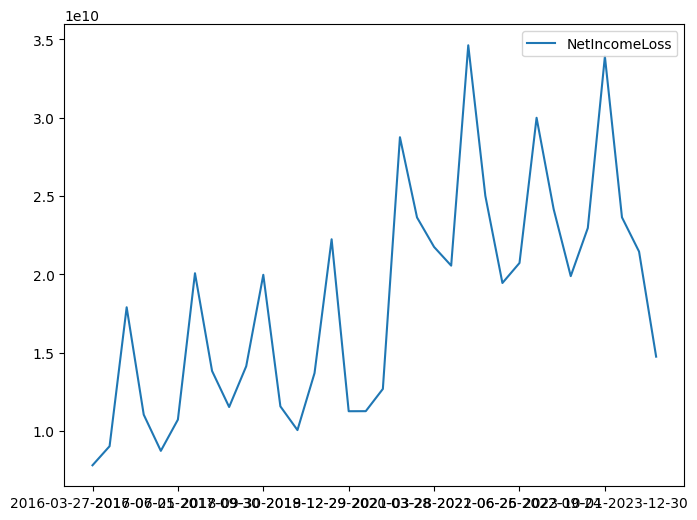

In [131]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

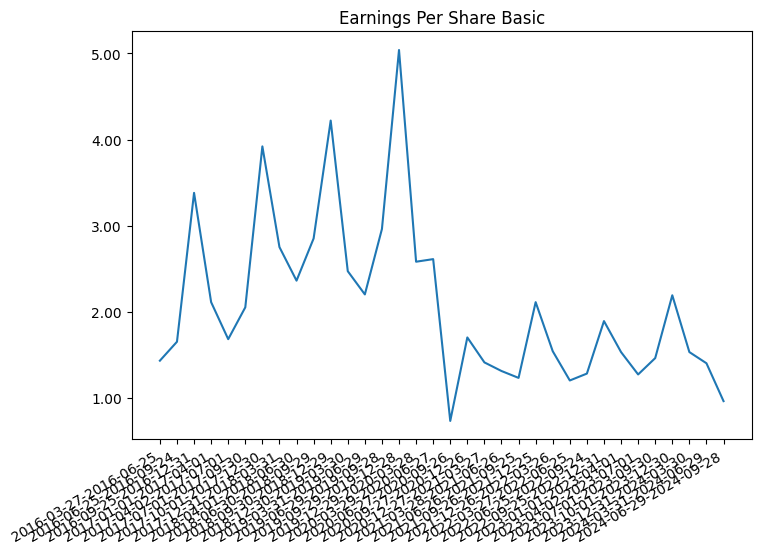

In [132]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float).loc["EarningsPerShareBasic"].plot.line()

ax.set_title('Earnings Per Share Basic')

# use higher precision for y axis labels
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()